In [1]:
import torch 
from torchvision import transforms
from PIL import Image
import time

#import torch.nn as nn
import torch.optim as optim
torch.autograd.set_detect_anomaly(True)
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

import math

import copy
from typing import Optional, List

from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn, Tensor

from torch.nn.utils.rnn import pad_sequence

from scipy.optimize import linear_sum_assignment

from ortools.graph.python import min_cost_flow

from sklearn.manifold import TSNE
import copy

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [30]:
def collate_fn(batch_len,PAD_IDX,train=True,recon=False,run=12,t_c=0):
    #print('batch',len(batch),batch)
    src1_batch, src2_batch, y_batch,d_batch = [], [], [], []
    if train:
        E1,E2,A,D,run,t=loadgraph()
        #print(run,t)
        im1,im2=cnn_loader(run=run,t_r=t)
    elif recon:
        E1,E2,A,D,run,t=loadgraph(recon=True, train=False,run=run,t_r=t_c)
        im1,im2=cnn_loader(run=run,t_r=t)
        #print('recon')
    else:
        E1,E2,A,D,run,t=loadgraph(train=False)
        im1,im2=cnn_loader(run=run,t_r=t)
    #print('src_sample',src_sample)
    src1_batch.append(E1)
    #print('emb',src_batch[-1])
    src2_batch.append(E2)
    y_batch.append(A)
    d_batch.append(D)


    #print('src_batch',src1_batch[3])
    #print('src2_batch',src2_batch[3])
    #print('src_batch s',len(src_batch))
    src1_batch = pad_sequence(src1_batch, padding_value=PAD_IDX)
    #print('src_batch',src_batch)
    #print('src_batch s',src_batch.size())
    src2_batch = pad_sequence(src2_batch, padding_value=PAD_IDX)
    
    
    #print('src1',src1_batch[:,0,:],src1_batch[:,0,:].size())
    #print('src2',src2_batch[:,0,:],src2_batch[:,0,:].size())
    #print('y',y_batch)
    ##
    return src1_batch,src2_batch,im1,im2,y_batch,d_batch


def loadgraph(train=True,run=None,easy=False,recon=False,t_r=None):
    convert_tensor = transforms.ToTensor()
    if train:
        if run==None:
            run=np.random.randint(1,75) #!!!!!!!!!!##100 total data size
        else: run=run
        E=np.loadtxt('./'+str(run)+'/'+'embed.txt')
        #print('E',E.shape)
        id,tt = np.loadtxt('./'+str(run)+'/'+'timetable.txt', delimiter='\t', usecols=(0,1), unpack=True)
        A=np.loadtxt('./'+str(run)+'_GT'+'/'+'A.txt')
        D=np.loadtxt('./'+str(run)+'/'+'D.txt')
        bg=A[0]
        for i in range(len(A)):
            for j in range(len(A)):
                if i>j:
                    A[i,j]=0
        #A=A+np.eye(len(A), dtype=int)
        
        t = np.random.randint(30) #!!!!!!!!how many t??
        id1 = id[tt==t].astype(int)
        if t==0:
            id1=id1[1:]
        id2 = id[tt==(t+1)].astype(int)
        
        #print(run,t,id1,id2)
        
        E1 = E[id1-1]
        E2 = E[id2-1]
       
        E_bg = E[0]
        
        E1=np.concatenate((np.array([E_bg]), E1), axis=0)
        E2=np.concatenate((np.array([E_bg]), E2), axis=0)
        
     
        
        A=A[id1-1]
        
        A=A[:,id2-1]
        
        
        D=D[id1-1]
        D=D[:,id2-1]
        
        
        
       
        
        #print(bg[id1-1])
        #print(bg[id2-1])
        
        
        A=np.concatenate((np.array([bg[id2-1]]), A), axis=0)
        
        bg_a=np.append(1,bg[id1-1])
        #print(bg_a)
        A=np.concatenate((np.array([bg_a]).T, A), axis=1)
        
        bg_b = np.append(0,np.zeros(len(bg[id1-1])))
        
        D=np.concatenate((np.array([np.zeros(len(bg[id2-1]))]), D), axis=0)
        D=np.concatenate((np.array([bg_b]).T, D), axis=1)
        
        #print(D)
        #print(np.dot(E1,E2.T))
        
        
        
        
    else:
        #print('eval')
        if run==None:
            run=np.random.randint(75,100) #!!!!!!!!
        else: run=run
        E=np.loadtxt('./'+str(run)+'/'+'embed.txt')
        id,tt = np.loadtxt('./'+str(run)+'/'+'timetable.txt', delimiter='\t', usecols=(0,1), unpack=True)
        A=np.loadtxt('./'+str(run)+'_GT'+'/'+'A.txt')
        D=np.loadtxt('./'+str(run)+'/'+'D.txt')
        bg=A[0]
        for i in range(len(A)):
            for j in range(len(A)):
                if i>j:
                    A[i,j]=0
        #A=A+np.eye(len(A), dtype=int)
        
        t = np.random.randint(30) #!!!!!!!!how many t??
        id1 = id[tt==t].astype(int)
        if t==0:
            id1=id1[1:]
        id2 = id[tt==(t+1)].astype(int)
        
        #print(run,t,id1,id2)
        
        E1 = E[id1-1]
        E2 = E[id2-1]
       
        E_bg = E[0]
        
        E1=np.concatenate((np.array([E_bg]), E1), axis=0)
        E2=np.concatenate((np.array([E_bg]), E2), axis=0)
        
     
        
        A=A[id1-1]
        
        A=A[:,id2-1]
        
        #print(A)
        
        D=D[id1-1]
        D=D[:,id2-1]
        
       
        
        #print(bg[id1-1])
        #print(bg[id2-1])
        
        
        A=np.concatenate((np.array([bg[id2-1]]), A), axis=0)
        
        bg_a=np.append(1,bg[id1-1])
        A=np.concatenate((np.array([bg_a]).T, A), axis=1)
        
        bg_b = np.append(0,np.zeros(len(bg[id1-1])))
        
        D=np.concatenate((np.array([np.zeros(len(bg[id2-1]))]), D), axis=0)
        D=np.concatenate((np.array([bg_b]).T, D), axis=1)
        
        
    if recon: 
        run=run
        E=np.loadtxt('./'+str(run)+'/'+'embed.txt')
        id,tt = np.loadtxt('./'+str(run)+'/'+'timetable.txt', delimiter='\t', usecols=(0,1), unpack=True)
        A=np.loadtxt('./'+str(run)+'_GT'+'/'+'A.txt')
        D=np.loadtxt('./'+str(run)+'/'+'D.txt')
        for i in range(len(A)):
            for j in range(len(A)):
                if i>j:
                    A[i,j]=0
        #A=A+np.eye(len(A), dtype=int)
        
        
        #print(id)
        t = t_r
        id1 = id[tt==t].astype(int)
        if t==0:
            id1=id1[1:]
        id2 = id[tt==(t+1)].astype(int)
        
        #print(run,t,id1,id2)
        
        E1 = E[id1-1]
        E2 = E[id2-1]
       
        E_bg = E[0]
        
        E1=np.concatenate((np.array([E_bg]), E1), axis=0)
        E2=np.concatenate((np.array([E_bg]), E2), axis=0)
        
     
        
        A=A[id1-1]
        
        A=A[:,id2-1]
        
        
        
        D=D[id1-1]
        D=D[:,id2-1]
        
        
        #print(A)
        
        
        #print(bg[id1-1])
        #print(bg[id2-1])
        
        
        A=np.concatenate((np.array([bg[id2-1]]), A), axis=0)
        
        bg_a=np.append(1,bg[id1-1])
        A=np.concatenate((np.array([bg_a]).T, A), axis=1)
       
        #print(E1,E2)
        
        bg_b = np.append(0,np.zeros(len(bg[id1-1])))
    
    
    
        D=np.concatenate((np.array([np.zeros(len(bg[id2-1]))]), D), axis=0)
        D=np.concatenate((np.array([bg_b]).T, D), axis=1)
    
    
    
   
    
    D=D.astype(np.float32)
    
    vd = np.vectorize(d_mask_function,otypes=[float])
    
    D = vd(D,0.15,-2.0)
    
    
    E1=E1.astype(np.float32)
    E2=E2.astype(np.float32)
    A=A.astype(np.float32)
    #A=A.astype(np.float32)
    
    
    
    E1=convert_tensor(E1) 
    E2=convert_tensor(E2) 
    A=convert_tensor(A)
    D=convert_tensor(D)
    
    #print(E1[0].size(),E1[0])
    #print(E2[0].size(),E2[0])
    #print(A,A.size())
    #print('E',E.size())
    
    return E1[0],E2[0],A[0],D[0],run,t


def cnn_loader(run=None,t_r=None):


    run=run
    t=t_r
    E1=torch.load('./'+str(run)+'/'+str(t)+'.pt')
    E2=torch.load('./'+str(run)+'/'+str(t+1)+'.pt')

    
   

    
    #print(E1[0].size(),E1[0])
    #print(E2[0].size(),E2[0])
    #print('A',A.size())
    #print('E1',E1.size())
    #print('E2',E2.size())
    
    return E1,E2

def create_mask(src,PAD_IDX):
    
    src= src[:,:,0]

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    #print('src_padding_mask',src_padding_mask,src_padding_mask.size())
    return src_padding_mask



class makeAdja:
    def __init__(self):
        pass
        
    def forward(self,z:Tensor,
                mask1: Tensor,
                mask2: Tensor):
        Ad = []
        for i in range(z.size(0)):
            n=len([i for i, e in enumerate(mask1[i]) if e != True])
            m=len([i for i, e in enumerate(mask2[i]) if e != True])
            Ad.append(z[i,0:n,0:m])
        
        
        return Ad
    
    
    
def train_epoch(model, optimizer,loss_fn):
    model.train()
    losses = 0
    
    src1, src2,im1,im2,y,d = collate_fn(1,-100)
        
    src1= src1.to(DEVICE)
    src2= src2.to(DEVICE)
    
    im1= im1.to(DEVICE)
    im2= im2.to(DEVICE)
    
    src_padding_mask1=create_mask(src1,-100)
    src_padding_mask2=create_mask(src2,-100)
    try:
        Ad,out1,out2,out_dec1,src1_t1,src2_t2 = model(src1,src2,src_padding_mask1,src_padding_mask2,im1,im2)
    except:    
        Ad = model(src1,src2,src_padding_mask1,src_padding_mask2,im1,im2)

    optimizer.zero_grad()

   
    loss = loss_fn.loss(Ad,y)
    
    #print(Ad[0],y[0])
    #print('l',loss)
    #print('l',loss.item() / len(src1))
    
    loss.backward()

    optimizer.step()
    losses += loss.item()
    
    

    return losses / len(src1)


class Loss():
    def __init__(self,pen,tra_to_tens=False):
        self.pen=pen
        self.trans=tra_to_tens
        
    def loss (self,Ad,y):
        convert_tensor = transforms.ToTensor()
        loss=0
        
        for i in range(len(Ad)):
            l = nn.CrossEntropyLoss()
            if self.trans:
                Ad[i]=convert_tensor(Ad[i])[0]
            #print(Ad[i], y[i])
            
            s = l(Ad[i], y[i])
            
            loss=loss+s
                
        if self.trans:
            loss = Variable(loss, requires_grad = True)
        return loss
    


def evaluate(model,loss_fn):
    #model.eval()
    losses = 0

    src1, src2,im1,im2,y,d = collate_fn(1,-100)
        
    src1= src1.to(DEVICE)
    src2= src2.to(DEVICE)
    
    im1= im1.to(DEVICE)
    im2= im2.to(DEVICE)
    
    src_padding_mask1=create_mask(src1,-100)
    src_padding_mask2=create_mask(src2,-100)
    try:
        Ad,out1,out2,out_dec1,src1_t1,src2_t2 = model(src1,src2,src_padding_mask1,src_padding_mask2,im1,im2)
    except:    
        Ad = model(src1,src2,src_padding_mask1,src_padding_mask2,im1,im2)

    
   
    loss = loss_fn.loss(Ad,y)
    
    losses += loss.item()
    
        

    return losses / len(src1)




def square(m):
    return m.shape[0] == m.shape[1]

def postprocess_MinCostAss(Ad,a):
    pp_A=[]
    for h in range(len(Ad)):
        smcf = min_cost_flow.SimpleMinCostFlow()
        c_A = Ad[h]
        
        #left_n=c_A.size(0)
        #right_n=c_A.size(1)
        
        left_n=c_A.shape[0]
        right_n=c_A.shape[1]
        
        
        st=np.zeros(left_n)
        con= np.ones(right_n) 
        for v in range(left_n-1):
            con= np.append(con, np.ones(right_n)*(v+2))
        #print('con',con) 
        si = np.arange(left_n+1,left_n+right_n+1)
        start_nodes = np.concatenate((st,np.array(con),si))
        start_nodes = np.append(start_nodes,0)
        start_nodes = [int(x) for x in start_nodes ]
        #print(start_nodes)
        
        st_e = np.arange(1,left_n+1)
        con_e = si
        for j in range(left_n-1):
            con_e = np.append(con_e,si)
            
        si_e = np.ones(right_n)*left_n+right_n+1
        
        end_nodes = np.concatenate((st_e,np.array(con_e),si_e))
        end_nodes = np.append(end_nodes,si_e[-1])
        end_nodes = [int(x) for x in end_nodes ]
        #print(end_nodes)
        
        
        tasks = np.max([right_n,left_n])
        
        cap_0 = np.ones(left_n)
        cap_0[0]=right_n-1
        
        cap_left=np.ones(right_n)
        cap_left[0]=right_n
        
        capacities = np.concatenate((cap_0,np.ones(len(con_e)),cap_left))
        capacities = np.append(capacities,tasks)
        capacities = [int(x) for x in capacities]
        #print(capacities)
        
        '''
        c_A[0]=c_A[0]/c_A[0,0]
        c_A[0]=c_A[0]/(1.01*np.max(c_A[0]))
        c_A[:,0]=c_A[:,0]/c_A[0,0]
        c_A[:,0]=c_A[:,0]/(1.01*np.max(c_A[:,0]))
        '''
        
        #print(c_A)
        c= c_A.flatten()                          
        #c=torch.flatten(c_A)
        #c=c.detach().numpy()  
                                    
                                    
        c=(1-c)*10**4
        
        #print(c)
                                    
        costs = np.concatenate((np.zeros(left_n),c,np.zeros(right_n)))
        costs = np.append(costs,a*np.mean(c))                            
        costs = [int(x) for x in costs]
                                    
        #print(costs)
        
        source = 0
        sink = left_n+right_n+1
        
        supplies= tasks 
        
        supplies=np.append(supplies,np.ones(left_n))
        supplies=np.append(supplies,np.zeros(right_n))
        
        #supplies=np.append(supplies,np.zeros(left_n+right_n))
        
        supplies=np.append(supplies,-(tasks+left_n))
        
        supplies = [int(x) for x in supplies]
        #print(supplies)
        #print('____________________________________')
        # Add each arc.
        for i in range(len(start_nodes)):
            #print(start_nodes[i], end_nodes[i],capacities[i], costs[i])
            smcf.add_arc_with_capacity_and_unit_cost(start_nodes[i], end_nodes[i],
                                                 capacities[i], costs[i])
        # Add node supplies.
        for i in range(len(supplies)):
            smcf.set_node_supply(i, supplies[i])

        # Find the minimum cost flow between node 0 and node 10.
        status = smcf.solve()

        if status == smcf.OPTIMAL:
            #print('Total cost = ', smcf.optimal_cost())
            #print()
            row_ind=[]
            col_ind=[]
            for arc in range(smcf.num_arcs()):
                # Can ignore arcs leading out of source or into sink.
                if smcf.tail(arc) != source and smcf.head(arc) != sink:

                    # Arcs in the solution have a flow value of 1. Their start and end nodes
                    # give an assignment of worker to task.
                    if smcf.flow(arc) > 0:
                        #p#rint('Worker %d assigned to task %d.  Cost = %d Flow = %d' %
                        #      (smcf.tail(arc), smcf.head(arc), smcf.unit_cost(arc),smcf.flow(arc)))
                        row_ind.append(smcf.tail(arc)-1)
                        col_ind.append(smcf.head(arc)-left_n-1)
            z=np.zeros((left_n,right_n))
            
            for i,j in zip(row_ind, col_ind):
                z[i,j]=1
             
            
            #print('z_orig',z)
            s=np.sum(z,axis=1)
            for e in range(len(s)):
                if s[e]>1 and e!=0:
                    z[e,0]=0
            #print('z_bg_cor',z)      
            if (~z.any(axis=0)).any():
                z_col_ind=np.where(~z.any(axis=0))[0]
                z[:,z_col_ind]=c_A[:,z_col_ind]
                #print('---------z_0_col',z)
                z=postprocess_MinCostAss(np.array([z]),2*a)[0]
                #print('z_0_col_after',z)

                    
            pp_A.append(z)
                    
                #else:
                    #print('Worker %d assigned to task %d.  Cost = %d  Flow = %d' %
                      #    (smcf.tail(arc), smcf.head(arc), smcf.unit_cost(arc),smcf.flow(arc)))
                
        else:
            print('There was an issue with the min cost flow input.')
            print(f'Status: {status}')
          



    return pp_A

      


def make_reconstructed_edgelist(A,run):
    
    e_start=[2,3,4]
    e1=[]
    e2=[]
    
    
    for i in range(len(A)):
        M=A[i]
        #print('M0',M)
        X=M[0][1:]
        M=M[1:,1:]
        #print('M1',M)
        
        
        for z in range(len(M)):
            for j in range(len(M[0])):
                e_mid=np.arange(e_start[-1]+1,e_start[-1]+len(M[0])+1)
                if M[z,j]!=0:
                    #print(z,e_start)
                    e1.append(int(e_start[z]))
                    #print('e',e_mid)
                    e2.append(int(e_mid[j]))
                if z==0 and X[j]!=0:
                    e1.append(int(1))
                    e2.append(int(e_mid[j]))
                    
        
        e_start=e_mid
        #print('mid',e_mid)
    
    
    np.savetxt('./'+str(run)+'_GT'+'/'+'reconstruct.edgelist', np.c_[e1,e2], fmt='%i',delimiter='\t')
    return 0

def d_mask_function(x,r_core,alpha):
    if x < r_core:
        return 1
    else:
        return (x/r_core)**alpha
    
    
def complete_postprocess(Ad,d,a):
    
    Ad_n = []
    #Ad_n=copy.deepcopy(Ad)
    
    for h in range(len(Ad)):
        
        A_t,ill_flag=treshold(Ad[h],t=0.5)
        
        #print('ill_flag',ill_flag)
        #print(Ad[h],A_t)
        ill_flag==True #!!!!!!!
        if ill_flag==True:
            print('d*A',np.multiply(Ad[h].detach().numpy(),d[h].detach().numpy()))
            Ad[h]=np.multiply(Ad[h].detach().numpy(),d[h].detach().numpy())
            print('d*A',Ad[h])
            
            A_t = postprocess_MinCostAss(np.array([Ad[h]]),a)[0]
            
        #print(Ad[h],A_t)
        Ad_n.append(A_t)
    #Ad=postprocess_MinCostAss(Ad)



    return Ad_n

def treshold(matrix, t):
    z=np.where(matrix >= t, 1, 0)
    
    ill_flag=False

      
    if (~z.any(axis=0)).any() or any(np.sum(z[:,1:], axis=0)>1):
        ill_flag=True
          
    return z,ill_flag

def err_perc(a,b):
    w=0
    s=0
    for i in range(len(a)):
        m=a[i]-b[i].detach().numpy()
        w=w+0.5*np.sum(np.abs(m))
        s=s+np.size(m)
    
    
    #print('w,s',w,s)
    
    return w*100/s

In [31]:
class AdjTra_cnn(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 out = False, 
                 dim_feedforward: int = 512,
                 dropout: float = 0.05):
        super(AdjTra_cnn, self).__init__()
        
        
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_size, nhead=nhead,dim_feedforward=dim_feedforward)
        decoder_layer = nn.TransformerDecoderLayer(d_model=emb_size, nhead=nhead,dim_feedforward=dim_feedforward)
        
        
        self.decoder_1 = nn.TransformerDecoder(decoder_layer, num_layers=num_encoder_layers)
        self.decoder_2 = nn.TransformerDecoder(decoder_layer, num_layers=num_encoder_layers)
        #self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        
        self.out=out 

        
        self.conv1_1 = nn.Conv2d(3, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2_1 = nn.Conv2d(64, 125, 3)
        
   
        self.fc1_1 = nn.Sequential(
            nn.Linear(1125, 350),
            nn.LeakyReLU())
        
        self.fc2_1 = nn.Sequential(
            nn.Linear(350, 60),
            nn.LeakyReLU())
        
       
        
        self.conv1_2 = nn.Conv2d(3, 64, 3)
        self.conv2_2 = nn.Conv2d(64, 125, 3)
        
        self.fc1_2 = nn.Sequential(
            nn.Linear(1125, 350),
            nn.LeakyReLU())
        
        self.fc2_2 = nn.Sequential(
            nn.Linear(350, 60),
            nn.LeakyReLU())

    
        self.drop = nn.Dropout(p=dropout)


        
        self.sig = torch.nn.Sigmoid()
        self.Ad = makeAdja()
        

    def forward(self,
                src_t1: Tensor,
                src_t2: Tensor,
                src_padding_mask1: Tensor,
                src_padding_mask2: Tensor,
                im_src1: Tensor,
                im_src2: Tensor):
        
        #print('trans_src_before_pos',src_t1,src_t1.size())
        #print('trans_src_toke',self.src_tok_emb(src),self.src_tok_emb(src).size())
      
        
        src1_emb = src_t1[:,0,:]
        src2_emb = src_t2[:,0,:]
        #print('src1',src1_emb.size())
        #print('src2',src2_emb.size())
        
        im_t1 = self.pool(F.relu(self.conv1_1(im_src1)))
        im_t1 = self.pool(F.relu(self.conv2_1(im_t1)))
        
        im_t1 = torch.flatten(im_t1, 1)
        im_t1 = self.drop(im_t1)
        
        #print('sizes1',im_t1.size())
        
        im_t1 = self.fc1_1(im_t1)
        im_t1 = self.fc2_1(im_t1)
    
        
        
        
        im_t2 = self.pool(F.relu(self.conv1_2(im_src2)))
        im_t2 = self.pool(F.relu(self.conv2_2(im_t2)))
        
        im_t2 = torch.flatten(im_t2, 1)
        im_t2 = self.drop(im_t2)
        
        #print('sizes1',src_t1.size())
        
        im_t2 = self.fc1_2(im_t2)
        im_t2 = self.fc2_2(im_t2)
        
        
        #print('sizes1',src1_emb.size(),im_t1.size())
        #print('sizes2',src2_emb.size(),im_t2.size())
        
        
        
        out_dec1=self.decoder_1(src1_emb, im_t1)
        
        out_dec2=self.decoder_2(src2_emb, im_t2)
     
        
        #out_dec1=torch.transpose(out_dec1,0,1)
        out_dec2=torch.transpose(out_dec2,0,1)
        
        
        z=self.sig(torch.matmul(out_dec1,out_dec2))
        
        
        #Ad=self.Ad.forward(z,src_padding_mask1,src_padding_mask2)


        return [z]


In [4]:
input_dim=3

emb_size= 60 ###!!!!24 for n2v emb
nhead= 6    ####!!!! 6 for n2v emb
num_encoder_layers = 3


transformer = AdjTra_cnn(num_encoder_layers, emb_size, nhead)



for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = Loss(pen=0)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [5]:
from timeit import default_timer as timer
NUM_EPOCHS = 15

loss_over_time=[]
test_error=[]

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer,loss_fn)
    end_time = timer()
    val_loss = evaluate(transformer,loss_fn)
    
    
    loss_over_time.append(train_loss)
    np.savetxt('./'+'train_loss.txt', np.c_[loss_over_time],delimiter='\t',header='trainloss')
    
    test_error.append(val_loss)
                
    np.savetxt('./'+'test_loss.txt', np.c_[test_error],delimiter='\t',header='testloss')

    
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    
torch.save(transformer.state_dict(), 'AttTrackcnn.pt')


Epoch: 1, Train loss: 0.217, Val loss: 0.317, Epoch time = 0.505s
Epoch: 2, Train loss: 0.254, Val loss: 0.307, Epoch time = 0.607s
Epoch: 3, Train loss: 0.295, Val loss: 0.298, Epoch time = 0.723s
Epoch: 4, Train loss: 0.257, Val loss: 0.271, Epoch time = 0.603s
Epoch: 5, Train loss: 0.601, Val loss: 0.250, Epoch time = 0.687s
Epoch: 6, Train loss: 0.245, Val loss: 0.209, Epoch time = 0.677s
Epoch: 7, Train loss: 0.254, Val loss: 0.246, Epoch time = 0.584s
Epoch: 8, Train loss: 0.222, Val loss: 0.242, Epoch time = 0.609s
Epoch: 9, Train loss: 0.343, Val loss: 0.281, Epoch time = 0.711s
Epoch: 10, Train loss: 0.284, Val loss: 0.286, Epoch time = 0.865s
Epoch: 11, Train loss: 0.381, Val loss: 0.258, Epoch time = 0.789s
Epoch: 12, Train loss: 0.252, Val loss: 0.231, Epoch time = 0.860s
Epoch: 13, Train loss: 0.257, Val loss: 0.282, Epoch time = 0.976s
Epoch: 14, Train loss: 0.379, Val loss: 0.188, Epoch time = 0.825s
Epoch: 15, Train loss: 0.204, Val loss: 0.232, Epoch time = 0.766s


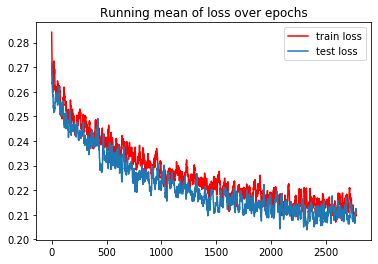

In [6]:
loss_over_time= np.loadtxt('./train_loss_AttTrack_cnn.txt',skiprows=1, delimiter='\t', usecols=(0), unpack=True)
test_error= np.loadtxt('./test_loss_AttTrack_cnn.txt',skiprows=1, delimiter='\t', usecols=(0), unpack=True)


N=10
plt.plot(np.convolve(loss_over_time, np.ones(N)/N, mode='valid'),c='red',label='train loss')
plt.plot(np.convolve(test_error, np.ones(N)/N, mode='valid'),label='test loss')
plt.title('Running mean of loss over epochs')
plt.legend()

In [41]:
#recon+testerror
L_list_a=np.zeros(30)
for r in range(80,95):
    Ad_list=[]
    err_list=[]
    L_list=[]
    print('++++++r',r)
    for j in range(30):
        src1, src2,im1,im2,y,d = collate_fn(1,-100,recon=True,train=False,run=r,t_c=j)

        src1= src1.to(DEVICE)
        src2= src2.to(DEVICE)

        im1= im1.to(DEVICE)
        im2= im2.to(DEVICE)

        src_padding_mask1=create_mask(src1,-100)
        src_padding_mask2=create_mask(src2,-100)



    
        

    
        transformer.load_state_dict(torch.load('AttTrack_cnn.pt',map_location=torch.device('cpu')))
        transformer.eval()



        Ad = transformer(src1,src2,src_padding_mask1,src_padding_mask2,im1,im2)
        
        print('Ad0',Ad)

        val_loss = loss_fn.loss(Ad,y)/ len(src1)
    
        print('L',val_loss)
        a=0.1
        pp_A = complete_postprocess(Ad,d,a)

        err_p=err_perc(pp_A,y)
        print('err',r,err_p)

    #print(src1.size())

        print('y',y)
        #print('Ad',Ad)
        print('pp',pp_A)
        print('d',d)
        #print(val_loss)
        err_list.append(err_p)
        #L_list=L_list+val_loss
        L_list.append(val_loss.detach().numpy())
        Ad_list.append(pp_A[0])
#for i in range(5):
#    print(pp_A[i])
    #print('y',y)
    #print('Ad',Ad)
    #print('pp',pp_A)
    #print('d',d)
    L_list_a=L_list_a+np.array(L_list)
    make_reconstructed_edgelist(Ad_list,run=r)

++++++r 80
Ad0 [tensor([[1.0000e+00, 2.2453e-01, 1.4530e-11, 4.1525e-01],
        [1.7279e-06, 9.7977e-01, 2.6853e-12, 9.9998e-01],
        [1.7518e-14, 1.4680e-11, 1.0000e+00, 5.9787e-12],
        [3.0798e-08, 3.9405e-01, 3.9360e-11, 9.9185e-01]],
       grad_fn=<SigmoidBackward0>)]
L tensor(0.2525, grad_fn=<DivBackward0>)
d*A [[1.00000000e+00 2.24531829e-01 1.45299484e-11 4.15246874e-01]
 [1.72787293e-06 9.79769468e-01 4.74339772e-13 9.99979496e-01]
 [1.75181152e-14 2.75008735e-12 1.00000000e+00 1.10806367e-12]
 [3.07983434e-08 3.94049376e-01 5.94056777e-12 9.91851151e-01]]
d*A [[1.00000000e+00 2.24531829e-01 1.45299484e-11 4.15246874e-01]
 [1.72787293e-06 9.79769468e-01 4.74339772e-13 9.99979496e-01]
 [1.75181152e-14 2.75008735e-12 1.00000000e+00 1.10806367e-12]
 [3.07983434e-08 3.94049376e-01 5.94056777e-12 9.91851151e-01]]
err 80 12.5
y [tensor([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.]])]
pp [array([[1., 0., 0., 0.],
       [0.

Ad0 [tensor([[1.0000e+00, 6.5009e-14, 3.8931e-03, 1.1166e-10, 3.7192e-08],
        [9.9984e-01, 1.0223e-08, 2.4930e-07, 1.4075e-05, 2.6438e-02],
        [2.9536e-08, 7.5028e-03, 4.9211e-04, 1.8347e-07, 4.8374e-09],
        [2.8342e-13, 1.0000e+00, 2.0629e-08, 1.9476e-13, 7.7321e-16],
        [2.8341e-08, 2.4897e-11, 8.7927e-01, 9.9670e-01, 6.2723e-01]],
       grad_fn=<SigmoidBackward0>)]
L tensor(0.3636, grad_fn=<DivBackward0>)
err 80 12.0
y [tensor([[1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1.]])]
pp [array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 1, 1]])]
d [tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 0.3928, 1.0000, 0.6076, 0.9433],
        [1.0000, 1.0000, 0.3548, 0.1526, 0.1604],
        [1.0000, 0.5528, 0.1726, 0.1372, 0.1164],
        [1.0000, 0.1729, 1.0000, 1.0000, 1.0000]], dtype=torch.float64)

Ad0 [tensor([[1.0000e+00, 1.7063e-01, 2.9294e-11, 5.7016e-05, 1.0780e-03, 2.0931e-05,
         5.1542e-10],
        [5.7606e-10, 7.6200e-07, 1.1455e-01, 3.3623e-02, 2.3009e-08, 3.0737e-04,
         8.7965e-11],
        [8.0937e-09, 6.4939e-01, 3.2356e-06, 3.2928e-10, 9.9998e-01, 1.1238e-10,
         9.5962e-01],
        [2.8916e-08, 6.8553e-10, 1.4791e-08, 1.3021e-06, 4.2504e-05, 5.9570e-05,
         2.6131e-06],
        [1.7993e-02, 1.0469e-07, 6.5722e-13, 1.5881e-09, 2.4753e-03, 5.6625e-15,
         1.0000e+00],
        [2.5435e-05, 1.2761e-12, 2.3618e-03, 4.4509e-01, 2.3321e-12, 1.6737e-06,
         5.1336e-07],
        [2.9031e-04, 1.2136e-02, 1.3432e-05, 2.9652e-06, 2.1995e-06, 9.3038e-02,
         1.4521e-08]], grad_fn=<SigmoidBackward0>)]
L tensor(0.2923, grad_fn=<DivBackward0>)
d*A [[1.00000000e+00 1.70628548e-01 2.92943100e-11 5.70164993e-05
  1.07802113e-03 2.09314949e-05 5.15415710e-10]
 [5.76061310e-10 4.72700739e-08 1.09002883e-02 5.79864908e-03
  1.55398734e-09 3.07948155

Ad0 [tensor([[1.0000e+00, 1.4736e-14, 1.7025e-09, 1.2853e-04, 2.4901e-09, 5.1812e-06],
        [8.8017e-06, 8.0807e-06, 4.9390e-01, 4.8471e-07, 9.9987e-10, 9.9997e-01],
        [9.9876e-01, 9.0643e-10, 9.1080e-07, 9.8590e-14, 9.3529e-13, 4.8941e-02],
        [8.6586e-01, 2.3112e-04, 2.6011e-08, 1.1332e-03, 7.0367e-10, 9.4977e-04],
        [3.8265e-14, 9.9685e-01, 1.0340e-05, 7.9385e-03, 7.0530e-01, 1.3965e-09],
        [1.1347e-11, 1.5149e-06, 6.1055e-05, 6.9466e-07, 9.9928e-01, 4.1243e-11]],
       grad_fn=<SigmoidBackward0>)]
L tensor(0.2616, grad_fn=<DivBackward0>)
d*A [[1.00000000e+00 1.47357017e-14 1.70247128e-09 1.28534128e-04
  2.49005105e-09 5.18120214e-06]
 [8.80169682e-06 2.66556435e-06 4.93898541e-01 2.15145639e-07
  1.93069350e-10 9.99974370e-01]
 [9.98763561e-01 4.26235873e-10 9.10802100e-07 3.60966546e-14
  1.35196359e-13 4.89406772e-02]
 [8.65855336e-01 2.31123806e-04 1.15753005e-08 1.13318674e-03
  3.32987350e-10 3.88068631e-04]
 [3.82646863e-14 9.96854782e-01 4.7869404

Ad0 [tensor([[9.9998e-01, 1.3708e-04, 6.9205e-07, 3.2186e-14, 1.9839e-10, 1.8577e-06,
         1.1805e-08, 4.3800e-01, 2.7801e-10],
        [8.9771e-09, 1.1719e-05, 5.0027e-03, 1.5289e-08, 2.3845e-09, 5.1952e-11,
         2.1161e-12, 2.9055e-05, 9.9920e-01],
        [9.5968e-03, 1.6340e-07, 4.5137e-04, 1.7983e-03, 8.8022e-04, 9.5971e-12,
         6.4497e-01, 1.5757e-17, 6.0053e-15],
        [5.9621e-12, 7.7674e-13, 7.1116e-02, 3.8586e-07, 1.3733e-10, 1.9399e-08,
         7.4695e-13, 8.0308e-01, 9.9849e-01],
        [7.2743e-07, 3.0274e-07, 7.4013e-07, 4.2307e-07, 1.2143e-01, 1.3944e-05,
         9.9995e-01, 6.2722e-02, 2.8753e-14],
        [7.6195e-08, 7.2493e-11, 1.3979e-05, 4.0979e-04, 1.1932e-05, 2.8910e-06,
         9.6203e-01, 6.8642e-09, 6.8314e-12],
        [6.9053e-02, 1.0000e+00, 1.5701e-09, 1.2300e-08, 2.0719e-12, 3.4838e-06,
         9.0406e-09, 6.4876e-07, 1.3357e-08]], grad_fn=<SigmoidBackward0>)]
L tensor(0.3759, grad_fn=<DivBackward0>)
d*A [[9.99978900e-01 1.37080133e-04

Ad0 [tensor([[9.9960e-01, 1.0839e-13, 2.7395e-12, 9.9745e-05, 4.8256e-01, 1.4244e-06,
         5.8168e-11, 1.1076e-05, 3.9026e-01, 4.4830e-08],
        [2.9907e-12, 2.2327e-05, 1.1114e-01, 2.3728e-01, 2.1293e-04, 2.9709e-12,
         8.2729e-01, 6.3740e-07, 3.1658e-05, 1.0286e-11],
        [1.0789e-08, 6.9382e-03, 1.3314e-11, 3.4854e-03, 3.0537e-08, 1.0081e-10,
         7.0547e-07, 1.0482e-06, 8.6456e-01, 2.9659e-03],
        [5.3274e-05, 2.0669e-03, 2.0536e-03, 2.7063e-11, 2.3747e-07, 8.2921e-07,
         9.9999e-01, 2.2768e-15, 8.2306e-01, 1.9482e-08],
        [1.3592e-08, 1.8203e-04, 3.4645e-03, 9.2380e-01, 6.6837e-06, 5.3521e-08,
         2.7476e-06, 8.6831e-01, 2.2960e-07, 3.9786e-08],
        [5.2115e-08, 2.7089e-05, 7.6510e-03, 1.6358e-08, 1.3958e-11, 1.0692e-06,
         6.8896e-08, 9.9598e-01, 6.2675e-06, 3.5769e-01],
        [1.2346e-01, 3.6867e-07, 7.9486e-03, 6.2951e-10, 1.3171e-10, 1.1156e-07,
         1.9752e-09, 3.0457e-06, 5.3789e-04, 9.9532e-01],
        [1.8000e-06, 1

Ad0 [tensor([[9.9997e-01, 4.0833e-05, 1.2223e-08, 4.8830e-09, 1.0154e-09, 6.6087e-02,
         7.9860e-08, 7.2897e-09, 5.6508e-07, 1.9217e-12, 6.4437e-08, 5.1261e-09],
        [2.7623e-10, 1.0340e-03, 9.9186e-02, 5.5028e-02, 1.2219e-04, 8.8469e-03,
         3.7916e-07, 1.4634e-12, 2.3744e-01, 2.3118e-10, 6.6548e-06, 2.1662e-10],
        [9.0256e-07, 8.2928e-01, 8.6691e-10, 8.8696e-09, 2.0196e-05, 4.1085e-08,
         1.0841e-17, 8.8325e-01, 5.4352e-07, 8.0185e-10, 1.8215e-06, 7.8355e-02],
        [1.3394e-01, 6.2088e-01, 8.1803e-04, 4.5583e-09, 5.2858e-03, 4.8620e-09,
         3.6262e-05, 7.7197e-03, 1.5572e-06, 2.3732e-10, 2.8236e-05, 3.1068e-04],
        [1.5674e-04, 2.3053e-06, 2.4055e-03, 7.7161e-11, 9.1981e-01, 3.8888e-10,
         1.5705e-07, 4.9360e-06, 3.2648e-10, 1.8534e-02, 9.8539e-01, 1.2410e-01],
        [1.0603e-06, 2.3428e-09, 1.1683e-08, 9.9993e-01, 8.1333e-08, 4.9262e-07,
         2.0600e-07, 2.9134e-13, 6.5375e-10, 2.9678e-05, 2.8103e-10, 1.0918e-05],
        [1.4376e-

Ad0 [tensor([[1.0000e+00, 3.3533e-07, 9.0011e-04, 6.7846e-12, 4.4899e-05, 1.0364e-05,
         8.3623e-12, 2.4752e-06, 1.0933e-10, 1.3869e-06, 2.6874e-08, 5.6506e-09],
        [1.0000e+00, 2.3086e-04, 4.9335e-10, 9.2590e-13, 4.3577e-10, 3.0857e-07,
         3.8670e-06, 1.3803e-08, 1.1182e-03, 9.9152e-01, 3.3726e-14, 4.0428e-09],
        [3.9895e-08, 1.7335e-07, 3.3884e-12, 1.6301e-04, 1.2287e-06, 4.9447e-04,
         6.6676e-09, 1.6178e-04, 1.8095e-08, 1.3462e-09, 1.6017e-04, 4.4900e-05],
        [3.0857e-04, 9.9799e-01, 5.0928e-03, 2.4648e-04, 6.2667e-07, 5.9796e-05,
         3.2293e-10, 2.3429e-11, 8.5078e-12, 8.7939e-07, 5.7015e-06, 2.5436e-04],
        [1.8796e-08, 1.3664e-09, 1.6349e-04, 9.9965e-01, 4.5251e-01, 1.4209e-08,
         1.2995e-05, 9.9077e-13, 8.3573e-10, 2.4482e-05, 1.0395e-01, 1.0309e-09],
        [3.6192e-10, 5.5123e-01, 4.5646e-07, 6.1701e-06, 8.2973e-11, 1.9251e-06,
         1.6534e-07, 7.4185e-11, 1.2280e-02, 5.5133e-06, 1.3907e-07, 2.7364e-12],
        [1.7293e-

Ad0 [tensor([[1.0000e+00, 6.0704e-07, 6.4345e-04, 1.2982e-03, 3.1400e-05, 5.5392e-09,
         8.0748e-04, 3.8695e-09, 5.7946e-09, 2.0762e-07, 6.1234e-11, 1.1294e-12,
         1.4153e-03],
        [4.0148e-10, 1.7968e-03, 1.1620e-06, 1.1202e-11, 1.0141e-06, 3.2771e-08,
         9.0370e-01, 9.9854e-01, 9.7224e-01, 9.1480e-11, 2.7236e-12, 2.5429e-11,
         1.1746e-11],
        [9.9688e-01, 1.4934e-11, 1.2579e-09, 9.7101e-01, 8.9083e-01, 4.5304e-07,
         1.7606e-07, 1.9206e-15, 1.1440e-06, 1.3953e-06, 1.8236e-06, 2.1035e-06,
         1.0000e+00],
        [1.0376e-11, 5.0496e-09, 9.9497e-01, 2.3577e-08, 4.9688e-15, 9.9999e-01,
         3.4326e-11, 1.1086e-05, 6.5829e-11, 2.6432e-08, 6.6045e-01, 2.5723e-06,
         2.2207e-10],
        [2.7144e-08, 9.2963e-09, 1.5945e-08, 8.9856e-01, 1.1681e-15, 8.3002e-01,
         8.9364e-07, 1.4266e-10, 3.8017e-05, 8.1029e-04, 3.7243e-09, 9.9598e-15,
         9.6017e-01],
        [9.3554e-07, 8.0008e-05, 1.0000e+00, 3.3746e-17, 3.4442e-05, 8.3845

Ad0 [tensor([[1.0000e+00, 9.0794e-07, 2.9326e-06, 8.4511e-09, 7.3805e-09, 1.0408e-03,
         2.6414e-10, 3.7840e-05, 5.5635e-09, 1.8290e-11, 9.8481e-05, 1.3583e-06],
        [3.2559e-05, 4.9348e-08, 3.6807e-04, 5.6027e-07, 1.0558e-06, 4.6338e-03,
         6.6544e-01, 9.7361e-12, 6.7053e-06, 3.5909e-03, 8.5789e-12, 4.9493e-05],
        [2.7748e-04, 1.0037e-07, 2.2458e-08, 2.0825e-09, 1.0619e-04, 2.8405e-13,
         9.9540e-01, 1.0319e-03, 1.4748e-07, 2.5855e-03, 2.3528e-07, 1.2829e-07],
        [2.2773e-05, 9.2874e-03, 2.1993e-07, 3.8439e-06, 4.6362e-13, 3.3668e-03,
         4.1734e-07, 4.7664e-01, 1.8909e-05, 9.3085e-12, 1.0301e-02, 3.1522e-10],
        [7.7779e-07, 1.4052e-08, 7.2141e-11, 5.0134e-08, 5.6844e-07, 3.3389e-09,
         6.3036e-10, 1.0537e-06, 9.9704e-01, 8.8992e-06, 3.7244e-01, 4.0159e-08],
        [6.4105e-05, 3.8246e-06, 1.2452e-05, 1.7032e-05, 1.4043e-07, 3.2270e-06,
         2.2725e-02, 2.0756e-06, 5.3907e-14, 2.6510e-06, 4.8626e-08, 8.1472e-08],
        [2.3911e-

Ad0 [tensor([[1.0000e+00, 1.4845e-07, 5.1643e-08, 9.8985e-06, 2.1414e-04, 4.6404e-04,
         7.7161e-09, 7.6167e-11, 3.2852e-07, 5.2195e-05, 3.4002e-03, 4.6305e-06,
         6.2796e-11, 1.2573e-13, 7.3108e-03],
        [1.5328e-06, 1.9522e-02, 1.0119e-06, 6.0047e-13, 2.9532e-03, 1.5105e-12,
         3.6550e-02, 3.9020e-07, 1.2806e-04, 6.2689e-05, 7.9286e-09, 7.4250e-02,
         3.4110e-03, 2.5935e-02, 1.2446e-03],
        [1.8050e-05, 8.4391e-12, 5.2045e-05, 7.0858e-05, 1.1685e-04, 2.0102e-09,
         1.7043e-07, 2.3728e-13, 2.2847e-05, 5.1749e-09, 8.0251e-01, 1.6217e-07,
         2.0198e-01, 1.1855e-04, 3.0094e-03],
        [1.0043e-06, 1.3390e-03, 9.5048e-08, 2.3606e-11, 3.1010e-04, 1.4576e-05,
         1.2656e-06, 1.1661e-11, 1.1253e-05, 1.6067e-10, 1.1276e-02, 2.1873e-08,
         5.3640e-02, 5.5801e-04, 1.7614e-08],
        [2.0040e-07, 1.1162e-09, 3.2057e-06, 1.4917e-09, 2.3845e-05, 7.9675e-10,
         1.5839e-02, 5.5059e-06, 1.3098e-10, 8.1988e-10, 1.3096e-05, 6.5314e-05,
 

Ad0 [tensor([[1.0000e+00, 8.9973e-04, 6.1645e-03, 2.3039e-05, 4.7246e-15, 7.5746e-06,
         9.3718e-07, 3.5651e-05, 1.7774e-07, 2.7705e-08, 5.1837e-10, 1.0756e-04,
         1.0267e-06, 9.5249e-08, 7.9995e-08],
        [1.0359e-06, 1.7206e-06, 1.4541e-06, 9.9888e-01, 1.7045e-04, 2.6455e-04,
         2.7743e-07, 5.0063e-08, 1.5685e-02, 4.5732e-02, 1.3522e-11, 1.4459e-07,
         4.0306e-07, 1.3023e-03, 3.9108e-03],
        [4.9941e-10, 4.3553e-10, 1.1712e-08, 1.0044e-14, 1.8213e-10, 3.9517e-05,
         6.1728e-06, 9.6836e-08, 9.3663e-01, 1.2423e-09, 1.0000e+00, 1.6788e-14,
         7.8288e-02, 7.7329e-01, 6.1374e-06],
        [6.5009e-02, 9.5539e-01, 2.5771e-03, 9.9102e-10, 1.0409e-10, 8.4031e-08,
         6.1722e-08, 2.9131e-04, 1.9617e-10, 2.0568e-10, 1.3231e-07, 7.5523e-01,
         9.8102e-01, 4.2645e-15, 5.8262e-11],
        [1.1006e-08, 8.8354e-08, 1.6275e-10, 1.6151e-05, 2.4893e-02, 4.1080e-02,
         9.4850e-08, 2.4571e-13, 4.3125e-06, 9.9970e-01, 2.7126e-05, 1.2129e-08,
 

Ad0 [tensor([[1.0000e+00, 1.3206e-07, 2.9695e-11, 4.0595e-08, 3.5417e-07, 3.0135e-03,
         1.8300e-05, 1.0052e-06, 3.8277e-08, 6.6163e-07, 1.7273e-09, 7.1710e-11,
         2.7996e-05, 7.8466e-05, 3.9293e-06, 1.0787e-08],
        [1.4583e-02, 6.5828e-09, 2.9853e-07, 1.1422e-08, 1.3470e-12, 3.4087e-06,
         8.1986e-07, 9.9611e-01, 1.7842e-05, 2.9556e-10, 2.1896e-06, 6.0235e-08,
         1.0000e+00, 2.3604e-05, 4.9859e-10, 1.0873e-06],
        [9.9570e-06, 9.9995e-01, 1.4502e-11, 1.9445e-06, 4.0219e-08, 3.2236e-06,
         1.0000e+00, 1.8989e-14, 2.8503e-08, 1.4005e-02, 1.2230e-10, 7.5354e-06,
         5.4742e-09, 3.0537e-06, 5.0161e-07, 1.4347e-04],
        [1.4909e-07, 1.7840e-09, 1.3711e-08, 1.0980e-09, 2.5513e-03, 9.1664e-01,
         7.3786e-06, 2.2058e-05, 7.2289e-05, 7.0207e-04, 9.9334e-01, 4.3573e-01,
         6.2399e-10, 1.3537e-08, 1.1531e-02, 2.1997e-09],
        [7.8945e-10, 2.3089e-06, 4.5827e-11, 1.2049e-03, 7.9338e-08, 7.0474e-11,
         2.3032e-03, 1.5738e-04, 4

Ad0 [tensor([[1.0000e+00, 4.1313e-05, 2.1403e-03, 2.2243e-15, 1.2872e-06],
        [1.5698e-04, 9.0487e-11, 1.0000e+00, 1.8355e-10, 6.1864e-06],
        [1.3582e-04, 9.9996e-01, 2.7956e-08, 5.0622e-12, 4.5760e-11],
        [1.0553e-14, 1.2042e-12, 5.8987e-16, 1.0000e+00, 9.7902e-01]],
       grad_fn=<SigmoidBackward0>)]
L tensor(0.3591, grad_fn=<DivBackward0>)
err 81 5.0
y [tensor([[1., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.]])]
pp [array([[1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 1]])]
d [tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 0.0298, 1.0000, 0.1437, 0.1629],
        [1.0000, 1.0000, 0.0302, 0.1269, 0.0816],
        [1.0000, 0.0847, 0.0983, 1.0000, 0.1736]], dtype=torch.float64)]
Ad0 [tensor([[1.0000e+00, 1.5754e-04, 2.0090e-16, 5.2548e-03, 4.7332e-01],
        [2.2260e-05, 1.0000e+00, 2.0779e-12, 6.3218e-10, 8.0238e-12],
        [4.3123e-09, 1.0284e

Ad0 [tensor([[1.0000e+00, 5.5760e-09, 3.2379e-11, 5.1267e-10],
        [5.3637e-07, 1.0000e+00, 4.0931e-11, 9.7158e-11],
        [9.0490e-11, 5.7058e-05, 1.0000e+00, 3.3608e-09],
        [2.8323e-09, 5.8353e-11, 3.6360e-07, 1.0000e+00],
        [5.4364e-08, 2.7825e-04, 3.0003e-06, 2.4008e-07]],
       grad_fn=<SigmoidBackward0>)]
L tensor(0.1744, grad_fn=<DivBackward0>)
err 81 2.5
y [tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.]])]
pp [array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 0]])]
d [tensor([[1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 0.1465, 0.0470],
        [1.0000, 0.2145, 1.0000, 0.0684],
        [1.0000, 0.0464, 0.0763, 1.0000],
        [1.0000, 0.7852, 0.0800, 0.0324]], dtype=torch.float64)]
Ad0 [tensor([[1.0000e+00, 4.2912e-04, 4.5536e-10, 3.7342e-06],
        [1.8780e-07, 1.9093e-09, 9.9998e-01, 3.8361e-11],
        [3.78

Ad0 [tensor([[1.0000e+00, 7.3660e-09, 1.4027e-03, 7.2849e-08, 1.4261e-05, 1.3061e-12,
         1.5530e-08, 1.2171e-04],
        [1.5294e-06, 9.9051e-01, 1.2206e-07, 1.0000e+00, 9.1162e-14, 2.2661e-04,
         6.6298e-13, 3.8272e-13],
        [4.5225e-09, 2.9576e-11, 9.9990e-01, 3.1419e-12, 5.8706e-09, 1.4231e-10,
         6.1159e-10, 9.9999e-01],
        [3.2544e-06, 9.9996e-01, 3.2037e-08, 1.0000e+00, 7.4037e-11, 3.5594e-06,
         9.9130e-14, 2.0762e-10],
        [3.4360e-01, 1.5389e-08, 3.7237e-12, 8.3655e-09, 7.5566e-05, 4.5193e-05,
         6.5290e-01, 1.0324e-11],
        [4.9461e-12, 5.5466e-10, 5.2379e-12, 3.2111e-14, 1.0000e+00, 8.0655e-08,
         1.0000e+00, 6.5938e-10],
        [1.6191e-07, 2.2765e-07, 9.4224e-05, 3.4682e-13, 4.8271e-07, 1.2674e-04,
         5.3026e-10, 8.2728e-01],
        [4.6622e-02, 8.3968e-10, 5.2090e-07, 3.1293e-10, 2.9061e-11, 1.0000e+00,
         2.5555e-11, 5.5923e-08]], grad_fn=<SigmoidBackward0>)]
L tensor(0.2621, grad_fn=<DivBackward0>)
d*A 

Ad0 [tensor([[1.0000e+00, 9.4466e-06, 1.7367e-12, 2.4691e-05, 1.7259e-01, 1.3619e-07,
         5.2320e-07, 1.5208e-05, 3.2000e-09],
        [8.8623e-05, 3.4704e-01, 1.2029e-07, 1.1257e-01, 1.2132e-14, 4.4590e-09,
         1.0000e+00, 3.0149e-12, 1.9826e-07],
        [6.9498e-14, 9.9997e-01, 3.0224e-08, 9.9107e-01, 7.1874e-10, 1.0164e-06,
         9.9802e-01, 3.5382e-09, 1.5995e-14],
        [1.6911e-05, 7.1984e-03, 3.1534e-04, 6.4318e-02, 1.2111e-08, 6.4636e-12,
         1.0000e+00, 4.2873e-11, 8.2646e-08],
        [6.9616e-02, 2.7628e-10, 2.7850e-08, 4.5430e-12, 1.0000e+00, 6.4515e-07,
         3.1485e-09, 1.6894e-03, 1.7976e-08],
        [4.8116e-05, 1.8012e-07, 1.7559e-05, 1.6490e-06, 4.9251e-09, 2.5674e-09,
         2.6366e-08, 2.7427e-13, 1.0000e+00],
        [4.7362e-06, 9.7120e-12, 5.1484e-03, 2.4596e-10, 6.8304e-05, 6.3877e-06,
         3.1182e-08, 1.4395e-06, 1.3164e-06],
        [7.2058e-09, 3.3935e-01, 1.0158e-04, 1.0567e-02, 2.1971e-03, 1.1100e-06,
         2.6616e-11, 1.71

Ad0 [tensor([[1.0000e+00, 2.4565e-09, 4.7065e-04, 4.9036e-06, 1.1437e-06, 1.0156e-10,
         6.7376e-09, 4.7894e-14, 7.5466e-01],
        [6.1337e-11, 2.5919e-03, 1.8602e-06, 1.7820e-05, 2.3447e-12, 6.0770e-07,
         9.9987e-01, 2.6835e-04, 1.7056e-13],
        [2.4158e-11, 9.7977e-01, 4.2302e-14, 1.2657e-06, 1.1707e-12, 5.3701e-06,
         7.0493e-05, 2.9263e-02, 2.9144e-08],
        [7.0027e-07, 9.9938e-01, 3.2461e-11, 8.6960e-14, 1.5630e-06, 6.5636e-01,
         4.1102e-08, 5.0856e-02, 3.2626e-08],
        [2.1062e-04, 9.4204e-01, 9.7792e-10, 2.0958e-07, 9.1261e-13, 9.8864e-01,
         1.8056e-03, 1.6130e-12, 2.5709e-07],
        [2.8930e-12, 8.4434e-04, 1.5092e-16, 1.8034e-03, 2.5776e-10, 2.6241e-01,
         2.8323e-06, 1.0000e+00, 1.3329e-10],
        [2.1433e-06, 1.3255e-12, 1.0000e+00, 2.3890e-07, 1.0000e+00, 7.8047e-09,
         1.8989e-10, 1.4253e-10, 8.0882e-10],
        [2.9632e-04, 5.0799e-02, 8.7259e-07, 7.8453e-06, 2.0837e-07, 7.9009e-10,
         1.3736e-05, 3.20

Ad0 [tensor([[9.9996e-01, 6.8307e-17, 1.9834e-03, 5.8647e-08, 1.2399e-10, 3.4610e-03,
         1.4854e-05, 1.2666e-10, 7.2872e-04, 2.7223e-12, 5.5398e-09, 6.1234e-05,
         7.9205e-01],
        [1.5061e-08, 8.8247e-01, 1.3138e-02, 1.4262e-09, 3.5298e-05, 8.9435e-09,
         1.1043e-07, 2.7188e-03, 9.0174e-10, 9.9929e-01, 5.7565e-01, 9.4643e-08,
         8.7935e-08],
        [2.4292e-06, 1.9520e-06, 1.8801e-07, 6.4586e-11, 1.5460e-03, 1.5934e-05,
         9.5575e-01, 5.3524e-08, 1.0046e-02, 9.2776e-06, 9.9273e-01, 2.8291e-12,
         4.6211e-08],
        [3.6736e-09, 7.0969e-05, 1.1527e-05, 4.5374e-09, 2.3297e-02, 4.6600e-10,
         9.9987e-01, 1.5515e-02, 3.5999e-01, 2.5277e-11, 5.5067e-05, 3.7844e-16,
         7.8272e-05],
        [7.1011e-10, 2.6983e-03, 9.5247e-05, 1.2296e-07, 4.4314e-04, 6.2553e-11,
         2.2548e-03, 8.2770e-03, 4.6492e-03, 3.0874e-01, 8.1519e-10, 2.6885e-06,
         4.2607e-07],
        [1.3935e-09, 5.0755e-06, 2.0289e-09, 1.0000e+00, 1.8273e-06, 5.8960

Ad0 [tensor([[1.0000e+00, 6.9809e-13, 2.1465e-05, 2.3063e-12, 1.6291e-04, 4.1316e-07,
         7.2161e-04, 2.6898e-04, 1.1753e-13, 2.6004e-03, 2.2918e-12, 1.3226e-12,
         8.1465e-08],
        [7.2522e-14, 8.6366e-01, 5.8419e-04, 9.8594e-01, 1.4528e-10, 1.4950e-05,
         4.0648e-12, 5.2407e-15, 9.9999e-01, 1.7843e-11, 9.9814e-01, 9.9290e-01,
         1.1270e-05],
        [8.8050e-02, 5.9282e-09, 3.9310e-09, 3.1198e-13, 2.5203e-08, 1.7335e-06,
         8.1801e-09, 9.9389e-01, 7.7083e-08, 1.0000e+00, 1.0282e-12, 1.2852e-11,
         1.7060e-12],
        [9.7944e-10, 9.9215e-08, 2.4344e-07, 1.5890e-04, 3.2654e-08, 1.0000e+00,
         1.2955e-07, 6.4468e-05, 5.7868e-10, 2.9957e-07, 1.1594e-07, 2.0380e-11,
         2.4764e-08],
        [4.1045e-10, 9.7345e-01, 1.9634e-02, 9.9997e-01, 2.3585e-09, 1.5693e-09,
         1.0177e-09, 1.1552e-13, 5.8086e-02, 1.7341e-11, 7.3080e-01, 1.2252e-01,
         6.1857e-03],
        [9.9982e-01, 7.0160e-13, 1.1777e-10, 4.8098e-13, 9.9999e-01, 9.6310

Ad0 [tensor([[9.9993e-01, 3.5825e-13, 2.7193e-03, 3.6397e-07, 1.2225e-11, 2.6881e-08,
         1.3763e-05, 1.0104e-09, 5.9386e-12, 2.0168e-06, 8.0291e-07, 2.2670e-05,
         6.2267e-07, 1.8138e-07, 1.1350e-06],
        [1.1323e-09, 1.7564e-09, 1.9034e-10, 1.9810e-06, 9.9951e-01, 7.2694e-04,
         9.4534e-01, 1.7878e-04, 7.4752e-10, 9.0952e-07, 7.3445e-12, 2.0947e-13,
         1.1508e-04, 1.7373e-09, 1.4930e-05],
        [9.9432e-09, 9.9951e-01, 1.2864e-02, 2.6564e-03, 5.0760e-12, 1.7435e-10,
         3.5982e-07, 6.4116e-10, 7.5221e-01, 4.4172e-10, 1.0866e-08, 1.9255e-06,
         1.2375e-06, 1.1958e-09, 9.6247e-06],
        [5.7181e-11, 6.4993e-01, 2.4104e-07, 1.0889e-04, 1.9938e-05, 1.1801e-05,
         9.2631e-01, 4.1183e-02, 8.2246e-04, 3.5616e-09, 2.9199e-09, 6.1369e-10,
         2.9541e-08, 3.1921e-07, 2.6679e-06],
        [9.9762e-01, 1.9676e-12, 4.2535e-05, 1.4851e-09, 1.1811e-05, 2.3850e-05,
         3.4297e-10, 2.7118e-09, 7.8402e-14, 7.9589e-06, 1.0000e+00, 1.0000e+00,
 

Ad0 [tensor([[9.9718e-01, 1.5543e-05, 3.8701e-11, 2.8473e-06, 6.7415e-12, 4.8829e-10,
         6.2323e-07, 2.1218e-11, 3.5471e-02, 1.3303e-04, 4.9803e-07, 5.6544e-05,
         3.9841e-07],
        [5.7041e-11, 2.3515e-11, 3.0139e-05, 1.1396e-08, 2.2684e-01, 9.7481e-01,
         4.8769e-07, 1.1666e-09, 4.8442e-03, 6.0746e-11, 9.9840e-01, 2.6674e-08,
         1.1705e-07],
        [1.0704e-02, 1.6345e-07, 6.5327e-10, 2.1372e-04, 3.5862e-05, 1.2354e-02,
         3.2156e-10, 7.2691e-09, 1.0000e+00, 8.3478e-09, 7.7109e-01, 4.5623e-11,
         4.8386e-09],
        [1.3900e-10, 7.0284e-09, 9.6677e-01, 6.3297e-09, 9.9611e-01, 9.9554e-01,
         2.0117e-09, 9.8678e-09, 1.0697e-05, 2.3537e-12, 3.8277e-02, 5.7503e-07,
         3.4969e-04],
        [5.8896e-08, 1.5475e-05, 7.7884e-01, 2.6503e-08, 8.9118e-01, 4.2897e-08,
         1.6092e-07, 2.8543e-03, 4.5245e-09, 1.4538e-03, 8.7253e-08, 1.1121e-07,
         3.0049e-08],
        [8.2816e-08, 1.8406e-09, 8.2648e-01, 1.0212e-09, 1.1588e-05, 1.0463

Ad0 [tensor([[9.9998e-01, 1.3394e-05, 1.2911e-09, 7.3657e-10, 1.5815e-10, 2.5587e-06,
         2.3328e-03, 6.0791e-11, 1.2117e-07, 6.1523e-06, 2.1885e-08, 6.6875e-07,
         5.0350e-05, 5.8061e-11, 2.5611e-12],
        [1.2602e-05, 8.0363e-03, 7.5255e-06, 1.1614e-09, 2.0711e-10, 3.5015e-04,
         2.2424e-06, 7.0448e-09, 6.1067e-09, 5.3320e-01, 1.2181e-07, 2.6457e-08,
         7.4380e-09, 2.0363e-01, 6.3604e-09],
        [8.7563e-13, 9.9501e-01, 6.8335e-05, 4.6718e-03, 2.5385e-01, 2.7365e-14,
         1.2952e-08, 2.3159e-01, 2.5071e-08, 2.5499e-12, 5.7416e-01, 3.1366e-04,
         2.4598e-01, 5.0114e-04, 6.5761e-04],
        [4.2546e-04, 2.1977e-09, 7.2261e-08, 1.5581e-08, 1.5536e-10, 9.9991e-01,
         1.1141e-10, 5.3329e-11, 1.2868e-06, 9.9970e-01, 8.5723e-11, 1.0297e-04,
         1.8422e-09, 1.0362e-03, 2.1532e-06],
        [5.3074e-10, 4.1088e-10, 6.4934e-07, 9.9727e-01, 1.5217e-03, 7.0356e-08,
         3.3809e-15, 7.2345e-04, 7.2764e-07, 1.0364e-08, 5.2400e-06, 1.8003e-04,
 

Ad0 [tensor([[9.9999e-01, 3.0482e-14, 2.7211e-06, 5.2961e-04, 1.9632e-07, 1.2450e-03,
         5.2865e-09, 4.3797e-05, 1.0490e-06, 1.1762e-08, 2.3545e-10, 2.3536e-10,
         6.0145e-05, 8.3070e-11, 2.0860e-09],
        [6.2383e-07, 8.9675e-01, 8.8583e-14, 3.9765e-07, 8.1183e-09, 2.4774e-05,
         4.7219e-07, 4.3403e-09, 7.1808e-06, 1.5643e-02, 8.0361e-08, 7.7216e-05,
         2.4562e-08, 1.7887e-02, 8.6643e-02],
        [2.4262e-10, 2.3630e-05, 7.7580e-06, 1.9638e-01, 1.0244e-06, 6.8480e-01,
         1.1848e-01, 2.3266e-03, 1.0759e-09, 1.5422e-08, 2.5762e-04, 2.0597e-08,
         5.3758e-08, 3.7004e-07, 1.4462e-08],
        [1.1367e-08, 2.4176e-05, 1.0000e+00, 1.4571e-04, 1.9680e-08, 6.8124e-06,
         1.2468e-08, 4.1333e-06, 8.5676e-13, 4.3411e-03, 1.8205e-03, 2.2459e-11,
         1.3638e-03, 7.5683e-04, 5.3634e-06],
        [3.3138e-10, 9.3430e-03, 6.3137e-05, 2.0554e-04, 1.1094e-06, 1.6904e-06,
         2.5947e-09, 7.9110e-10, 3.6039e-06, 5.1906e-01, 8.1298e-01, 1.7629e-10,
 

Ad0 [tensor([[1.0000e+00, 1.1384e-08, 5.6996e-09, 4.7910e-11, 5.5633e-07, 1.6360e-09,
         1.6816e-08, 5.6741e-08, 7.1968e-06, 7.3503e-11, 1.1031e-08, 2.0387e-12,
         5.8952e-07, 3.4176e-08, 4.3189e-05, 1.4183e-07, 3.3043e-03],
        [1.5686e-08, 6.8747e-01, 9.6826e-01, 1.2665e-03, 3.3910e-05, 3.9721e-07,
         5.2838e-01, 8.3844e-07, 4.6744e-10, 3.4156e-01, 1.0593e-04, 9.9960e-01,
         9.6860e-12, 1.4130e-10, 6.5104e-10, 2.5010e-05, 2.4061e-13],
        [5.8601e-08, 5.6250e-07, 4.2221e-10, 5.9973e-08, 2.1580e-06, 3.7831e-07,
         1.0033e-09, 3.7565e-01, 2.0368e-04, 8.2386e-07, 2.1249e-06, 5.1383e-09,
         9.4342e-10, 4.0746e-05, 9.4713e-08, 4.8287e-03, 4.0158e-08],
        [4.0037e-05, 6.6431e-07, 3.4185e-10, 5.0464e-11, 1.7760e-09, 1.4187e-08,
         2.1309e-07, 1.9707e-07, 6.5095e-06, 2.7531e-10, 3.2592e-07, 6.4180e-08,
         2.6457e-04, 1.3948e-10, 9.9068e-01, 2.0697e-12, 9.9818e-01],
        [6.7662e-05, 7.3664e-09, 1.4802e-09, 8.6057e-09, 2.2502e-09

Ad0 [tensor([[1.0000e+00, 6.4367e-07, 2.1232e-06, 4.9019e-08, 8.9566e-06, 1.9457e-08,
         1.9655e-09, 2.1342e-04, 1.0697e-04, 4.3142e-08, 1.8211e-12, 9.9979e-10,
         2.4592e-08, 1.9038e-07, 1.5343e-04, 7.3601e-12, 4.5725e-04],
        [6.6481e-08, 5.8226e-09, 9.7847e-01, 1.4592e-09, 2.8101e-11, 9.2946e-01,
         9.5222e-05, 6.8738e-09, 8.9531e-01, 5.8392e-07, 1.3502e-01, 4.1077e-11,
         1.4228e-11, 8.7292e-03, 8.4514e-06, 6.1330e-03, 1.5138e-07],
        [2.8570e-05, 3.9550e-09, 9.9400e-01, 1.7237e-10, 4.2318e-10, 4.0419e-07,
         8.7453e-09, 4.2864e-09, 9.9999e-01, 5.0460e-07, 8.6847e-02, 2.1927e-11,
         5.7542e-09, 7.5459e-04, 1.6593e-04, 9.9978e-01, 3.9093e-06],
        [1.1952e-06, 1.5301e-06, 1.0000e+00, 4.3716e-11, 4.3198e-12, 1.0003e-04,
         1.4477e-06, 1.0740e-09, 9.9999e-01, 3.1433e-07, 2.5623e-03, 3.6476e-12,
         1.9611e-12, 1.5143e-01, 5.1803e-03, 2.4684e-01, 2.1878e-05],
        [4.0960e-01, 6.3093e-05, 7.3603e-11, 3.5865e-07, 1.0000e+00

Ad0 [tensor([[1.0000e+00, 6.6408e-04, 2.3453e-07, 5.0219e-13, 2.4719e-12, 3.4702e-08,
         2.2729e-04, 1.8034e-04, 1.7548e-02, 3.7848e-07, 1.3520e-07, 6.4057e-14,
         6.1418e-06, 4.3540e-10, 6.0631e-10, 1.5342e-11, 1.7123e-06, 1.8866e-03],
        [3.8058e-03, 1.0230e-07, 5.9579e-09, 1.6921e-10, 4.8788e-09, 1.6740e-07,
         8.1835e-10, 9.4918e-01, 1.0000e+00, 1.7198e-07, 2.8732e-08, 5.7456e-11,
         2.9812e-08, 9.9973e-01, 9.8259e-10, 4.9451e-09, 3.6251e-06, 1.2946e-10],
        [5.0842e-07, 6.3587e-01, 9.9807e-01, 9.5772e-01, 2.6431e-01, 1.6150e-10,
         1.8690e-06, 4.1108e-03, 3.9256e-07, 5.0875e-13, 3.1278e-11, 3.9292e-12,
         8.2886e-01, 4.6306e-07, 4.4670e-04, 1.4571e-08, 2.8199e-13, 2.1808e-05],
        [3.1292e-11, 1.1776e-09, 1.0926e-15, 7.0244e-11, 1.3664e-09, 1.4683e-01,
         7.6837e-01, 1.9232e-10, 1.7795e-06, 7.5249e-01, 2.8140e-01, 9.3737e-01,
         1.4861e-09, 9.9932e-01, 7.2510e-11, 5.5604e-06, 6.1626e-07, 6.1670e-14],
        [5.5824e-02

Ad0 [tensor([[1.0000e+00, 1.0716e-03, 5.3354e-13, 6.2786e-12],
        [1.0190e-10, 6.8044e-08, 1.0000e+00, 3.7703e-14],
        [6.3105e-13, 9.7286e-01, 7.9172e-10, 1.9659e-02],
        [1.6228e-07, 5.8848e-06, 3.4834e-13, 1.0000e+00]],
       grad_fn=<SigmoidBackward0>)]
L tensor(0.3091, grad_fn=<DivBackward0>)
err 82 12.5
y [tensor([[1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.]])]
pp [array([[1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1]])]
d [tensor([[1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 0.1261, 1.0000, 0.1655],
        [1.0000, 0.8299, 0.1686, 1.0000],
        [1.0000, 1.0000, 0.1662, 1.0000]], dtype=torch.float64)]
Ad0 [tensor([[1.0000e+00, 8.5591e-14, 1.3606e-02, 2.4538e-11, 1.0000e+00],
        [5.0909e-02, 2.2399e-09, 1.0000e+00, 4.7188e-12, 4.5233e-04],
        [2.6200e-08, 6.2262e-15, 1.6978e-11, 1.0000e+00, 9.0357e-11],
        [1.1613e-10, 1.0000e+00, 2.0674e-12, 8.1413e-11, 7.6940e-

Ad0 [tensor([[1.0000e+00, 8.9225e-10, 2.5229e-07, 2.4578e-02, 3.6737e-06],
        [1.7988e-08, 7.4692e-13, 9.9999e-01, 7.9954e-01, 2.7334e-13],
        [7.0300e-06, 3.9863e-02, 1.1141e-03, 1.3181e-06, 2.9164e-07],
        [1.2362e-08, 1.0000e+00, 2.2410e-09, 2.5698e-08, 2.9657e-06],
        [8.7236e-12, 5.3267e-08, 2.2775e-08, 6.5957e-09, 1.0000e+00]],
       grad_fn=<SigmoidBackward0>)]
L tensor(0.3007, grad_fn=<DivBackward0>)
err 82 6.0
y [tensor([[1., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.]])]
pp [array([[1, 0, 0, 0, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1]])]
d [tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 0.1637, 0.6819, 1.0000, 0.1459],
        [1.0000, 0.0551, 0.2415, 0.2466, 0.0477],
        [1.0000, 1.0000, 0.1846, 0.2002, 0.6283],
        [1.0000, 1.0000, 0.1401, 0.1861, 1.0000]], dtype=torch.float64)]

Ad0 [tensor([[1.0000e+00, 5.4493e-06, 8.9915e-10, 7.3436e-09, 9.0883e-07, 4.0464e-09,
         8.4913e-09],
        [6.3302e-06, 6.6778e-07, 5.0187e-11, 1.0000e+00, 1.7742e-05, 9.9926e-01,
         9.4509e-05],
        [2.1426e-06, 2.9752e-11, 1.5846e-04, 1.2734e-06, 3.0998e-08, 4.4458e-08,
         3.1173e-06],
        [1.2762e-03, 1.0000e+00, 1.3465e-11, 4.5437e-11, 9.9979e-01, 1.4318e-12,
         1.8904e-11],
        [4.2924e-03, 1.0000e+00, 6.8005e-07, 6.5786e-11, 5.7572e-03, 3.4435e-12,
         4.1482e-09],
        [1.3703e-07, 4.7445e-09, 6.9984e-14, 1.2322e-03, 6.9224e-01, 9.9198e-01,
         9.4902e-11],
        [7.8586e-11, 1.2999e-06, 8.5459e-13, 9.9989e-01, 1.2546e-03, 9.7465e-01,
         5.6634e-11],
        [5.9637e-05, 3.1848e-10, 1.0000e+00, 1.3850e-14, 9.9525e-15, 3.2559e-06,
         9.9967e-01],
        [5.4507e-10, 3.3197e-14, 1.0000e+00, 1.7546e-09, 1.0022e-14, 4.2169e-07,
         9.9996e-01]], grad_fn=<SigmoidBackward0>)]
L tensor(0.2125, grad_fn=<DivBackward0

Ad0 [tensor([[9.9981e-01, 2.1104e-02, 6.5341e-05, 2.1825e-11, 9.5665e-05, 2.1193e-05,
         8.1406e-06, 1.1068e-04],
        [6.9897e-13, 3.9158e-15, 2.2792e-03, 9.9749e-01, 3.9198e-13, 9.8047e-02,
         2.3082e-08, 4.0841e-08],
        [2.2741e-08, 6.6970e-04, 9.2440e-03, 4.3654e-09, 1.1856e-02, 1.1988e-07,
         4.2475e-08, 5.7422e-06],
        [1.0380e-08, 9.9999e-01, 7.0573e-10, 1.7035e-10, 9.9349e-01, 2.1394e-09,
         9.9137e-01, 1.4382e-02],
        [5.3887e-06, 1.3075e-09, 2.6697e-02, 1.6256e-08, 2.9208e-08, 9.8830e-01,
         7.2724e-11, 7.0985e-06],
        [6.0504e-10, 4.7901e-08, 4.7854e-09, 8.9967e-01, 2.9209e-02, 1.7725e-08,
         2.4878e-08, 4.5485e-09],
        [9.7399e-01, 9.4339e-01, 1.2437e-08, 3.6192e-05, 9.1177e-07, 3.8815e-09,
         9.9945e-01, 4.1398e-08]], grad_fn=<SigmoidBackward0>)]
L tensor(0.2968, grad_fn=<DivBackward0>)
d*A [[9.99807060e-01 2.11039167e-02 6.53413372e-05 2.18252274e-11
  9.56647273e-05 2.11927272e-05 8.14056966e-06 1.1068

Ad0 [tensor([[1.0000e+00, 6.8359e-12, 2.3931e-05, 3.6803e-11, 4.3183e-09, 8.2959e-06,
         1.0131e-08, 2.3218e-05, 1.3149e-07],
        [9.1807e-08, 3.8316e-03, 8.6762e-05, 9.9999e-01, 2.8191e-12, 1.1328e-07,
         5.8494e-10, 2.1290e-06, 9.9995e-01],
        [6.6983e-12, 2.8602e-06, 3.6576e-08, 1.5565e-09, 4.8067e-04, 2.6605e-01,
         2.9478e-01, 9.9735e-01, 1.2082e-07],
        [1.2736e-13, 6.0796e-09, 2.9076e-08, 5.4365e-09, 8.7615e-01, 9.9009e-01,
         9.9382e-01, 6.0347e-10, 1.2971e-13],
        [2.0925e-04, 1.0796e-01, 3.9302e-06, 9.9999e-01, 2.0502e-11, 1.9897e-11,
         1.7490e-11, 1.5840e-01, 9.9956e-01],
        [3.3965e-04, 5.2687e-08, 6.4485e-07, 6.3881e-09, 2.7893e-02, 3.1083e-06,
         5.0368e-06, 2.1184e-06, 2.6314e-08],
        [5.8750e-09, 1.0000e+00, 7.6866e-01, 1.2505e-02, 7.8878e-07, 1.0006e-08,
         3.6871e-04, 1.1685e-09, 5.0568e-03],
        [4.9141e-07, 1.9980e-06, 4.7935e-06, 4.6151e-03, 8.0527e-01, 1.7537e-01,
         1.6760e-03, 6.41

Ad0 [tensor([[1.0000e+00, 3.3862e-10, 2.7387e-03, 3.1920e-08, 2.8119e-04, 4.4899e-08,
         4.0784e-06, 3.3431e-06, 6.0205e-08, 3.4365e-07],
        [1.1530e-04, 6.8166e-09, 2.3182e-03, 4.2238e-03, 4.7173e-11, 1.1123e-13,
         8.0814e-10, 1.4533e-03, 3.0694e-02, 3.8392e-04],
        [2.2010e-07, 3.1517e-10, 9.9870e-01, 3.7878e-04, 1.0290e-08, 9.9137e-11,
         5.9298e-09, 6.8451e-08, 3.5374e-01, 2.8061e-08],
        [3.2540e-03, 7.0703e-06, 3.0874e-08, 2.3614e-07, 2.0311e-02, 1.3241e-06,
         4.2641e-06, 7.4653e-04, 1.9852e-06, 5.0900e-01],
        [8.9419e-08, 7.5081e-08, 3.2555e-11, 4.9130e-04, 2.3864e-07, 1.6966e-08,
         1.0009e-02, 9.6994e-01, 3.4587e-02, 3.8009e-12],
        [4.9831e-04, 6.4477e-08, 9.9886e-03, 4.1393e-01, 5.8753e-13, 4.5832e-11,
         1.3621e-07, 1.6891e-03, 1.8220e-01, 3.2880e-07],
        [1.7292e-10, 8.7294e-03, 1.7732e-07, 1.5987e-01, 7.6629e-03, 2.5063e-06,
         9.3713e-08, 5.7942e-04, 7.4569e-05, 1.7160e-08],
        [1.1111e-06, 9

Ad0 [tensor([[1.0000e+00, 9.2603e-08, 8.9784e-07, 7.6526e-08, 3.8006e-09, 1.7758e-09,
         3.8475e-04, 2.2013e-02, 6.6130e-09, 3.9720e-09, 2.5799e-09, 3.1471e-05,
         6.4412e-12],
        [4.9898e-09, 1.3346e-11, 2.2770e-04, 3.8379e-13, 1.8804e-05, 2.4410e-07,
         3.0508e-01, 6.7381e-01, 2.6278e-05, 8.5793e-04, 8.7663e-10, 8.3798e-01,
         1.2653e-07],
        [1.1870e-06, 2.2653e-12, 9.7616e-01, 1.0520e-08, 1.8727e-08, 1.4060e-07,
         1.4654e-07, 1.4675e-05, 7.7441e-11, 1.0000e+00, 4.5220e-08, 2.5636e-05,
         9.8862e-01],
        [1.2105e-04, 2.2930e-08, 5.5710e-17, 6.3799e-03, 1.2552e-08, 7.2273e-02,
         4.3447e-08, 1.8963e-02, 9.8311e-01, 5.6517e-13, 6.3116e-11, 1.4423e-01,
         3.6521e-07],
        [2.8792e-02, 1.2293e-12, 4.2103e-06, 6.1550e-09, 1.7159e-09, 6.5827e-05,
         1.0000e+00, 5.2546e-09, 2.4655e-05, 1.4265e-09, 2.4262e-15, 9.9946e-01,
         1.2386e-13],
        [3.0682e-04, 1.0000e+00, 9.4774e-10, 2.7397e-04, 1.8591e-04, 2.1782

Ad0 [tensor([[1.0000e+00, 6.0424e-07, 4.1022e-11, 1.3477e-07, 2.5281e-07, 9.4878e-02,
         2.2457e-12, 4.6964e-06, 3.9881e-06, 1.0215e-06, 4.1554e-09, 9.7949e-07],
        [3.6195e-03, 2.0272e-09, 4.1178e-12, 3.7108e-05, 4.9932e-07, 3.3858e-06,
         2.6928e-09, 1.5201e-14, 5.1990e-07, 9.1024e-08, 1.1508e-03, 9.9998e-01],
        [2.7061e-11, 2.5813e-08, 8.4076e-01, 2.0601e-02, 3.5487e-09, 3.7289e-05,
         1.9191e-04, 9.2414e-01, 7.6247e-10, 2.7643e-07, 3.6454e-11, 3.0040e-11],
        [7.2275e-07, 9.6417e-06, 1.0218e-07, 7.1843e-13, 8.1397e-01, 1.2744e-04,
         1.5985e-03, 3.0726e-13, 1.8908e-03, 3.1537e-11, 2.1073e-05, 5.6059e-04],
        [6.4868e-10, 4.9443e-04, 1.0000e+00, 1.7104e-12, 1.1796e-09, 8.7404e-05,
         8.9062e-06, 6.4854e-06, 6.7895e-06, 1.7341e-04, 7.0413e-10, 8.2801e-02],
        [3.8632e-06, 1.5035e-03, 1.0671e-17, 5.9034e-07, 6.2064e-05, 2.6936e-10,
         2.5809e-06, 3.5377e-10, 8.1376e-06, 1.2544e-08, 7.8135e-02, 6.2249e-06],
        [4.4004e-

Ad0 [tensor([[1.0000e+00, 2.2757e-03, 7.8729e-10, 1.8823e-05, 8.1699e-06, 4.1038e-08,
         3.5881e-08, 4.6845e-09, 9.1424e-08, 1.1657e-11, 8.4293e-08, 1.1793e-07],
        [8.2226e-06, 1.8172e-07, 2.3598e-06, 8.8460e-10, 1.0365e-11, 3.8095e-08,
         2.3088e-03, 2.2493e-06, 6.9877e-05, 7.6385e-11, 1.1244e-01, 1.1921e-02],
        [2.1736e-08, 2.2979e-03, 9.9645e-01, 4.1617e-07, 7.4825e-02, 4.7382e-01,
         1.0420e-12, 8.3372e-10, 9.4510e-02, 7.9904e-10, 1.7862e-10, 7.5314e-04],
        [1.1119e-09, 4.1471e-07, 1.1941e-02, 2.3481e-09, 5.8458e-05, 8.1188e-08,
         1.2506e-09, 9.9689e-01, 9.7149e-01, 1.2637e-04, 6.0186e-11, 2.8765e-10],
        [8.1776e-07, 3.3285e-10, 7.7307e-10, 7.1963e-07, 8.4737e-08, 1.4477e-13,
         1.5009e-01, 1.5498e-05, 4.2561e-01, 3.0414e-05, 7.2985e-01, 2.4080e-02],
        [5.7489e-04, 1.3880e-04, 1.1324e-11, 1.1273e-01, 3.6199e-06, 4.4097e-07,
         8.6291e-04, 1.0259e-08, 7.7944e-07, 1.2917e-09, 7.7428e-01, 2.0637e-04],
        [9.2810e-

Ad0 [tensor([[1.0000e+00, 1.5137e-05, 1.5808e-06, 2.3067e-07, 6.2918e-10, 7.4279e-11,
         1.5449e-09, 7.7184e-07, 3.5706e-09, 8.0027e-03, 2.1576e-06, 3.1267e-04,
         5.3123e-08],
        [7.6471e-05, 3.4397e-09, 9.5984e-01, 8.8404e-08, 1.6375e-04, 1.6754e-03,
         5.4377e-02, 1.7520e-10, 1.2645e-08, 1.1078e-07, 1.4680e-05, 5.5206e-06,
         2.1544e-03],
        [1.3382e-05, 9.9323e-01, 4.2725e-04, 1.8461e-10, 1.7091e-07, 1.4445e-09,
         5.7448e-10, 1.4876e-04, 2.9828e-01, 4.3744e-07, 1.4803e-02, 4.9883e-08,
         2.9777e-07],
        [2.1350e-06, 2.0719e-06, 1.1112e-07, 2.0463e-02, 3.7270e-01, 5.5444e-06,
         7.8882e-05, 2.0619e-05, 1.5161e-08, 3.1028e-04, 5.7287e-07, 4.9040e-13,
         1.0737e-11],
        [1.5229e-09, 9.3097e-08, 7.1426e-10, 2.7458e-04, 1.7224e-05, 3.9454e-12,
         1.5894e-11, 1.1318e-03, 2.6475e-02, 2.6825e-07, 1.1258e-06, 6.8911e-06,
         9.8924e-01],
        [5.1096e-09, 2.5831e-06, 1.2119e-09, 9.8319e-01, 2.5267e-03, 1.8146

Ad0 [tensor([[1.0000e+00, 5.8819e-04, 1.6503e-07, 1.3133e-02, 2.1221e-04, 1.3707e-06,
         1.1964e-06, 4.0510e-06, 1.6177e-04, 1.8946e-08, 1.9910e-07, 5.0019e-12,
         4.8490e-10],
        [1.5346e-08, 6.5471e-08, 7.0730e-10, 2.7704e-09, 5.6110e-05, 1.0000e+00,
         9.9369e-01, 1.3212e-13, 2.7342e-08, 9.3710e-11, 2.6297e-02, 5.4515e-01,
         1.6487e-10],
        [1.7860e-04, 1.1618e-09, 6.5009e-03, 1.3328e-09, 9.2497e-09, 4.5718e-05,
         1.0293e-08, 9.9157e-01, 9.6225e-14, 9.9664e-01, 6.9719e-09, 6.3718e-08,
         8.8186e-01],
        [1.7898e-11, 2.7781e-01, 2.0036e-04, 1.8662e-12, 1.1462e-03, 1.2564e-06,
         8.2759e-04, 1.3983e-08, 1.5373e-07, 9.5735e-09, 9.9635e-01, 8.8875e-01,
         6.1245e-07],
        [3.0537e-09, 7.0200e-10, 1.9447e-01, 6.3170e-05, 6.8397e-07, 2.3623e-05,
         1.1460e-08, 1.2766e-06, 1.6854e-08, 4.5440e-08, 2.1504e-09, 1.2341e-04,
         4.4398e-07],
        [1.1054e-04, 9.4746e-13, 8.1174e-04, 2.3631e-06, 7.3670e-06, 4.3910

Ad0 [tensor([[1.0000e+00, 7.7670e-09, 1.9054e-06, 1.2087e-06, 2.5326e-08, 4.4925e-05,
         9.2097e-05, 5.8083e-13, 3.3933e-06, 1.3168e-05, 6.4211e-09, 9.0137e-08,
         4.4432e-09, 3.8861e-08],
        [5.9999e-08, 3.1218e-09, 1.1843e-04, 2.4176e-05, 6.1388e-08, 6.6382e-04,
         2.9546e-04, 9.6318e-10, 2.0704e-03, 4.9352e-07, 1.4741e-07, 9.9741e-01,
         8.6596e-07, 4.9968e-17],
        [2.3726e-02, 6.2960e-11, 4.5378e-10, 1.8534e-10, 1.6650e-04, 2.0794e-11,
         7.7975e-09, 2.9036e-05, 8.2918e-06, 2.7630e-06, 3.5072e-11, 2.3082e-07,
         1.3095e-04, 2.9435e-03],
        [9.8186e-01, 2.9429e-02, 3.2663e-05, 4.8781e-11, 2.0130e-10, 2.1123e-08,
         6.0058e-08, 3.5076e-07, 9.2399e-03, 2.4918e-14, 1.2052e-06, 9.9984e-01,
         2.3918e-04, 1.3301e-05],
        [1.7640e-01, 1.2099e-08, 1.0966e-09, 3.4139e-01, 8.6599e-01, 4.6770e-14,
         5.7067e-13, 9.7058e-01, 3.5519e-04, 1.9563e-09, 3.1362e-09, 8.8723e-08,
         9.6362e-01, 5.9251e-02],
        [3.4653

Ad0 [tensor([[1.0000e+00, 1.7289e-07, 4.0689e-11, 1.0558e-10, 2.7949e-06, 2.1902e-03,
         2.2356e-09, 2.1337e-06, 3.7482e-02, 9.8140e-10, 6.6192e-09, 1.3998e-01,
         4.7412e-10, 2.3314e-07, 2.9320e-08, 4.7410e-12, 1.4888e-05],
        [9.8834e-03, 8.8857e-08, 3.1478e-03, 9.9984e-01, 1.8497e-11, 1.2103e-08,
         1.3729e-06, 5.7025e-08, 4.0100e-04, 8.6401e-11, 2.1644e-07, 9.9986e-01,
         5.0066e-07, 5.0741e-07, 1.8724e-06, 4.0559e-10, 1.8282e-06],
        [9.7900e-01, 2.5949e-11, 2.7477e-06, 9.1592e-01, 1.1286e-08, 5.8351e-06,
         1.4033e-08, 1.1250e-08, 7.7950e-01, 4.0508e-08, 4.7673e-13, 1.3012e-03,
         4.4922e-02, 3.2143e-10, 6.2294e-12, 1.1135e-05, 6.0917e-09],
        [2.5936e-04, 3.4971e-09, 5.4899e-03, 2.3551e-06, 2.2957e-06, 1.5766e-07,
         9.9947e-01, 5.1188e-08, 1.2705e-06, 9.7347e-09, 1.3262e-07, 6.8213e-10,
         4.4409e-06, 1.1544e-03, 2.1872e-12, 8.0858e-05, 3.3125e-10],
        [6.7270e-04, 3.4256e-06, 1.9732e-01, 1.8149e-11, 8.7806e-05

Ad0 [tensor([[1.0000e+00, 5.1312e-01, 3.3921e-01, 6.0518e-09, 9.1181e-07, 3.8800e-03,
         3.4186e-05, 6.9730e-07, 1.9021e-13, 3.5539e-09, 1.2893e-06, 2.1458e-09,
         1.6277e-06, 1.2043e-06, 3.8714e-07, 2.1486e-12, 2.5325e-12, 2.5563e-04],
        [5.2943e-09, 2.4162e-06, 6.4065e-06, 1.1419e-07, 1.0346e-05, 5.2592e-10,
         2.3806e-12, 9.9991e-01, 2.3932e-05, 9.9984e-01, 6.9621e-13, 6.4295e-04,
         9.5871e-02, 1.0292e-01, 9.6703e-09, 2.2645e-09, 9.9999e-01, 4.1484e-05],
        [1.9118e-06, 4.9521e-05, 4.4456e-05, 1.0000e+00, 6.9310e-05, 3.6822e-08,
         2.0301e-09, 6.1728e-12, 1.6559e-01, 1.6756e-08, 2.7376e-10, 2.2892e-05,
         8.0931e-12, 3.1163e-07, 2.1427e-07, 2.1826e-05, 2.1555e-07, 2.5364e-01],
        [1.0409e-03, 7.0854e-06, 7.7674e-05, 4.3751e-10, 4.7529e-12, 9.9202e-01,
         3.6060e-07, 7.6948e-13, 3.8379e-09, 1.3562e-08, 7.7429e-02, 2.8685e-10,
         3.7287e-08, 1.7155e-16, 9.9998e-01, 1.9929e-05, 2.1761e-11, 1.8823e-07],
        [5.4243e-09

Ad0 [tensor([[1.0000e+00, 1.4315e-06, 1.6102e-01, 3.5149e-12, 4.3032e-08, 4.3596e-05,
         9.1791e-03, 2.3312e-02, 1.4202e-12, 1.4464e-06, 4.4783e-09, 1.6828e-05,
         1.1229e-01, 2.0204e-08, 1.3866e-10, 9.9995e-10, 4.5896e-12],
        [4.9539e-01, 1.1882e-07, 6.1937e-13, 3.0238e-07, 9.9625e-01, 4.2122e-03,
         3.0441e-07, 2.4110e-06, 4.0237e-08, 1.1373e-09, 6.5529e-05, 2.2084e-13,
         1.0000e+00, 1.3833e-03, 1.4002e-12, 1.1827e-02, 1.0802e-05],
        [4.3248e-02, 7.3130e-09, 3.3733e-08, 6.4952e-11, 1.0784e-07, 3.7223e-07,
         9.9991e-01, 1.0000e+00, 4.6777e-13, 2.0846e-08, 1.5741e-07, 2.4256e-08,
         2.5521e-10, 2.4879e-05, 6.0211e-09, 3.8465e-09, 1.8922e-11],
        [1.7564e-08, 3.8067e-14, 9.7855e-18, 1.7127e-10, 8.6194e-04, 3.0398e-07,
         1.6449e-11, 1.4125e-07, 3.4587e-03, 2.3569e-08, 9.9928e-01, 4.9061e-10,
         4.9529e-02, 9.2943e-01, 4.5638e-02, 9.9998e-01, 9.4404e-03],
        [1.4711e-06, 3.8583e-07, 6.7154e-01, 1.0353e-10, 5.9211e-10

Ad0 [tensor([[1.0000e+00, 1.9998e-12, 2.8090e-12, 4.7555e-09, 1.0000e+00],
        [1.7636e-08, 1.1907e-11, 4.2862e-02, 9.9949e-01, 4.4069e-05],
        [4.2247e-07, 1.0000e+00, 7.3747e-12, 5.0007e-09, 2.4250e-11],
        [1.0030e-09, 1.3643e-15, 1.0000e+00, 4.3347e-03, 2.9295e-07]],
       grad_fn=<SigmoidBackward0>)]
L tensor(0.4337, grad_fn=<DivBackward0>)
err 83 10.0
y [tensor([[1., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.]])]
pp [array([[1, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0]])]
d [tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 0.0596, 1.0000, 0.7063, 0.0760],
        [1.0000, 1.0000, 0.0615, 0.0596, 0.0678],
        [1.0000, 0.0593, 0.9492, 1.0000, 0.1768]], dtype=torch.float64)]
Ad0 [tensor([[1.0000e+00, 5.4297e-12, 1.2935e-04, 6.9164e-12],
        [1.0051e-10, 1.0000e+00, 8.0727e-11, 1.7605e-11],
        [2.4142e-09, 7.1481e-14, 1.0000e+00, 4.1811

Ad0 [tensor([[1.0000e+00, 1.3957e-08, 1.0908e-06, 1.1678e-09, 6.3996e-11],
        [3.6042e-08, 6.6223e-10, 1.0000e+00, 3.6946e-12, 1.1327e-11],
        [1.3097e-09, 6.9161e-01, 1.6435e-12, 1.0000e+00, 3.8161e-12],
        [1.3055e-09, 7.0343e-12, 7.5627e-05, 6.0484e-08, 1.0000e+00],
        [2.7140e-10, 9.9990e-01, 4.1106e-14, 9.5915e-01, 1.1013e-12]],
       grad_fn=<SigmoidBackward0>)]
L tensor(0.1951, grad_fn=<DivBackward0>)
d*A [[1.00000000e+00 1.39569005e-08 1.09076302e-06 1.16775145e-09
  6.39963776e-11]
 [3.60424330e-08 2.48439009e-10 9.99999881e-01 5.40040370e-13
  5.85411002e-13]
 [1.30965927e-09 6.91606402e-01 3.99882768e-13 9.99997735e-01
  7.54377431e-13]
 [1.30550926e-09 6.02138218e-13 3.21738232e-06 9.13134979e-09
  1.00000000e+00]
 [2.71401984e-10 9.99901772e-01 2.13468628e-14 9.02217373e-01
  1.38206338e-13]]
d*A [[1.00000000e+00 1.39569005e-08 1.09076302e-06 1.16775145e-09
  6.39963776e-11]
 [3.60424330e-08 2.48439009e-10 9.99999881e-01 5.40040370e-13
  5.85411002e-13

Ad0 [tensor([[1.0000e+00, 6.4616e-08, 1.0535e-10, 4.6109e-09, 2.1220e-05, 1.3117e-06],
        [3.9897e-07, 9.9995e-01, 1.7152e-13, 1.0610e-07, 2.6593e-11, 9.9986e-01],
        [2.1401e-08, 9.7581e-11, 9.9934e-01, 2.7768e-07, 9.9935e-01, 6.4103e-09],
        [2.5752e-10, 1.8537e-06, 1.2955e-01, 8.8963e-01, 5.9278e-01, 3.6538e-12],
        [2.0123e-07, 1.2176e-07, 9.9987e-01, 1.9330e-06, 4.1107e-08, 3.9919e-07]],
       grad_fn=<SigmoidBackward0>)]
L tensor(0.3542, grad_fn=<DivBackward0>)
d*A [[9.99996066e-01 6.46161098e-08 1.05350707e-10 4.61086236e-09
  2.12203340e-05 1.31167189e-06]
 [3.98966364e-07 9.73312639e-01 2.92452347e-14 2.70380353e-08
  8.49709707e-12 9.99856949e-01]
 [2.14011635e-08 9.75807699e-11 5.66420892e-01 2.77678197e-07
  9.99349177e-01 5.30840050e-09]
 [2.57515120e-10 1.85374574e-06 1.29546568e-01 8.89632285e-01
  5.92775643e-01 1.10646455e-12]
 [2.01227607e-07 2.91888035e-08 9.99866962e-01 1.00820124e-06
  4.02378568e-08 5.12134955e-08]]
d*A [[9.99996066e-01 6.4616

Ad0 [tensor([[9.9992e-01, 6.4014e-07, 5.9152e-08, 1.2200e-12, 3.3499e-04, 6.4573e-06,
         6.3050e-05, 2.7979e-03],
        [1.3669e-04, 9.9327e-09, 9.4193e-11, 1.7273e-06, 1.0291e-02, 5.8308e-01,
         3.5646e-08, 2.8629e-07],
        [1.0932e-05, 2.9909e-10, 3.1338e-01, 9.0562e-05, 6.9344e-03, 1.7263e-11,
         4.3436e-12, 3.2154e-09],
        [2.2848e-05, 5.7441e-01, 9.6542e-05, 4.7643e-05, 1.1150e-07, 1.5259e-08,
         5.2197e-12, 2.3760e-13],
        [2.2968e-08, 9.9890e-01, 2.0164e-02, 9.9979e-01, 4.4668e-05, 4.7433e-06,
         4.9144e-10, 3.6099e-11],
        [1.5327e-06, 9.7827e-05, 1.9886e-05, 1.0170e-04, 2.6394e-08, 4.2298e-05,
         7.5956e-01, 7.7838e-01],
        [2.0519e-07, 1.5511e-03, 9.2869e-04, 6.6390e-06, 1.3692e-07, 4.5697e-04,
         9.8518e-01, 8.0668e-04],
        [1.0809e-07, 2.9222e-11, 1.9594e-10, 1.1825e-01, 1.8757e-10, 9.8482e-01,
         1.0000e+00, 9.6906e-01]], grad_fn=<SigmoidBackward0>)]
L tensor(0.2928, grad_fn=<DivBackward0>)
d*A 

Ad0 [tensor([[1.0000e+00, 3.5823e-01, 1.4724e-10, 1.2279e-09, 2.1019e-06, 6.3801e-11,
         4.9834e-09, 9.6461e-08, 4.3073e-04],
        [5.7481e-09, 7.9344e-09, 4.7820e-01, 4.3887e-11, 9.9933e-01, 6.9081e-10,
         9.3336e-01, 1.7168e-10, 3.6373e-15],
        [2.0892e-05, 3.5971e-02, 3.7594e-09, 5.7430e-06, 1.2729e-11, 3.5443e-05,
         1.1282e-03, 9.8914e-01, 3.6967e-02],
        [3.2848e-04, 2.8979e-05, 6.5404e-06, 1.4699e-04, 7.3665e-07, 3.6640e-09,
         1.8414e-04, 6.3399e-04, 1.5641e-02],
        [1.8168e-06, 3.5640e-10, 7.5241e-08, 5.3266e-07, 1.9113e-10, 9.9771e-01,
         3.2003e-01, 7.2444e-03, 4.6394e-04],
        [1.4454e-02, 7.1750e-02, 8.4612e-10, 9.9837e-01, 3.1538e-08, 4.2946e-06,
         9.5805e-15, 1.0712e-03, 1.2422e-02],
        [1.1477e-05, 3.1082e-07, 5.7762e-01, 1.0027e-12, 9.9430e-01, 3.1348e-10,
         4.8079e-02, 8.7748e-08, 7.7195e-15],
        [4.4593e-08, 7.3372e-09, 1.1272e-07, 3.2605e-04, 2.6779e-05, 6.2269e-06,
         7.1323e-07, 8.04

Ad0 [tensor([[1.0000e+00, 3.9900e-10, 2.2756e-09, 5.9725e-08, 1.8609e-11, 1.1082e-10,
         3.9480e-08, 1.3006e-07, 4.4958e-12, 6.8269e-04],
        [2.2513e-05, 1.4897e-03, 2.3583e-04, 9.6486e-14, 9.2285e-02, 2.0755e-04,
         2.6879e-07, 4.1834e-05, 8.5947e-01, 1.0876e-10],
        [1.5543e-07, 1.0000e+00, 1.0359e-07, 1.0464e-06, 1.1419e-03, 9.7759e-01,
         1.3927e-02, 1.2595e-09, 7.7616e-04, 1.4575e-10],
        [1.9913e-08, 1.3233e-01, 2.8357e-08, 8.9706e-01, 9.6719e-06, 2.9265e-10,
         1.2904e-06, 6.9717e-04, 9.9766e-01, 4.0172e-01],
        [3.4942e-08, 7.0000e-08, 4.6431e-05, 4.9968e-02, 9.8870e-01, 5.7809e-10,
         1.9131e-05, 3.0213e-14, 3.9909e-01, 2.2170e-05],
        [4.9650e-06, 3.1962e-08, 4.5939e-13, 8.3477e-02, 2.4321e-09, 3.0940e-06,
         1.7739e-10, 1.0000e+00, 7.7853e-16, 2.2241e-03],
        [3.1368e-06, 1.2894e-01, 2.8246e-02, 9.5414e-04, 9.0971e-03, 6.5967e-08,
         8.9413e-01, 2.4835e-11, 4.8236e-10, 2.9205e-03],
        [6.5929e-05, 1

Ad0 [tensor([[1.0000e+00, 9.6458e-06, 9.4620e-04, 5.2172e-06, 6.4579e-08, 4.7769e-07,
         3.6400e-13, 1.3568e-07, 2.8002e-09, 1.6300e-09, 6.8500e-10],
        [3.6937e-09, 8.2015e-10, 7.9972e-05, 9.6334e-11, 6.0501e-05, 1.0049e-08,
         9.9952e-01, 3.3822e-06, 5.0190e-01, 1.7521e-09, 1.3160e-09],
        [1.2652e-05, 6.2870e-07, 2.2323e-08, 6.3365e-05, 3.1394e-11, 4.5637e-09,
         3.7751e-01, 7.7895e-08, 5.4324e-09, 4.8277e-11, 2.2976e-11],
        [1.5164e-08, 3.8980e-01, 1.1061e-10, 9.9769e-01, 2.0056e-08, 2.1040e-05,
         1.0064e-04, 2.7701e-04, 1.6048e-05, 1.1331e-11, 1.1204e-07],
        [3.2934e-10, 4.7083e-10, 1.3421e-02, 2.1660e-10, 1.1216e-03, 4.1008e-08,
         6.8218e-11, 6.4658e-09, 1.0610e-08, 9.9987e-01, 9.5592e-01],
        [1.1752e-07, 3.0716e-11, 2.0011e-03, 1.1860e-05, 1.3748e-07, 3.5066e-07,
         1.2806e-06, 1.7418e-02, 8.9373e-04, 8.5161e-07, 2.0267e-07],
        [1.8610e-04, 2.0404e-11, 8.2857e-05, 5.1783e-03, 1.1086e-01, 1.0000e+00,
        

Ad0 [tensor([[1.0000e+00, 4.0843e-06, 1.7141e-05, 2.8198e-09, 4.9464e-04, 1.6456e-09,
         4.4976e-09, 2.4584e-03, 4.2130e-11, 2.6819e-08, 7.6687e-13, 2.5868e-04],
        [9.1892e-03, 3.1684e-09, 1.1080e-02, 3.8105e-08, 9.2310e-06, 1.1929e-12,
         1.3562e-10, 9.9986e-01, 1.6694e-13, 2.3566e-05, 3.9564e-10, 1.0000e+00],
        [6.4900e-07, 9.2187e-07, 2.7592e-07, 9.9618e-07, 3.4669e-05, 1.6113e-13,
         3.1278e-14, 9.9214e-01, 4.8276e-06, 3.0236e-11, 6.9629e-07, 9.9040e-01],
        [5.3936e-07, 1.7287e-07, 1.0000e+00, 1.0797e-10, 1.2984e-06, 5.0514e-11,
         2.0321e-09, 4.6772e-10, 1.1206e-11, 9.9986e-01, 8.5450e-06, 4.5292e-10],
        [2.2590e-09, 4.9046e-08, 2.1167e-07, 2.3182e-04, 7.2998e-09, 1.0000e+00,
         1.8822e-01, 4.9073e-12, 9.8566e-01, 2.0411e-04, 2.3481e-04, 7.3097e-13],
        [9.8918e-01, 3.1419e-11, 3.6031e-04, 7.4650e-14, 1.3324e-03, 1.0499e-12,
         1.0890e-10, 1.0000e+00, 1.8020e-10, 3.5776e-08, 4.1979e-08, 9.7641e-01],
        [4.7428e-

Ad0 [tensor([[1.0000e+00, 1.0963e-06, 4.4681e-07, 1.4758e-03, 1.5657e-05, 7.1616e-06,
         1.0296e-08, 1.3096e-11, 7.6837e-06, 8.7728e-09, 3.2046e-04, 3.1318e-08,
         2.7893e-02],
        [3.6163e-07, 1.8349e-04, 1.4120e-11, 2.6987e-04, 2.8573e-13, 6.8018e-10,
         1.5994e-13, 1.1081e-07, 3.9996e-03, 3.7011e-09, 9.9968e-01, 1.8180e-03,
         7.3197e-01],
        [3.2169e-06, 3.7411e-10, 9.9919e-01, 3.3585e-06, 1.8109e-03, 2.3136e-01,
         9.9997e-01, 9.8831e-07, 5.5433e-12, 1.7309e-09, 3.3012e-12, 1.4831e-07,
         3.6494e-13],
        [1.2620e-05, 5.0235e-06, 1.5596e-08, 2.2956e-03, 6.9516e-12, 2.0461e-11,
         1.2768e-08, 5.5820e-01, 3.0881e-11, 8.1123e-04, 2.0222e-03, 1.2027e-05,
         3.5546e-10],
        [2.2367e-03, 9.0718e-09, 4.5124e-04, 9.9685e-01, 5.3941e-09, 4.5952e-09,
         1.9248e-05, 4.7161e-10, 6.5726e-07, 6.9473e-15, 1.3898e-03, 6.1081e-04,
         1.0399e-08],
        [7.0386e-08, 5.2318e-06, 2.1077e-09, 8.4684e-07, 9.9998e-01, 1.3492

Ad0 [tensor([[1.0000e+00, 1.4339e-07, 5.2597e-11, 2.0265e-05, 4.2524e-05, 1.9979e-08,
         1.9134e-07, 1.1345e-11, 8.1593e-08, 2.2375e-08, 3.0945e-07, 7.9142e-08,
         1.9180e-05],
        [2.0577e-09, 1.8347e-06, 6.0350e-02, 6.7822e-06, 8.7349e-09, 9.5442e-09,
         4.8237e-10, 5.8716e-01, 1.7320e-14, 1.7893e-02, 1.8171e-04, 9.7486e-01,
         8.3091e-07],
        [3.5650e-07, 2.9259e-09, 5.4646e-11, 9.7431e-01, 9.9144e-01, 2.1962e-05,
         6.2595e-14, 1.0663e-09, 2.8265e-08, 2.9368e-11, 8.8789e-08, 8.4030e-03,
         4.0526e-08],
        [3.9843e-03, 1.8637e-07, 4.1219e-03, 1.2017e-12, 1.1227e-09, 2.4084e-12,
         5.5465e-03, 1.4384e-04, 2.8094e-10, 1.3477e-01, 7.6426e-01, 1.4776e-03,
         2.0898e-05],
        [2.1059e-05, 1.5448e-08, 8.8596e-10, 5.3054e-04, 6.7067e-06, 1.0000e+00,
         3.9225e-04, 5.6870e-06, 2.3719e-05, 1.6827e-10, 3.3416e-07, 3.8080e-10,
         9.5708e-06],
        [1.1874e-03, 4.9701e-10, 1.2977e-08, 5.3013e-04, 1.5847e-06, 1.4212

Ad0 [tensor([[1.0000e+00, 3.1304e-10, 3.6371e-08, 6.3420e-11, 1.3109e-09, 5.3017e-13,
         1.0219e-04, 6.7060e-10, 8.9549e-12, 3.4794e-02, 8.2063e-09, 7.3642e-08,
         9.8661e-05, 5.7538e-06, 2.9307e-06, 3.5371e-11, 1.7688e-08],
        [2.5223e-06, 7.1623e-09, 2.0759e-12, 1.4996e-12, 1.2651e-13, 7.9884e-11,
         3.8642e-02, 6.5370e-12, 2.2329e-02, 4.1267e-10, 1.0000e+00, 1.0000e+00,
         3.4212e-11, 3.0968e-04, 1.4161e-09, 2.3568e-07, 5.1110e-06],
        [5.7400e-05, 3.1179e-11, 2.3349e-06, 2.3877e-04, 1.7510e-08, 2.3426e-01,
         6.7901e-05, 9.7606e-01, 6.5387e-04, 2.3482e-07, 4.5584e-11, 4.8551e-10,
         2.7358e-04, 1.2005e-08, 5.3585e-04, 5.1200e-01, 1.2990e-12],
        [2.6795e-06, 9.9993e-01, 9.6983e-01, 1.4697e-11, 1.0000e+00, 1.5195e-12,
         1.7040e-07, 1.3646e-08, 1.0022e-06, 2.7258e-07, 5.6123e-08, 4.1206e-03,
         6.1020e-07, 1.2133e-05, 3.2118e-08, 3.7504e-09, 7.9377e-01],
        [1.5876e-03, 9.9999e-01, 9.5073e-08, 2.9177e-09, 8.7586e-03

Ad0 [tensor([[1.0000e+00, 5.0225e-06, 1.2371e-01, 3.0065e-07, 4.2247e-08, 2.8924e-12,
         1.6319e-04, 1.6410e-08, 1.2276e-12, 1.1616e-04, 2.4171e-11, 7.7934e-09,
         3.8866e-07, 1.3714e-06, 1.7560e-09, 1.9602e-08, 1.1068e-07],
        [3.5061e-05, 3.0199e-10, 3.0715e-05, 1.2034e-06, 3.2223e-07, 3.7256e-11,
         1.0405e-07, 5.5651e-11, 1.5127e-10, 2.0463e-08, 1.1205e-10, 9.9999e-01,
         2.2389e-11, 5.8109e-01, 9.9994e-01, 6.8779e-07, 1.0000e+00],
        [1.0103e-03, 1.6796e-12, 1.0446e-08, 9.5670e-09, 3.2036e-04, 1.0258e-11,
         8.4161e-06, 3.2341e-07, 6.2833e-07, 5.5184e-08, 2.9343e-04, 4.8566e-03,
         2.4226e-12, 9.9998e-01, 9.1219e-01, 9.6158e-05, 2.8781e-02],
        [2.3315e-08, 2.8478e-10, 1.7279e-06, 1.1848e-02, 9.8938e-01, 4.1530e-10,
         9.8063e-11, 9.9998e-01, 3.1053e-12, 1.9755e-08, 2.0836e-08, 1.8641e-08,
         1.0678e-06, 6.5850e-11, 5.8674e-08, 4.3266e-01, 5.1968e-08],
        [2.3169e-09, 5.3525e-12, 1.1636e-08, 3.1047e-07, 4.2519e-04

Ad0 [tensor([[1.0000e+00, 4.4165e-01, 1.5154e-10, 3.4599e-12],
        [6.9118e-06, 1.3567e-09, 1.0000e+00, 9.9447e-11],
        [3.6490e-04, 1.0000e+00, 1.7768e-13, 1.0937e-11],
        [9.3744e-16, 4.4830e-10, 6.6308e-11, 1.0000e+00]],
       grad_fn=<SigmoidBackward0>)]
L tensor(0.1917, grad_fn=<DivBackward0>)
err 84 0.0
y [tensor([[1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.]])]
pp [array([[1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1]])]
d [tensor([[1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 0.1233, 1.0000, 0.0513],
        [1.0000, 1.0000, 0.1739, 0.4047],
        [1.0000, 0.2028, 0.0483, 1.0000]], dtype=torch.float64)]
Ad0 [tensor([[1.0000e+00, 9.6824e-01, 3.0845e-12, 3.1935e-10],
        [1.6232e-05, 1.0000e+00, 1.1815e-11, 4.2364e-13],
        [1.5788e-09, 1.0162e-12, 3.5978e-10, 1.0000e+00],
        [2.8481e-12, 1.3060e-14, 1.0000e+00, 3.4625e-07]],
       grad_fn=<SigmoidBackward0>)]
L tenso

Ad0 [tensor([[1.0000e+00, 9.2748e-05, 5.4990e-02, 6.2210e-12, 5.4677e-09],
        [1.6693e-07, 1.0507e-07, 2.7422e-09, 2.2085e-09, 9.8921e-01],
        [1.8521e-03, 1.1282e-04, 1.0206e-08, 8.5834e-06, 4.3130e-07],
        [8.8425e-07, 3.8738e-05, 1.0293e-10, 1.1070e-01, 4.9788e-04],
        [9.8712e-01, 3.8828e-07, 1.1158e-05, 1.2598e-07, 1.5249e-03],
        [9.2943e-05, 6.6575e-08, 9.9976e-01, 6.5709e-10, 1.8300e-10]],
       grad_fn=<SigmoidBackward0>)]
L tensor(0.2461, grad_fn=<DivBackward0>)
d*A [[1.00000000e+00 9.27478759e-05 5.49896993e-02 6.22100808e-12
  5.46774892e-09]
 [1.66932423e-07 1.14246711e-08 3.54673590e-10 1.95484326e-10
  7.27839892e-02]
 [1.85211771e-03 1.12815564e-04 9.27669455e-09 8.58337989e-06
  1.52659086e-07]
 [8.84247356e-07 1.04619978e-05 1.57525606e-11 1.10696651e-01
  4.97875793e-04]
 [9.87123728e-01 1.96795079e-07 2.56686510e-06 1.25984485e-07
  1.52486109e-03]
 [9.29428352e-05 3.85283254e-08 9.99759257e-01 1.07101738e-10
  1.64455551e-11]]
d*A [[1.0000

Ad0 [tensor([[1.0000e+00, 7.5112e-08, 1.9082e-07, 4.5551e-08, 2.0038e-09, 1.8028e-01,
         3.0379e-07, 5.8728e-11],
        [9.4464e-04, 1.2221e-08, 9.7676e-09, 5.6037e-01, 4.7449e-06, 4.2990e-02,
         1.1206e-05, 3.3052e-06],
        [3.0489e-05, 1.2194e-03, 2.2983e-05, 9.3333e-01, 4.4057e-04, 1.3865e-08,
         5.0921e-08, 5.7887e-08],
        [2.4433e-08, 5.1325e-08, 4.1351e-05, 8.0610e-10, 3.8498e-03, 1.3804e-07,
         6.1681e-01, 9.9727e-01],
        [5.1320e-06, 8.9527e-01, 2.4708e-13, 9.9997e-01, 3.9823e-09, 1.9018e-10,
         3.2835e-08, 1.3755e-12],
        [3.3052e-03, 1.8218e-10, 1.0000e+00, 4.1436e-11, 9.8540e-01, 1.6759e-05,
         7.8390e-03, 1.5292e-04]], grad_fn=<SigmoidBackward0>)]
L tensor(0.4106, grad_fn=<DivBackward0>)
d*A [[1.00000000e+00 7.51121405e-08 1.90819776e-07 4.55506921e-08
  2.00376049e-09 1.80278495e-01 3.03793314e-07 5.87277171e-11]
 [9.44636588e-04 1.23657146e-09 6.86564944e-09 1.05786729e-01
  2.65918439e-06 4.29898724e-02 4.50278090e

Ad0 [tensor([[1.0000e+00, 4.4139e-08, 4.0226e-01, 7.0186e-05, 2.4981e-14, 1.5472e-04,
         2.1402e-02, 1.9892e-14],
        [3.0980e-07, 2.3403e-10, 5.8398e-12, 3.3584e-04, 1.4982e-02, 1.0081e-11,
         8.4227e-03, 2.6072e-06],
        [1.0000e+00, 2.1855e-08, 8.3478e-08, 4.5862e-02, 2.1193e-13, 5.0122e-01,
         9.4074e-01, 1.3475e-13],
        [6.0199e-12, 8.1165e-03, 8.9320e-05, 4.8604e-11, 1.0589e-04, 2.1986e-13,
         3.9952e-02, 1.0175e-06],
        [2.3589e-07, 9.9539e-01, 4.8194e-01, 1.3219e-12, 6.9405e-07, 2.1866e-07,
         2.5602e-10, 8.7707e-01],
        [4.3512e-07, 2.5720e-04, 1.0000e+00, 2.5193e-10, 5.6447e-09, 2.1427e-08,
         1.1437e-10, 7.6888e-06],
        [1.2898e-03, 1.2912e-04, 2.0923e-12, 2.0974e-05, 1.1315e-03, 9.9486e-01,
         1.5504e-02, 1.1967e-05],
        [1.0055e-01, 1.5489e-07, 2.8674e-12, 8.6630e-03, 4.1283e-07, 9.9998e-01,
         3.6536e-08, 1.2203e-03]], grad_fn=<SigmoidBackward0>)]
L tensor(0.2244, grad_fn=<DivBackward0>)
d*A 

Ad0 [tensor([[9.9994e-01, 3.7606e-07, 6.8327e-08, 3.2444e-05, 5.6249e-08, 6.7155e-11,
         1.6455e-08, 9.3649e-02],
        [1.7396e-09, 4.0450e-07, 9.9994e-01, 8.3226e-15, 9.0629e-07, 1.9713e-02,
         1.5484e-08, 4.8173e-05],
        [9.2176e-11, 1.4201e-10, 8.4728e-02, 8.6493e-17, 1.2144e-07, 9.9862e-01,
         2.7082e-09, 4.4308e-03],
        [4.6945e-07, 2.7305e-05, 2.8337e-10, 1.6480e-01, 4.0511e-07, 5.7002e-06,
         7.5839e-02, 9.8574e-10],
        [1.8599e-10, 6.7204e-08, 8.8539e-08, 2.0635e-03, 1.3093e-09, 7.3209e-01,
         4.8692e-07, 6.3884e-07],
        [4.4367e-03, 9.9997e-01, 2.2669e-08, 5.6381e-05, 1.0459e-07, 7.1495e-13,
         1.3375e-09, 6.2111e-07],
        [7.0638e-11, 7.6893e-04, 1.7569e-12, 9.9877e-01, 1.0560e-01, 6.4633e-07,
         6.6152e-01, 9.2003e-11],
        [1.4845e-03, 4.3644e-08, 2.5573e-07, 1.4883e-01, 1.0000e+00, 5.6081e-08,
         1.4195e-05, 1.7499e-06]], grad_fn=<SigmoidBackward0>)]
L tensor(0.1959, grad_fn=<DivBackward0>)
d*A 

Ad0 [tensor([[1.0000e+00, 5.2588e-08, 7.8877e-07, 1.8412e-08, 1.4647e-08, 1.2556e-10,
         2.8363e-08, 6.2885e-09, 5.9743e-05, 4.5387e-08, 7.0147e-08, 5.9411e-08],
        [2.5138e-09, 2.5537e-09, 2.8214e-03, 4.2964e-02, 3.7647e-06, 1.5085e-01,
         7.9790e-13, 1.3367e-11, 9.9940e-01, 1.3479e-14, 9.6583e-09, 9.9998e-01],
        [7.7896e-13, 1.1263e-02, 9.5936e-01, 3.3435e-10, 1.6353e-01, 4.0568e-01,
         3.9762e-01, 5.4858e-10, 8.2653e-08, 9.0056e-11, 4.1550e-02, 2.0523e-09],
        [6.2292e-10, 1.0000e+00, 3.4886e-01, 2.0605e-11, 6.6278e-08, 1.3488e-09,
         9.9991e-01, 7.1506e-11, 3.2329e-07, 3.6036e-07, 9.9840e-01, 2.6232e-13],
        [2.6728e-08, 3.6090e-08, 3.3484e-10, 5.1585e-04, 9.9915e-01, 2.6158e-10,
         3.2585e-15, 8.9961e-11, 2.9922e-06, 1.0116e-10, 5.2728e-16, 9.9940e-01],
        [3.2665e-07, 1.8361e-06, 2.2587e-03, 8.4887e-08, 4.6674e-07, 6.4604e-12,
         4.3097e-05, 9.9137e-01, 1.9351e-12, 7.7391e-01, 3.5250e-06, 7.8432e-10],
        [1.0100e-

Ad0 [tensor([[1.0000e+00, 4.4424e-10, 6.6677e-06, 4.6880e-11, 7.3824e-08, 1.5755e-08,
         7.8957e-08, 1.4273e-04, 6.0434e-08, 3.3429e-05, 6.4965e-07, 7.4089e-12],
        [8.8268e-09, 4.2515e-10, 6.7667e-03, 2.2107e-10, 9.9957e-01, 2.4330e-06,
         4.2799e-02, 8.3401e-03, 4.3173e-01, 8.3293e-13, 1.5852e-10, 1.9191e-01],
        [4.8268e-10, 6.7994e-02, 2.8440e-11, 9.9991e-01, 7.2290e-12, 2.0931e-10,
         6.0802e-04, 2.1107e-05, 1.4642e-10, 1.0000e+00, 2.8317e-04, 2.1999e-15],
        [1.7635e-02, 9.9991e-01, 4.5988e-01, 1.9130e-03, 4.3850e-12, 3.3592e-11,
         3.1552e-08, 5.9961e-09, 1.2575e-08, 2.7670e-04, 1.0457e-05, 1.7093e-10],
        [3.5681e-05, 1.6761e-05, 1.1021e-08, 7.3466e-06, 6.8211e-03, 2.6595e-07,
         9.9829e-01, 9.9988e-02, 6.4659e-08, 2.2672e-13, 3.5510e-09, 9.9602e-01],
        [7.0099e-10, 9.0073e-12, 4.7739e-09, 6.8520e-06, 9.9999e-01, 5.1721e-03,
         6.5462e-10, 3.5054e-09, 1.0000e+00, 8.8455e-12, 2.2326e-12, 1.8673e-02],
        [1.2432e-

Ad0 [tensor([[1.0000e+00, 2.6038e-05, 4.4266e-07, 1.8399e-09, 1.9980e-02, 6.9530e-13,
         6.8160e-13, 5.8400e-06, 1.4560e-06, 5.4862e-10, 5.0479e-01, 4.5567e-09],
        [5.0484e-07, 1.4560e-05, 8.5914e-01, 9.9955e-01, 2.9666e-12, 9.3302e-01,
         2.3451e-09, 3.0652e-09, 1.3097e-11, 9.8845e-01, 9.9949e-01, 2.4674e-11],
        [1.5323e-03, 1.1895e-04, 4.5943e-04, 5.5117e-01, 6.0564e-05, 2.0073e-09,
         2.0868e-10, 6.0427e-06, 2.1917e-09, 6.7989e-08, 9.9842e-01, 1.9051e-09],
        [4.1348e-04, 4.6838e-05, 9.4743e-11, 9.6452e-01, 1.5132e-08, 3.7649e-08,
         2.1201e-07, 4.5093e-08, 7.4147e-06, 9.9271e-01, 8.4702e-07, 2.2781e-11],
        [1.0664e-08, 2.2654e-05, 1.0448e-07, 4.2869e-08, 4.5497e-05, 5.3096e-08,
         9.9083e-07, 5.9721e-05, 7.3277e-01, 1.0475e-10, 2.8529e-06, 2.5552e-06],
        [1.3071e-06, 9.7536e-01, 2.2853e-06, 9.4822e-10, 4.6776e-09, 4.3958e-06,
         9.9960e-01, 1.0251e-07, 2.1774e-11, 3.8134e-05, 2.5387e-10, 4.7148e-07],
        [9.3200e-

Ad0 [tensor([[1.0000e+00, 1.1752e-09, 1.2464e-04, 4.1786e-12, 8.8290e-09, 1.7538e-09,
         4.1360e-04, 1.6867e-03, 3.7167e-10, 8.8238e-07, 7.1265e-03, 8.5515e-07],
        [1.3926e-05, 3.0150e-05, 2.7247e-08, 1.9569e-10, 5.1589e-10, 1.4913e-09,
         1.0048e-14, 4.8109e-02, 3.5081e-08, 2.9451e-07, 1.0000e+00, 1.2014e-10],
        [2.5896e-05, 5.4655e-06, 6.3796e-10, 2.3017e-02, 6.4813e-10, 6.5568e-01,
         8.8483e-12, 1.6461e-09, 7.6482e-06, 1.2445e-07, 6.6629e-10, 3.5668e-05],
        [6.6539e-05, 1.3096e-03, 1.6603e-10, 1.4935e-07, 8.1433e-06, 1.0868e-06,
         4.0890e-05, 9.4087e-03, 3.2975e-02, 4.0807e-03, 1.9281e-03, 4.5497e-07],
        [2.1450e-06, 2.2832e-10, 4.6274e-01, 1.7361e-02, 6.7798e-06, 1.9062e-04,
         3.7958e-07, 2.7407e-09, 2.3206e-11, 3.4130e-10, 4.3956e-08, 9.9763e-01],
        [2.0868e-09, 9.4794e-01, 5.4474e-05, 2.0499e-11, 1.0045e-03, 2.5002e-08,
         8.2951e-06, 3.2585e-01, 5.0851e-01, 1.3955e-02, 4.8545e-09, 3.1665e-06],
        [1.0572e-

Ad0 [tensor([[1.0000e+00, 2.0265e-09, 2.2679e-08, 9.1918e-03, 7.1941e-10, 4.5676e-10,
         9.8991e-01, 2.2552e-10, 1.0257e-05, 2.2016e-08, 5.8643e-09, 1.9340e-07],
        [9.4601e-05, 7.6204e-09, 9.7474e-01, 8.8974e-10, 3.3798e-01, 1.1226e-07,
         1.3996e-03, 8.0984e-09, 7.0757e-13, 3.7240e-05, 3.2736e-04, 1.9843e-06],
        [3.7497e-09, 1.4995e-04, 3.0478e-07, 6.7266e-03, 7.4002e-13, 3.6371e-10,
         1.8443e-02, 5.5084e-08, 8.3031e-05, 3.8108e-08, 2.7947e-10, 1.2323e-01],
        [2.4000e-10, 4.6030e-02, 2.9962e-10, 4.7916e-07, 3.6652e-13, 9.9650e-02,
         2.5958e-10, 2.8949e-06, 7.0953e-08, 1.0235e-03, 8.7622e-08, 1.2361e-03],
        [8.5344e-13, 2.4454e-01, 2.7684e-07, 4.0753e-14, 3.2022e-05, 9.8736e-01,
         8.0881e-05, 1.6464e-03, 5.1924e-07, 4.2512e-04, 7.7671e-07, 6.6510e-11],
        [2.8653e-08, 2.3720e-09, 1.3025e-09, 2.4448e-02, 6.2381e-12, 2.5153e-07,
         9.9951e-01, 1.4202e-06, 4.9439e-01, 1.1250e-05, 4.3232e-08, 3.8731e-03],
        [1.3281e-

Ad0 [tensor([[1.0000e+00, 3.1183e-09, 2.5058e-09, 1.8818e-11, 5.3472e-04, 1.2493e-06,
         1.7076e-04, 4.7575e-09, 1.2959e-08, 2.9505e-08, 4.3304e-04, 1.9646e-04,
         3.6809e-01],
        [3.4390e-08, 1.1948e-08, 2.2525e-03, 1.1957e-06, 8.9158e-02, 5.9256e-09,
         4.8188e-08, 4.6779e-03, 8.2739e-14, 5.8266e-04, 6.9629e-05, 9.0752e-06,
         3.2414e-06],
        [1.5771e-04, 3.7593e-03, 1.6660e-07, 1.3086e-03, 1.6393e-02, 5.4101e-10,
         1.4798e-06, 1.8937e-05, 9.9644e-01, 2.2811e-06, 4.9354e-05, 1.8872e-13,
         3.5525e-06],
        [1.4756e-06, 1.0390e-10, 9.3978e-01, 1.1617e-01, 5.3787e-02, 2.3540e-09,
         4.6605e-08, 9.9998e-01, 3.5726e-10, 5.6740e-05, 1.9656e-04, 6.3138e-10,
         8.9743e-07],
        [3.3785e-08, 6.9591e-02, 2.3169e-01, 8.6753e-07, 8.1386e-08, 7.7018e-03,
         4.7864e-05, 1.2443e-06, 6.5140e-09, 9.6191e-06, 4.6405e-09, 1.6406e-10,
         4.0080e-10],
        [8.6087e-09, 6.0728e-05, 6.7759e-09, 9.8734e-01, 3.8724e-03, 1.6640

Ad0 [tensor([[1.0000e+00, 8.0007e-09, 1.1003e-09, 5.8061e-02, 6.5746e-07, 1.9943e-04,
         2.6512e-08, 4.8689e-06, 1.1238e-09, 2.4179e-09, 3.8758e-09, 1.4830e-03,
         3.9160e-11, 4.2702e-09, 2.1168e-04, 3.7821e-10],
        [6.5976e-02, 2.5846e-15, 8.8938e-01, 2.1307e-08, 2.4792e-07, 4.6078e-05,
         2.6754e-02, 7.6654e-07, 8.3398e-09, 3.0448e-12, 3.6236e-05, 2.1946e-04,
         2.3690e-10, 1.1308e-06, 9.8064e-02, 3.4699e-08],
        [7.7129e-08, 5.0543e-10, 4.0275e-01, 1.7773e-11, 5.1715e-07, 1.2583e-05,
         9.9715e-01, 6.6414e-08, 9.0736e-09, 8.7946e-09, 1.2314e-01, 2.9408e-07,
         7.6090e-01, 2.1639e-03, 6.0640e-01, 2.6157e-02],
        [6.0049e-17, 1.6516e-06, 2.6750e-13, 2.6792e-09, 1.4563e-02, 1.2719e-06,
         4.7429e-12, 7.8061e-02, 1.9076e-06, 1.4133e-06, 1.4927e-13, 1.8444e-08,
         1.0000e+00, 9.2588e-01, 4.5843e-12, 1.3516e-08],
        [6.3316e-05, 2.2948e-10, 9.7112e-01, 8.8643e-06, 2.6755e-10, 1.0296e-07,
         9.9995e-01, 1.0627e-08, 4

Ad0 [tensor([[1.0000e+00, 3.9017e-09, 2.3819e-11, 3.4354e-08, 2.8905e-06, 1.0204e-09,
         3.0195e-07, 3.4749e-05, 1.4595e-03, 4.0355e-07, 4.0258e-11, 1.8980e-11,
         4.1737e-03, 5.4216e-05],
        [3.0282e-02, 3.7423e-08, 6.9221e-09, 5.9860e-10, 5.7757e-09, 1.0000e+00,
         7.2675e-10, 3.4641e-07, 1.2079e-04, 3.8658e-09, 9.9445e-09, 7.9563e-06,
         5.8338e-07, 9.9171e-08],
        [7.3012e-06, 1.0000e+00, 1.0000e+00, 1.7267e-08, 1.8858e-01, 3.1776e-08,
         1.0000e+00, 1.1159e-07, 7.6638e-11, 3.2867e-13, 4.5021e-05, 4.8887e-11,
         1.7908e-08, 3.6435e-09],
        [2.6098e-05, 2.9845e-10, 4.0990e-07, 9.8573e-01, 4.5663e-04, 3.6128e-05,
         1.9298e-12, 9.9986e-01, 1.8067e-11, 6.9056e-11, 9.3063e-11, 2.8213e-07,
         9.9805e-01, 3.5476e-01],
        [1.7204e-05, 4.3906e-06, 1.2703e-07, 1.9729e-02, 1.2871e-08, 2.0479e-08,
         3.0265e-09, 9.7168e-01, 4.4049e-12, 2.2589e-05, 3.8796e-10, 4.1136e-09,
         9.9999e-01, 3.3143e-07],
        [3.2479

Ad0 [tensor([[9.9999e-01, 4.6624e-04, 1.8047e-09, 8.7925e-04, 8.2444e-08, 4.1803e-10,
         2.3945e-09, 3.1976e-13, 3.7744e-09, 2.1070e-07, 3.7459e-06, 1.1161e-04,
         1.0296e-12, 1.6230e-09, 1.5588e-07, 3.7555e-07],
        [6.2829e-09, 9.2467e-12, 9.8042e-11, 8.7294e-12, 1.5640e-08, 9.7960e-01,
         1.0000e+00, 1.0000e+00, 1.7913e-09, 9.9949e-01, 2.2074e-12, 1.0931e-10,
         9.2259e-05, 1.7751e-11, 7.5051e-09, 2.2658e-07],
        [1.0939e-05, 1.0363e-14, 4.6256e-10, 2.7254e-11, 4.2877e-12, 9.9972e-01,
         6.0891e-01, 1.0000e+00, 1.9759e-11, 1.0000e+00, 2.0159e-10, 5.3530e-09,
         8.6736e-01, 6.3595e-13, 2.4322e-06, 2.1852e-07],
        [6.9322e-10, 3.9967e-02, 1.2750e-07, 9.9997e-01, 9.9998e-01, 1.5354e-11,
         1.1930e-14, 4.3111e-09, 9.7820e-09, 1.2560e-06, 9.9932e-01, 2.1601e-10,
         1.4894e-10, 7.6177e-10, 8.4299e-06, 1.8835e-08],
        [6.4053e-01, 2.2687e-05, 2.8103e-10, 3.8894e-13, 4.5231e-01, 2.9135e-01,
         5.9122e-01, 3.0727e-02, 5

Ad0 [tensor([[1.0000e+00, 1.9313e-08, 3.3290e-12, 9.9998e-01, 1.6661e-08],
        [3.0330e-13, 6.7293e-13, 9.9999e-01, 1.6467e-08, 9.6868e-01],
        [5.1058e-01, 1.8195e-11, 6.6500e-02, 1.5088e-02, 8.6788e-05],
        [1.4122e-10, 9.9999e-01, 2.7083e-09, 6.7653e-09, 9.3651e-01]],
       grad_fn=<SigmoidBackward0>)]
L tensor(0.5114, grad_fn=<DivBackward0>)
d*A [[1.00000000e+00 1.93126315e-08 3.32896406e-12 9.99980569e-01
  1.66610139e-08]
 [3.03299784e-13 2.12474157e-13 9.99994040e-01 1.64673146e-08
  2.96649793e-01]
 [5.10578275e-01 9.44416806e-12 6.65001124e-02 1.50876362e-02
  1.98334647e-05]
 [1.41218912e-10 9.99990940e-01 9.38286699e-10 6.28196857e-09
  7.86742863e-02]]
d*A [[1.00000000e+00 1.93126315e-08 3.32896406e-12 9.99980569e-01
  1.66610139e-08]
 [3.03299784e-13 2.12474157e-13 9.99994040e-01 1.64673146e-08
  2.96649793e-01]
 [5.10578275e-01 9.44416806e-12 6.65001124e-02 1.50876362e-02
  1.98334647e-05]
 [1.41218912e-10 9.99990940e-01 9.38286699e-10 6.28196857e-09
  7.86

Ad0 [tensor([[1.0000e+00, 2.6220e-05, 6.9735e-08, 1.2865e-10, 5.7491e-08, 1.4106e-08],
        [6.0421e-10, 7.9837e-14, 1.0000e+00, 9.3027e-01, 3.7765e-14, 6.6100e-01],
        [4.1730e-05, 9.6353e-15, 7.6159e-01, 1.4848e-02, 1.6902e-11, 9.9126e-01],
        [4.8164e-10, 9.9994e-01, 3.8126e-15, 7.0886e-12, 9.9994e-01, 2.6030e-10],
        [3.4399e-04, 9.8699e-01, 2.9503e-05, 1.3722e-08, 9.8931e-01, 4.8326e-13]],
       grad_fn=<SigmoidBackward0>)]
L tensor(0.4326, grad_fn=<DivBackward0>)
d*A [[1.00000000e+00 2.62199064e-05 6.97347389e-08 1.28646788e-10
  5.74907197e-08 1.41057805e-08]
 [6.04209349e-10 2.44295291e-14 4.78793819e-02 9.30266559e-01
  1.68882282e-14 6.61004901e-01]
 [4.17297997e-05 1.13469474e-15 2.34838515e-02 1.48478290e-02
  2.70393104e-12 6.35670271e-01]
 [4.81644169e-10 9.99942899e-01 3.34917201e-16 1.71548490e-12
  9.99938488e-01 5.39202358e-11]
 [3.43990600e-04 9.86990511e-01 4.00477226e-06 2.55804639e-09
  9.89311755e-01 9.33149637e-14]]
d*A [[1.00000000e+00 2.6219

Ad0 [tensor([[1.0000e+00, 1.6220e-02, 9.6199e-06, 3.6686e-06, 9.4229e-10, 2.4099e-10,
         1.2146e-11],
        [1.6468e-09, 3.3620e-13, 5.0580e-05, 1.4374e-01, 2.7956e-03, 9.1945e-06,
         9.9998e-01],
        [2.9584e-04, 1.0000e+00, 7.8134e-03, 5.8349e-10, 3.8433e-11, 1.9058e-07,
         7.0375e-07],
        [3.4624e-05, 3.9552e-05, 1.3240e-06, 9.3237e-11, 2.4177e-05, 9.9981e-01,
         3.0246e-10],
        [5.4084e-10, 4.1578e-18, 5.2141e-07, 3.6317e-01, 9.5858e-01, 7.5000e-03,
         9.7619e-01]], grad_fn=<SigmoidBackward0>)]
L tensor(0.4560, grad_fn=<DivBackward0>)
d*A [[1.00000000e+00 1.62199214e-02 9.61988917e-06 3.66861832e-06
  9.42290801e-10 2.40994280e-10 1.21464566e-11]
 [1.64679026e-09 7.90812566e-14 1.93984252e-05 1.56130461e-02
  2.79564061e-03 2.78721729e-06 9.99975204e-01]
 [2.95841164e-04 1.00000000e+00 7.81336334e-03 3.21369970e-11
  1.02875332e-11 3.15567816e-08 1.07004681e-07]
 [3.46235211e-05 1.09982970e-05 3.06455052e-07 2.51495341e-11
  6.05963876e

Ad0 [tensor([[1.0000e+00, 3.0355e-06, 1.2407e-04, 7.0719e-08, 7.6412e-05, 4.1571e-07,
         3.7569e-09, 8.1810e-14, 2.0904e-08],
        [2.9341e-05, 2.8269e-12, 1.8305e-10, 5.2189e-09, 3.2385e-10, 2.8851e-02,
         4.4496e-01, 8.5654e-07, 9.7614e-08],
        [2.4218e-05, 1.4164e-03, 2.0535e-01, 4.7554e-09, 1.6711e-02, 7.0144e-10,
         7.9516e-01, 2.7617e-06, 1.2830e-09],
        [2.1567e-05, 3.2882e-02, 2.8980e-04, 9.5734e-01, 9.9072e-01, 2.0802e-11,
         1.2375e-12, 1.4233e-09, 1.0288e-04],
        [3.2766e-05, 2.8438e-13, 4.0419e-11, 9.2022e-09, 3.2350e-04, 4.1334e-06,
         5.2456e-09, 4.1310e-05, 2.3424e-03],
        [4.3722e-06, 2.8443e-04, 9.2108e-04, 1.2540e-05, 4.1124e-02, 6.3434e-16,
         2.7196e-06, 1.9491e-02, 8.9412e-08],
        [7.9841e-01, 1.1551e-08, 2.1825e-06, 2.7375e-09, 2.0426e-08, 2.1091e-06,
         5.7984e-01, 2.3763e-03, 4.5781e-05]], grad_fn=<SigmoidBackward0>)]
L tensor(0.4232, grad_fn=<DivBackward0>)
d*A [[1.00000000e+00 3.03546767e-06

Ad0 [tensor([[1.0000e+00, 1.2895e-11, 1.0609e-08, 3.4819e-05, 1.0408e-07, 2.6727e-14,
         3.9746e-07, 2.7160e-09, 5.3321e-07, 1.1438e-05],
        [1.7074e-09, 9.6071e-01, 2.9319e-08, 8.7232e-07, 2.5433e-09, 4.9469e-08,
         4.5356e-06, 3.3389e-01, 1.3879e-06, 5.4831e-01],
        [3.2703e-12, 9.2379e-02, 9.3738e-01, 9.2849e-08, 4.4592e-01, 9.9871e-01,
         9.5901e-14, 9.3763e-03, 3.2215e-03, 8.7102e-10],
        [1.1689e-07, 2.3571e-06, 6.3233e-01, 1.0716e-02, 1.9355e-12, 9.9953e-01,
         3.5407e-04, 1.0962e-02, 8.4721e-11, 1.1784e-05],
        [2.4688e-10, 5.1710e-05, 7.1544e-04, 4.5907e-06, 5.1985e-06, 4.4265e-06,
         6.0941e-11, 4.8685e-04, 1.1660e-04, 6.2180e-05],
        [3.0600e-02, 7.9606e-10, 4.1498e-08, 5.6398e-08, 1.5451e-02, 1.7103e-13,
         9.1234e-01, 2.3638e-09, 9.5728e-01, 6.5647e-04],
        [1.4098e-04, 3.8184e-07, 1.6830e-08, 9.2578e-03, 7.2660e-13, 8.9418e-06,
         7.5123e-03, 1.6830e-08, 9.4641e-09, 7.1664e-08],
        [2.6861e-06, 9

Ad0 [tensor([[1.0000e+00, 1.2059e-07, 1.5422e-09, 3.0680e-09, 1.1402e-06, 7.8732e-10,
         1.1016e-03, 1.2406e-05, 1.3269e-05, 7.4375e-09, 2.1289e-06, 5.9335e-03],
        [3.3817e-05, 9.0310e-01, 1.5371e-13, 4.2590e-07, 8.8815e-15, 3.5351e-11,
         9.2654e-11, 8.5751e-01, 8.7139e-05, 1.6764e-04, 1.2276e-07, 2.2756e-06],
        [1.9145e-10, 1.5676e-12, 1.0964e-06, 9.3572e-01, 3.2285e-01, 3.3644e-05,
         4.5245e-07, 9.5274e-13, 4.1718e-10, 3.8881e-05, 5.3157e-03, 5.5671e-06],
        [2.0615e-07, 1.2000e-07, 1.1436e-09, 7.9723e-08, 6.4878e-06, 1.2056e-05,
         3.2014e-03, 3.3872e-06, 2.5540e-08, 1.8710e-07, 3.2439e-04, 1.4777e-02],
        [4.9631e-03, 1.6418e-11, 7.5472e-11, 5.8448e-07, 2.5301e-16, 5.4998e-18,
         9.8217e-01, 5.4225e-02, 4.5964e-01, 8.8205e-08, 6.0387e-09, 9.9972e-01],
        [1.1964e-05, 2.9145e-09, 6.5616e-06, 3.0647e-04, 1.3295e-13, 4.6254e-07,
         7.2363e-01, 1.4710e-04, 1.0816e-01, 2.4974e-11, 1.9537e-05, 7.0564e-08],
        [3.2599e-

Ad0 [tensor([[1.0000e+00, 2.1916e-15, 5.9775e-06, 7.9081e-07, 2.7677e-12, 3.0104e-01,
         7.9917e-07, 1.1115e-08, 2.0874e-04, 6.6446e-05, 4.9274e-03, 6.2986e-10,
         6.4792e-03],
        [5.5874e-01, 1.7274e-02, 3.2297e-12, 9.9447e-05, 2.5337e-02, 2.4555e-08,
         1.6862e-05, 3.6959e-08, 2.8079e-07, 1.1011e-08, 1.0979e-12, 3.2919e-14,
         1.1781e-04],
        [4.5621e-04, 1.4429e-08, 1.0523e-05, 1.0780e-02, 7.7924e-11, 3.0866e-07,
         1.7108e-03, 2.1414e-07, 1.0000e+00, 3.7823e-10, 2.4555e-07, 1.2476e-03,
         3.4810e-08],
        [3.0650e-01, 9.8047e-03, 4.0237e-10, 3.7375e-04, 6.4485e-01, 8.6586e-07,
         4.4653e-04, 9.6072e-07, 5.2665e-08, 6.1663e-12, 2.9347e-10, 9.8146e-08,
         7.9393e-11],
        [5.0493e-03, 3.0149e-10, 1.9766e-06, 2.3079e-06, 4.9608e-02, 6.9005e-05,
         1.7254e-08, 6.2490e-12, 1.0951e-06, 7.3872e-12, 4.8556e-09, 4.0835e-06,
         4.0840e-13],
        [7.5058e-03, 1.4559e-09, 1.1087e-08, 3.9830e-07, 2.7824e-02, 2.8505

Ad0 [tensor([[1.0000e+00, 3.6356e-09, 2.6667e-05, 1.4309e-09, 2.7520e-03, 5.8831e-03,
         1.5460e-03, 2.9650e-10, 1.7923e-05, 1.0027e-04, 8.5901e-03, 3.1726e-08,
         1.3907e-05, 1.1945e-10],
        [2.7654e-09, 2.7547e-09, 8.9277e-04, 7.2899e-06, 3.1581e-06, 1.8846e-06,
         1.2956e-09, 1.9426e-11, 5.9783e-12, 7.5228e-04, 2.5760e-01, 3.5506e-05,
         3.4859e-03, 2.3467e-04],
        [2.4194e-05, 1.6282e-09, 1.6818e-05, 3.7317e-04, 9.5338e-01, 1.4718e-06,
         1.1796e-01, 1.8666e-01, 1.3091e-04, 9.9019e-06, 1.5088e-08, 2.9922e-10,
         3.4817e-02, 1.3106e-13],
        [1.8925e-04, 1.9923e-06, 1.6136e-09, 2.2447e-01, 1.2305e-03, 4.5124e-10,
         2.0205e-06, 1.1048e-05, 6.6979e-10, 3.1626e-06, 9.5915e-08, 1.2042e-06,
         2.0311e-01, 7.6699e-05],
        [2.0424e-10, 2.8038e-06, 2.5452e-06, 3.1592e-04, 9.6810e-07, 2.2678e-06,
         2.1492e-03, 1.6340e-14, 1.4941e-06, 9.5839e-01, 9.8255e-01, 5.0521e-08,
         1.4184e-07, 1.5217e-04],
        [1.3686

Ad0 [tensor([[1.0000e+00, 2.7955e-01, 9.3938e-09, 4.3603e-09, 1.8127e-11, 1.9023e-03,
         1.3443e-07, 6.6964e-09, 1.4928e-08, 7.7620e-09, 1.5501e-05, 1.3341e-06,
         2.1157e-06, 1.7954e-07],
        [2.2748e-03, 5.9675e-10, 3.5233e-08, 3.1810e-04, 5.0316e-04, 9.0077e-03,
         1.9570e-05, 7.5128e-05, 3.1217e-06, 1.4014e-02, 2.0950e-05, 9.5120e-01,
         3.1918e-08, 1.0371e-15],
        [5.0851e-13, 1.5441e-09, 3.2654e-11, 1.0510e-05, 9.2948e-03, 4.1632e-05,
         4.6041e-02, 1.9523e-08, 2.3322e-05, 1.4436e-07, 7.8406e-08, 2.0460e-10,
         2.8631e-05, 4.4598e-02],
        [5.3873e-06, 7.1834e-03, 2.6042e-10, 1.0268e-03, 2.8644e-07, 7.8740e-07,
         4.8242e-09, 1.0676e-06, 1.1850e-04, 4.4043e-08, 1.8174e-06, 5.7685e-04,
         2.0372e-05, 1.7640e-05],
        [2.6288e-01, 8.0491e-01, 1.3495e-05, 3.8209e-11, 1.8874e-03, 9.9305e-02,
         2.9003e-03, 9.3559e-12, 6.2830e-13, 2.5899e-04, 1.5436e-06, 7.4698e-08,
         3.7064e-08, 3.6523e-08],
        [1.0057

Ad0 [tensor([[1.0000e+00, 1.6582e-02, 1.2796e-04, 2.2386e-02, 6.2149e-10, 1.0105e-06,
         5.1241e-08, 1.9198e-06, 1.5683e-01, 2.3426e-06, 4.0098e-10, 2.9528e-08,
         1.5819e-11, 4.3754e-12],
        [9.2015e-04, 2.6836e-06, 1.0000e+00, 8.2499e-11, 1.5819e-08, 8.3481e-01,
         7.5497e-08, 1.0158e-11, 3.2922e-08, 5.5278e-08, 1.7069e-05, 1.1574e-03,
         2.1939e-13, 7.6660e-13],
        [1.3516e-06, 1.9791e-02, 1.6773e-05, 4.4293e-03, 9.9497e-09, 6.8704e-04,
         7.8686e-08, 7.8317e-06, 1.1717e-02, 7.4532e-04, 1.1481e-05, 1.8806e-07,
         5.1718e-11, 1.3711e-11],
        [2.0313e-11, 8.5219e-07, 2.4004e-06, 4.6433e-08, 4.2070e-07, 1.3485e-09,
         7.3212e-02, 7.1617e-07, 1.8874e-09, 7.9914e-09, 9.9500e-01, 9.9946e-01,
         3.5813e-08, 1.0945e-09],
        [7.9808e-03, 1.4721e-04, 1.9344e-11, 3.8323e-05, 1.3278e-09, 3.0142e-09,
         8.4486e-10, 2.1595e-07, 1.0904e-11, 3.3047e-01, 1.5491e-09, 4.3952e-07,
         1.1005e-05, 7.6437e-04],
        [2.4035

Ad0 [tensor([[1.0000e+00, 2.1580e-05, 1.8359e-05, 4.9324e-13, 4.1408e-04, 9.2044e-05,
         1.0422e-08, 1.2301e-03, 1.2482e-05, 4.1941e-01, 8.5290e-10, 1.5498e-08,
         1.1511e-04, 6.9706e-06, 3.1060e-08],
        [9.8038e-06, 8.7805e-01, 5.0070e-07, 1.5703e-05, 3.0581e-06, 1.7419e-08,
         1.7325e-02, 9.7547e-06, 1.3245e-06, 2.5455e-04, 2.5878e-07, 5.4110e-10,
         9.9585e-01, 4.6137e-07, 7.0255e-11],
        [3.7915e-06, 1.5237e-02, 5.7015e-08, 5.6508e-05, 1.7706e-08, 6.3670e-01,
         9.0574e-01, 8.4238e-05, 1.2999e-07, 9.9555e-01, 2.8981e-10, 7.4976e-09,
         1.1828e-12, 9.9998e-01, 3.4492e-08],
        [1.1249e-05, 1.4241e-11, 4.1908e-04, 7.9425e-06, 2.3969e-08, 5.0142e-08,
         3.7199e-05, 8.2867e-09, 5.1357e-02, 1.7456e-07, 1.4811e-10, 8.5480e-04,
         2.7623e-08, 8.9461e-05, 1.4367e-03],
        [3.0235e-02, 2.0578e-07, 4.5454e-09, 8.2447e-13, 5.7072e-09, 7.4275e-09,
         9.9994e-07, 2.0865e-07, 4.3416e-01, 8.0725e-09, 3.0087e-09, 2.2780e-07,
 

Ad0 [tensor([[1.0000e+00, 5.6963e-08, 1.5783e-05, 2.1144e-06, 2.5091e-10, 6.2624e-09,
         3.7437e-07, 6.2134e-08, 6.9861e-04, 9.7391e-03, 8.0153e-09, 1.0533e-05,
         5.1094e-06, 1.3433e-06, 4.0068e-07],
        [4.7316e-05, 1.6865e-07, 7.8940e-06, 9.7509e-10, 2.5423e-08, 7.4797e-03,
         6.5951e-09, 3.9793e-05, 1.7053e-03, 4.6123e-05, 1.7380e-06, 6.0765e-06,
         7.5100e-01, 3.6659e-03, 3.0612e-06],
        [9.8716e-09, 5.1928e-10, 4.6362e-09, 2.3827e-09, 2.6597e-02, 3.5078e-01,
         3.4571e-05, 9.4286e-06, 8.2823e-07, 4.4262e-06, 3.6201e-05, 9.9900e-01,
         4.1733e-11, 1.9317e-02, 1.5474e-01],
        [1.9076e-08, 1.0446e-06, 5.3744e-07, 1.5098e-05, 1.2865e-02, 4.1550e-03,
         5.2465e-04, 5.2257e-05, 9.9591e-03, 2.5641e-06, 5.8785e-04, 4.9423e-10,
         1.4836e-03, 1.7255e-11, 5.7630e-02],
        [1.8970e-09, 3.0274e-07, 1.8100e-09, 3.0885e-04, 3.1976e-02, 4.1909e-02,
         9.1767e-08, 1.3671e-10, 1.9707e-06, 2.7251e-15, 1.8721e-07, 1.2204e-04,
 

Ad0 [tensor([[1.0000e+00, 5.7659e-02, 3.7924e-07, 6.4156e-05, 1.7351e-08, 5.3994e-04,
         1.7711e-13, 4.6997e-06, 3.3076e-08, 1.2013e-08, 6.6541e-10, 2.9240e-04,
         1.7927e-04, 3.1589e-06, 2.1790e-07, 5.7598e-11, 5.3245e-03, 1.5877e-02],
        [2.0278e-07, 2.2475e-08, 9.9965e-01, 3.9220e-12, 1.2758e-04, 1.2195e-10,
         4.7990e-07, 1.0793e-12, 2.0389e-04, 1.3135e-09, 9.4644e-01, 1.0862e-10,
         3.9326e-06, 1.8395e-01, 7.3136e-04, 2.4712e-08, 1.0040e-10, 1.2728e-07],
        [3.9231e-01, 1.0090e-04, 7.6498e-02, 4.2458e-10, 3.0719e-10, 3.5169e-06,
         3.0033e-07, 5.0969e-09, 3.4558e-12, 3.3545e-08, 2.1108e-07, 1.0000e+00,
         6.5663e-05, 4.9733e-08, 1.1126e-06, 1.2092e-08, 1.7229e-03, 8.7301e-05],
        [1.4645e-07, 1.0000e+00, 9.1904e-09, 9.1298e-01, 9.5659e-03, 1.3581e-07,
         4.2117e-08, 9.9984e-01, 2.9016e-10, 1.1964e-03, 1.8721e-11, 4.9614e-05,
         1.5254e-04, 5.0256e-13, 2.1956e-07, 8.3795e-09, 2.8670e-10, 3.0338e-08],
        [1.5708e-06

Ad0 [tensor([[1.0000e+00, 3.7165e-05, 9.5869e-05, 3.9798e-09, 9.4654e-10, 3.7691e-04,
         1.2029e-07, 2.7941e-09, 1.2315e-02, 2.9199e-10, 2.9796e-08, 2.2650e-06,
         2.3627e-04, 1.6142e-05, 7.6717e-07, 3.2904e-06, 3.6511e-04, 6.7321e-05],
        [1.1538e-08, 5.3465e-10, 9.3063e-07, 1.3185e-11, 2.0898e-06, 1.3515e-06,
         1.0000e+00, 4.9172e-14, 6.7263e-08, 4.6044e-11, 3.6701e-14, 2.4563e-03,
         1.3426e-06, 6.0453e-06, 9.9969e-01, 1.9426e-09, 1.8454e-07, 2.3296e-11],
        [9.0570e-11, 9.4551e-02, 2.1931e-08, 3.8750e-02, 4.5469e-12, 7.4762e-01,
         1.2449e-07, 1.3306e-09, 4.6949e-07, 7.1725e-12, 9.2393e-06, 1.0683e-02,
         1.1504e-12, 4.1336e-16, 1.3649e-08, 1.2589e-07, 6.0386e-01, 9.9707e-01],
        [7.4308e-05, 3.9052e-10, 3.5563e-10, 3.2515e-09, 2.6080e-06, 1.7960e-08,
         4.7382e-01, 2.3924e-11, 6.6198e-09, 7.8444e-04, 3.5684e-01, 1.1038e-02,
         7.5803e-09, 1.5358e-02, 9.9968e-01, 2.0802e-10, 5.8996e-08, 2.8275e-11],
        [7.9426e-08

Ad0 [tensor([[1.0000e+00, 2.1476e-05, 4.9593e-06, 6.0047e-08, 1.4693e-04, 1.0026e-09,
         4.2674e-05, 2.4583e-03, 8.3629e-04, 8.7588e-07, 1.6212e-07, 3.3219e-04,
         2.1215e-10, 1.9021e-07, 6.0837e-08, 8.1237e-10, 2.2399e-08],
        [2.1692e-06, 5.2676e-06, 8.2081e-10, 1.9636e-09, 9.9707e-01, 6.6205e-06,
         4.2194e-01, 5.4804e-04, 1.0699e-04, 2.3340e-11, 1.3953e-07, 8.3194e-01,
         4.5162e-04, 1.2840e-06, 1.1813e-11, 4.3276e-07, 3.7510e-13],
        [2.9306e-03, 1.0332e-03, 1.0804e-09, 2.0405e-12, 1.7099e-04, 3.7258e-03,
         1.0775e-06, 3.9461e-04, 1.5467e-01, 3.3672e-11, 2.0861e-12, 5.4369e-05,
         2.9477e-03, 2.4738e-10, 5.9567e-13, 1.4073e-04, 2.7143e-10],
        [4.7245e-04, 7.2639e-05, 5.5383e-10, 7.2469e-05, 6.9054e-07, 4.0321e-02,
         1.6621e-07, 1.8772e-05, 1.2854e-05, 1.5391e-03, 8.5877e-03, 3.6582e-01,
         4.3997e-10, 1.0957e-05, 7.3940e-01, 1.0745e-08, 1.1032e-07],
        [2.1248e-10, 1.0713e-04, 3.3491e-05, 3.2416e-09, 8.8276e-07

Ad0 [tensor([[1.0000e+00, 5.3001e-04, 6.5682e-10, 4.0545e-04, 3.0901e-06, 2.9429e-08,
         3.6217e-07, 4.5723e-07, 9.4497e-01, 1.2645e-10, 7.2885e-11, 6.2419e-06,
         6.6314e-10, 4.3160e-04, 4.6514e-05, 1.5863e-05, 1.1886e-06, 2.1300e-04],
        [1.9400e-08, 3.8789e-05, 3.8317e-09, 6.5816e-05, 6.7207e-06, 1.3275e-07,
         6.5293e-01, 7.7389e-14, 6.9300e-02, 5.0373e-07, 1.0319e-09, 1.7803e-03,
         6.0034e-09, 6.4421e-04, 1.3992e-12, 8.8989e-11, 9.9981e-01, 9.9066e-01],
        [6.0605e-08, 1.3464e-07, 9.9786e-01, 1.2172e-05, 2.7077e-08, 6.8535e-07,
         1.1943e-06, 2.4581e-08, 1.8020e-05, 2.0391e-11, 1.0012e-10, 1.7544e-07,
         5.3878e-08, 3.8485e-02, 1.9728e-11, 8.6546e-09, 5.3216e-10, 2.1661e-04],
        [3.3970e-03, 9.5942e-04, 2.0235e-07, 6.9399e-07, 1.9571e-09, 1.9158e-05,
         9.6281e-06, 2.6053e-03, 2.7830e-05, 2.7704e-08, 9.9983e-01, 8.2000e-05,
         1.5382e-11, 5.5880e-04, 1.4167e-04, 1.7399e-01, 1.3335e-08, 4.5491e-10],
        [3.1139e-05

Ad0 [tensor([[1.0000e+00, 1.6206e-02, 9.3873e-13, 3.2700e-06, 8.2954e-10, 1.8823e-07,
         1.2259e-07, 9.0140e-06, 1.2608e-08, 2.6962e-03, 2.3016e-04, 1.6595e-08,
         1.6250e-05, 2.1660e-08, 3.8728e-07, 1.0092e-07, 2.0546e-07, 1.0965e-06,
         3.3671e-08],
        [1.4501e-01, 1.0422e-03, 2.8739e-09, 1.5935e-09, 3.9577e-10, 4.1913e-12,
         1.2822e-03, 2.6412e-06, 5.7188e-10, 1.0000e+00, 6.2320e-07, 4.4999e-10,
         4.5210e-02, 1.5914e-06, 1.5376e-07, 1.2707e-10, 6.7935e-10, 1.6859e-03,
         3.1011e-07],
        [3.3343e-05, 1.0507e-07, 1.1983e-02, 2.2632e-04, 2.5447e-06, 5.8723e-01,
         3.6715e-10, 6.1294e-06, 1.2152e-04, 3.0065e-08, 1.1047e-03, 1.5545e-07,
         2.9496e-11, 2.4381e-07, 3.2650e-12, 4.6630e-09, 1.1139e-07, 1.4509e-07,
         4.3405e-06],
        [3.8807e-07, 7.8285e-11, 6.4811e-11, 7.7538e-03, 9.4317e-05, 9.9996e-01,
         1.9614e-11, 4.1954e-03, 3.0820e-06, 5.1078e-07, 1.0000e+00, 3.4429e-10,
         6.3100e-07, 4.5290e-10, 1.237

Ad0 [tensor([[1.0000e+00, 2.4228e-11, 9.0072e-05, 7.5186e-08],
        [1.9982e-07, 1.7674e-09, 1.7656e-07, 1.0000e+00],
        [7.2695e-09, 1.8616e-09, 1.0000e+00, 1.1541e-10],
        [5.0879e-08, 1.0000e+00, 4.7790e-10, 4.2069e-13]],
       grad_fn=<SigmoidBackward0>)]
L tensor(0.1859, grad_fn=<DivBackward0>)
err 86 0.0
y [tensor([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.]])]
pp [array([[1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 0]])]
d [tensor([[1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 0.2407, 0.3602, 1.0000],
        [1.0000, 0.3816, 1.0000, 0.2740],
        [1.0000, 1.0000, 0.2561, 0.2072]], dtype=torch.float64)]
Ad0 [tensor([[1.0000e+00, 1.0335e-09, 2.1415e-08, 1.3919e-09],
        [3.6275e-07, 1.6961e-05, 1.0000e+00, 6.1241e-11],
        [1.1301e-07, 9.9608e-01, 1.8785e-06, 2.5696e-12],
        [2.0797e-06, 3.7003e-12, 1.3269e-10, 1.0000e+00]],
       grad_fn=<SigmoidBackward0>)]
L tenso

Ad0 [tensor([[1.0000e+00, 1.0546e-08, 1.2132e-06, 1.1229e-09],
        [7.4866e-06, 1.0000e+00, 3.7374e-12, 3.7592e-10],
        [7.8856e-10, 1.4538e-12, 1.8104e-06, 9.9997e-01],
        [4.7624e-04, 2.9478e-15, 9.9902e-01, 5.8481e-02],
        [6.9387e-09, 1.0000e+00, 5.1672e-10, 1.5374e-11]],
       grad_fn=<SigmoidBackward0>)]
L tensor(0.1892, grad_fn=<DivBackward0>)
d*A [[1.00000000e+00 1.05458975e-08 1.21316316e-06 1.12288923e-09]
 [7.48656475e-06 1.00000000e+00 5.01731152e-13 4.13180713e-11]
 [7.88560772e-10 2.22384705e-13 1.11601962e-06 9.99969125e-01]
 [4.76235262e-04 4.33010387e-16 9.99021173e-01 2.26719608e-02]
 [6.93873625e-09 1.00000000e+00 7.50278930e-11 1.85692850e-12]]
d*A [[1.00000000e+00 1.05458975e-08 1.21316316e-06 1.12288923e-09]
 [7.48656475e-06 1.00000000e+00 5.01731152e-13 4.13180713e-11]
 [7.88560772e-10 2.22384705e-13 1.11601962e-06 9.99969125e-01]
 [4.76235262e-04 4.33010387e-16 9.99021173e-01 2.26719608e-02]
 [6.93873625e-09 1.00000000e+00 7.50278930e-11 1.85

Ad0 [tensor([[1.0000e+00, 3.7866e-04, 7.0353e-08, 9.9526e-05, 4.0969e-07, 1.6384e-13,
         6.3063e-13],
        [3.1404e-10, 1.8600e-04, 9.9184e-01, 1.8788e-14, 4.1908e-08, 9.8812e-01,
         8.7790e-04],
        [8.1066e-13, 3.9583e-04, 1.4619e-09, 7.0830e-06, 1.8919e-10, 7.8845e-01,
         9.9794e-01],
        [1.5336e-03, 2.7005e-06, 3.4421e-12, 1.5115e-01, 1.0000e+00, 1.7502e-08,
         9.5965e-07],
        [9.7384e-08, 5.4894e-07, 2.1045e-07, 1.5893e-03, 6.0109e-09, 9.8856e-04,
         1.4333e-06],
        [2.3477e-03, 6.0748e-07, 1.0000e+00, 1.2455e-06, 3.6897e-09, 6.1193e-12,
         1.3373e-13],
        [3.9601e-11, 9.1461e-10, 4.8070e-11, 1.0299e-07, 1.9173e-09, 7.3017e-01,
         9.9721e-01]], grad_fn=<SigmoidBackward0>)]
L tensor(0.2120, grad_fn=<DivBackward0>)
d*A [[1.00000000e+00 3.78659024e-04 7.03528968e-08 9.95258597e-05
  4.09693854e-07 1.63839062e-13 6.30631669e-13]
 [3.14040155e-10 1.86003759e-04 1.14159722e-01 8.44828434e-15
  2.41554764e-08 9.88124847

Ad0 [tensor([[1.0000e+00, 2.4194e-08, 2.2687e-14, 7.6758e-06, 5.9288e-10, 2.8208e-07,
         7.6948e-07],
        [2.7677e-03, 3.5264e-03, 1.4654e-08, 1.1552e-09, 2.4041e-11, 7.7898e-01,
         6.9356e-01],
        [7.7852e-10, 8.9719e-02, 1.2547e-06, 1.9899e-10, 1.8301e-10, 9.9998e-01,
         9.9722e-01],
        [2.2417e-07, 1.7366e-04, 1.1094e-01, 4.9400e-03, 9.0599e-07, 1.1411e-04,
         1.5058e-12],
        [1.3510e-05, 8.3289e-12, 5.3720e-08, 9.9996e-01, 2.4332e-07, 1.1544e-10,
         1.5985e-09],
        [1.3701e-12, 1.2251e-04, 1.9875e-04, 1.9046e-10, 1.0000e+00, 1.7250e-12,
         1.9406e-08],
        [1.6546e-06, 6.0735e-05, 1.4462e-05, 1.7693e-11, 8.8469e-02, 4.6541e-09,
         1.2235e-10]], grad_fn=<SigmoidBackward0>)]
L tensor(0.2062, grad_fn=<DivBackward0>)
d*A [[1.00000000e+00 2.41941454e-08 2.26866052e-14 7.67576148e-06
  5.92877858e-10 2.82076542e-07 7.69477879e-07]
 [2.76766415e-03 3.52638285e-03 5.96352128e-09 1.47141411e-10
  9.42793954e-12 7.78975964

Ad0 [tensor([[1.0000e+00, 2.1486e-12, 8.0931e-08, 3.8418e-07, 2.8776e-12, 6.5232e-12,
         1.2276e-10, 8.2915e-07, 7.5695e-11, 5.1260e-05, 2.1339e-11],
        [3.6960e-02, 1.3420e-15, 1.2041e-06, 5.3561e-11, 1.8185e-06, 7.9616e-05,
         8.9276e-02, 3.9460e-04, 1.7325e-05, 1.9272e-03, 3.9820e-14],
        [3.7810e-05, 2.6635e-08, 2.2115e-05, 1.0230e-05, 9.6395e-01, 4.5765e-01,
         1.0000e+00, 5.8519e-07, 9.9931e-01, 3.7090e-11, 4.2808e-05],
        [2.6608e-10, 8.8539e-01, 5.3729e-09, 7.5544e-01, 1.8468e-04, 1.0617e-03,
         1.6381e-13, 2.8603e-10, 5.2043e-07, 2.0857e-08, 9.9831e-01],
        [1.3458e-09, 9.9994e-01, 1.7493e-06, 9.4941e-01, 1.3928e-10, 7.9012e-03,
         6.5897e-13, 3.2689e-03, 2.9841e-12, 2.4774e-03, 3.5914e-02],
        [2.1815e-08, 9.4774e-08, 3.4887e-06, 4.0190e-04, 9.5049e-01, 3.3476e-08,
         5.1654e-02, 7.1659e-04, 9.9771e-01, 2.0906e-10, 1.0670e-03],
        [1.5845e-04, 3.6425e-01, 6.3440e-05, 6.4063e-10, 7.9321e-15, 1.6053e-05,
        

Ad0 [tensor([[9.9998e-01, 3.7767e-08, 3.8693e-05, 6.3701e-10, 5.3860e-13, 7.8525e-10,
         1.3282e-12, 2.9490e-03, 8.0706e-09, 6.4386e-08, 1.1743e-03, 6.3373e-11,
         1.9901e-03],
        [4.1888e-15, 3.6812e-01, 2.1821e-09, 9.0823e-01, 5.7884e-01, 3.8986e-09,
         4.5381e-01, 3.0689e-09, 3.5742e-01, 3.7160e-05, 1.2907e-05, 8.8077e-01,
         9.0646e-08],
        [1.9173e-07, 5.2380e-15, 5.5720e-04, 1.8963e-02, 2.3917e-15, 4.4718e-05,
         3.0239e-03, 3.0562e-05, 1.0000e+00, 7.4267e-01, 8.3964e-11, 1.5253e-03,
         1.1179e-13],
        [1.0583e-05, 2.5736e-05, 1.2225e-03, 6.7247e-01, 2.4307e-04, 9.9970e-01,
         2.2480e-08, 6.0447e-06, 6.6701e-01, 1.6394e-04, 1.2930e-05, 9.5084e-11,
         2.5551e-08],
        [1.5978e-08, 4.1765e-09, 1.8224e-01, 2.1959e-11, 6.3982e-08, 6.6584e-08,
         3.4965e-07, 3.0832e-05, 4.6620e-13, 9.5138e-01, 1.8400e-05, 3.3354e-11,
         7.8982e-07],
        [1.8623e-01, 9.9860e-01, 1.0186e-06, 2.1672e-12, 1.6271e-05, 1.6256

Ad0 [tensor([[9.9997e-01, 2.8976e-11, 4.2226e-06, 3.6701e-08, 2.9200e-07, 2.8464e-12,
         3.7578e-14, 9.6984e-07, 3.1736e-05, 4.9227e-08, 1.5424e-08, 9.8101e-11,
         8.4237e-01, 2.7532e-08],
        [2.2639e-07, 9.8307e-01, 2.4158e-10, 2.2244e-02, 9.9754e-06, 8.5537e-03,
         8.1741e-01, 5.2021e-01, 5.6529e-03, 1.5482e-09, 1.8147e-05, 8.3865e-12,
         9.5795e-04, 2.0647e-11],
        [7.8043e-03, 4.2018e-12, 5.7892e-05, 6.0348e-07, 4.2114e-10, 3.0249e-15,
         3.1785e-10, 3.0708e-04, 1.1433e-02, 1.4027e-04, 7.2032e-11, 4.7528e-05,
         3.0178e-04, 9.9983e-01],
        [2.6210e-03, 1.4379e-01, 1.4949e-01, 1.3529e-06, 5.2981e-05, 8.1583e-01,
         5.5100e-04, 3.5189e-01, 4.2788e-11, 2.2272e-10, 1.0156e-05, 8.7435e-04,
         5.2670e-09, 2.7815e-03],
        [3.2975e-10, 3.3672e-01, 3.8655e-07, 9.9899e-05, 6.5945e-11, 3.2666e-03,
         9.8283e-01, 3.2928e-04, 1.8430e-06, 3.5328e-04, 1.4573e-08, 1.8838e-06,
         3.9115e-05, 2.7649e-10],
        [7.5303

Ad0 [tensor([[1.0000e+00, 4.9941e-10, 1.2038e-08, 5.8600e-07, 6.9531e-06, 2.0714e-03,
         2.5430e-07, 2.8732e-08, 2.0624e-09, 1.3717e-07, 2.8580e-08, 4.2712e-07,
         2.2111e-06],
        [3.6217e-05, 1.7827e-09, 1.9824e-09, 9.6611e-02, 7.4101e-09, 3.7086e-08,
         1.2575e-06, 2.6475e-01, 8.9198e-02, 2.9029e-06, 4.7260e-01, 5.0244e-07,
         3.4957e-02],
        [3.8259e-06, 4.5300e-09, 3.5683e-02, 9.9402e-01, 1.1697e-12, 9.6205e-01,
         7.1972e-05, 3.6006e-05, 1.5270e-07, 1.4003e-07, 1.7691e-02, 3.0367e-15,
         9.9957e-01],
        [1.2576e-05, 5.1942e-09, 1.3869e-04, 2.4147e-08, 3.4809e-05, 6.8655e-06,
         4.2978e-06, 5.3240e-01, 5.9922e-07, 8.2762e-02, 3.3370e-11, 8.8066e-05,
         5.5333e-09],
        [9.9392e-01, 1.9776e-04, 4.4790e-02, 7.2048e-11, 9.0628e-01, 6.0998e-07,
         6.0526e-14, 9.5876e-10, 5.3204e-01, 3.8500e-11, 1.3068e-13, 1.0000e+00,
         2.1213e-07],
        [4.3222e-10, 1.6325e-03, 3.1504e-07, 4.0441e-12, 6.6261e-05, 1.7238

Ad0 [tensor([[1.0000e+00, 4.8853e-07, 1.9730e-08, 1.6020e-08, 8.1722e-07, 3.3462e-02,
         1.4770e-07, 4.5287e-07, 9.1928e-09, 7.4641e-09, 1.3440e-08, 2.8019e-08,
         2.0587e-07, 5.4076e-11],
        [6.3733e-02, 2.3715e-05, 1.1591e-11, 2.6130e-10, 4.8829e-05, 9.9984e-01,
         1.0110e-09, 9.9981e-01, 1.0206e-05, 3.3941e-07, 1.6993e-08, 9.9938e-01,
         1.1540e-09, 2.5221e-08],
        [1.1742e-11, 1.7525e-04, 2.1630e-02, 2.1875e-08, 1.5074e-07, 9.5644e-10,
         1.0669e-02, 1.2126e-06, 5.7749e-08, 1.6036e-09, 9.4907e-01, 3.0051e-05,
         1.7080e-07, 2.9043e-06],
        [6.6538e-05, 1.7059e-01, 1.1708e-02, 1.7668e-11, 1.8183e-09, 6.2765e-04,
         9.8977e-01, 8.4658e-06, 1.3359e-04, 8.0829e-01, 1.6511e-03, 7.6199e-10,
         2.4830e-09, 5.1986e-09],
        [2.0912e-06, 2.7850e-05, 1.8671e-03, 7.7796e-02, 2.1159e-07, 3.0009e-11,
         4.3327e-11, 6.6859e-08, 3.3019e-09, 5.1273e-11, 1.0532e-03, 2.7446e-02,
         3.4961e-02, 4.4931e-08],
        [5.9347

Ad0 [tensor([[1.0000e+00, 1.1033e-07, 4.8945e-04, 4.8665e-07, 3.3804e-10, 3.8818e-06,
         5.6600e-06, 2.7774e-06, 3.6082e-03, 2.0773e-10, 7.0759e-08, 1.0204e-05,
         2.1521e-03, 6.0660e-09, 3.8442e-10],
        [6.2020e-01, 1.5730e-07, 4.9121e-09, 9.8892e-01, 5.4035e-08, 7.2046e-10,
         6.4435e-09, 9.7470e-01, 9.9995e-01, 2.4026e-04, 5.1773e-03, 4.4298e-14,
         1.3286e-10, 3.1163e-10, 1.1741e-12],
        [6.9921e-08, 2.7195e-11, 4.0697e-08, 4.5919e-02, 4.0697e-06, 9.7239e-05,
         7.9520e-01, 6.4825e-09, 2.1204e-09, 6.7689e-01, 1.1671e-01, 2.9759e-07,
         8.0054e-06, 2.7133e-05, 2.5979e-07],
        [8.0023e-09, 1.5091e-01, 1.0149e-11, 2.4991e-06, 2.9271e-03, 4.1811e-01,
         4.6676e-05, 1.2427e-02, 1.6199e-10, 1.9872e-09, 8.4909e-01, 1.5106e-07,
         4.1903e-11, 4.2792e-08, 1.3175e-05],
        [4.5197e-06, 4.4551e-04, 2.9219e-04, 1.1141e-13, 1.5736e-12, 2.9667e-04,
         4.5826e-02, 7.8970e-16, 6.4640e-08, 1.1596e-06, 2.4055e-06, 1.0919e-06,
 

Ad0 [tensor([[1.0000e+00, 3.6416e-08, 7.7728e-06, 3.9786e-02, 2.9489e-07, 9.3079e-03,
         1.7317e-10, 5.3947e-04, 4.6118e-06, 1.2906e-07, 9.2277e-09, 2.3671e-07,
         4.7063e-05, 4.0656e-05, 9.4944e-06, 1.0329e-08],
        [8.6729e-01, 8.8244e-01, 1.8374e-10, 1.9534e-09, 9.7872e-01, 2.1026e-08,
         4.5106e-08, 5.9211e-04, 1.1478e-09, 3.9244e-12, 1.0322e-08, 1.3596e-11,
         6.6157e-01, 9.3661e-11, 8.0812e-01, 4.3729e-07],
        [1.7410e-09, 8.6992e-13, 1.0000e+00, 6.5176e-10, 1.8032e-07, 1.0000e+00,
         4.5299e-07, 5.5613e-05, 7.1273e-12, 1.3997e-03, 5.8745e-10, 6.5837e-10,
         1.1655e-09, 6.2125e-11, 1.0043e-01, 2.1738e-11],
        [4.8358e-07, 9.1554e-06, 1.2228e-07, 5.7356e-08, 1.3089e-09, 1.0865e-08,
         1.6750e-03, 4.1909e-08, 6.0498e-01, 1.0602e-02, 5.2090e-01, 1.0000e+00,
         1.1323e-05, 9.2960e-01, 6.6988e-17, 3.1410e-05],
        [8.6707e-08, 9.4436e-04, 7.4797e-10, 6.0061e-05, 6.6374e-04, 5.8974e-08,
         8.1181e-05, 1.2225e-09, 1

Ad0 [tensor([[1.0000e+00, 7.8548e-07, 5.9206e-04, 1.0119e-06, 5.4950e-04, 4.8652e-06,
         2.1345e-08, 6.0606e-06, 4.6496e-07, 2.0765e-09, 8.0043e-05, 5.2412e-07,
         4.2491e-03, 2.3950e-06, 1.5514e-03, 8.3525e-08, 4.5629e-06, 3.0540e-07],
        [6.1236e-06, 5.8123e-02, 8.1017e-01, 9.2804e-08, 9.9871e-09, 1.3507e-11,
         1.9017e-06, 8.7392e-12, 1.0583e-03, 5.4670e-10, 4.0006e-04, 3.9371e-01,
         2.3570e-12, 3.3673e-06, 5.8707e-07, 2.8554e-07, 9.7340e-01, 5.4605e-10],
        [6.7430e-11, 1.9108e-13, 9.9433e-01, 1.3045e-12, 5.5495e-14, 1.8869e-08,
         2.8608e-13, 9.9990e-01, 4.6092e-05, 6.9085e-11, 1.2215e-12, 4.9297e-06,
         9.8044e-01, 2.8401e-09, 9.9961e-01, 2.3565e-03, 4.5918e-01, 1.0000e+00],
        [4.9266e-09, 2.0708e-10, 7.1322e-09, 1.0000e+00, 6.2457e-09, 1.4745e-03,
         6.6017e-10, 2.2282e-07, 1.0911e-07, 2.0600e-01, 2.4958e-08, 2.2951e-11,
         2.9766e-04, 1.4619e-06, 4.5936e-06, 2.5716e-08, 2.8443e-10, 2.9563e-03],
        [6.6068e-02

Ad0 [tensor([[1.0000e+00, 3.7276e-07, 1.2050e-10, 2.3088e-07, 1.1475e-09, 7.1777e-09,
         2.0505e-06, 5.6933e-02, 5.7729e-09, 1.9211e-06, 4.7255e-05, 5.3921e-07,
         3.2471e-03, 5.2406e-10, 4.3879e-02, 5.2545e-01, 2.8043e-11],
        [8.8945e-01, 2.0506e-07, 5.8402e-04, 1.3989e-09, 8.2419e-06, 4.6127e-08,
         8.8267e-08, 3.9465e-13, 9.0058e-01, 1.3788e-09, 6.0467e-11, 1.8756e-05,
         1.0000e+00, 2.9689e-08, 5.6504e-07, 3.9228e-10, 6.0139e-09],
        [6.5041e-11, 9.8454e-09, 9.9992e-01, 5.7439e-08, 8.2508e-10, 1.9428e-10,
         6.3135e-08, 4.8835e-01, 3.9001e-10, 3.6279e-11, 1.8008e-02, 9.9999e-01,
         5.9715e-10, 1.0000e+00, 1.6372e-11, 1.0822e-01, 9.5564e-02],
        [2.0636e-08, 2.1323e-07, 2.2466e-11, 1.0000e+00, 1.8883e-06, 2.3513e-04,
         9.9997e-01, 5.8743e-08, 3.5856e-10, 5.2410e-05, 1.8085e-07, 1.1302e-02,
         1.1175e-10, 1.5697e-07, 1.8928e-10, 3.9076e-02, 7.8041e-04],
        [6.4082e-01, 7.4725e-08, 7.7914e-08, 1.5671e-10, 7.4485e-05

Ad0 [tensor([[1.0000e+00, 2.5299e-09, 1.4712e-01, 3.1941e-07, 3.7255e-09, 1.6629e-06,
         6.2129e-10, 7.2258e-10, 2.8188e-11, 2.1815e-07, 6.4462e-05, 1.3728e-04,
         3.5236e-09, 8.1108e-07, 1.0444e-06, 6.9130e-04],
        [1.5202e-06, 6.0413e-09, 3.0763e-01, 3.1160e-11, 1.1976e-08, 1.0000e+00,
         1.1390e-04, 5.0658e-10, 9.9924e-07, 2.3184e-12, 1.0000e+00, 5.9520e-08,
         2.9443e-06, 2.6393e-08, 4.5071e-07, 2.0917e-08],
        [4.8493e-07, 2.0764e-05, 1.0608e-03, 1.7264e-03, 9.3477e-01, 3.1705e-08,
         2.0898e-06, 9.9429e-01, 7.3887e-10, 1.2704e-07, 5.8749e-09, 7.1215e-08,
         8.0805e-08, 1.8671e-09, 9.2933e-10, 1.6194e-04],
        [2.4002e-04, 1.6495e-13, 2.6518e-02, 1.7917e-06, 1.8956e-10, 4.2979e-05,
         1.0253e-10, 5.2043e-08, 7.0153e-01, 9.9972e-12, 2.9738e-01, 7.5163e-08,
         5.8040e-06, 1.0000e+00, 8.0503e-01, 1.2157e-09],
        [6.0079e-07, 1.8741e-01, 5.4010e-09, 5.8755e-10, 1.0024e-06, 5.1129e-05,
         4.8129e-02, 1.1084e-09, 2

Ad0 [tensor([[1.0000e+00, 5.5958e-07, 1.1582e-15, 9.7934e-01],
        [6.5293e-10, 7.1079e-10, 5.4792e-11, 1.0000e+00],
        [7.9839e-13, 8.9934e-09, 1.0000e+00, 4.0803e-12],
        [4.5129e-10, 1.0000e+00, 1.8756e-07, 1.8847e-13]],
       grad_fn=<SigmoidBackward0>)]
L tensor(0.2019, grad_fn=<DivBackward0>)
d*A [[1.00000000e+00 5.59579291e-07 1.15817208e-15 9.79336739e-01]
 [6.52927379e-10 3.29544354e-11 1.02203680e-11 9.99996185e-01]
 [7.98387723e-13 5.63675046e-10 1.00000000e+00 4.97707143e-13]
 [4.51294974e-10 1.00000000e+00 2.16743322e-08 1.02423364e-14]]
d*A [[1.00000000e+00 5.59579291e-07 1.15817208e-15 9.79336739e-01]
 [6.52927379e-10 3.29544354e-11 1.02203680e-11 9.99996185e-01]
 [7.98387723e-13 5.63675046e-10 1.00000000e+00 4.97707143e-13]
 [4.51294974e-10 1.00000000e+00 2.16743322e-08 1.02423364e-14]]
err 87 0.0
y [tensor([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.]])]
pp [array([[1., 0., 0., 0.],
       [0., 0., 0., 1.

Ad0 [tensor([[1.0000e+00, 6.2603e-12, 8.5668e-08, 1.5014e-09, 3.5998e-03],
        [6.8063e-04, 1.0000e+00, 2.3702e-09, 8.3548e-09, 1.9639e-05],
        [4.5387e-01, 2.8913e-07, 1.5150e-06, 1.1400e-04, 3.9900e-08],
        [2.0674e-07, 8.6233e-09, 9.9772e-01, 9.9980e-01, 6.5603e-14],
        [1.6096e-10, 2.7576e-08, 8.6979e-01, 9.9995e-01, 3.7746e-12],
        [2.2059e-09, 3.6104e-05, 6.9029e-13, 5.4086e-05, 9.9990e-01]],
       grad_fn=<SigmoidBackward0>)]
L tensor(0.1759, grad_fn=<DivBackward0>)
d*A [[1.00000000e+00 6.26033600e-12 8.56681055e-08 1.50138857e-09
  3.59976478e-03]
 [6.80632133e-04 1.00000000e+00 7.46407309e-10 1.47046200e-09
  1.75114399e-06]
 [4.53865141e-01 4.83364682e-08 2.54866136e-07 1.04976253e-05
  1.92469699e-09]
 [2.06742541e-07 1.59847362e-09 9.97721612e-01 9.99795377e-01
  2.77884827e-14]
 [1.60964825e-10 6.72240987e-09 8.69785607e-01 9.99948740e-01
  9.23578138e-13]
 [2.20585661e-09 2.72182222e-06 1.32847649e-13 2.77156735e-05
  9.99903202e-01]]
d*A [[1.0000

Ad0 [tensor([[1.0000e+00, 4.1621e-08, 6.1458e-03, 2.0145e-06, 1.9623e-07, 7.6608e-12,
         2.0288e-07],
        [2.5371e-11, 1.3438e-05, 1.9459e-05, 9.9992e-01, 1.9034e-05, 1.4872e-11,
         1.0926e-07],
        [8.8238e-01, 8.7851e-03, 2.0561e-05, 3.0010e-11, 4.3014e-10, 1.0616e-01,
         4.5864e-11],
        [3.5603e-03, 9.0860e-01, 8.9188e-01, 1.1470e-13, 1.2045e-14, 2.6172e-01,
         4.7460e-12],
        [1.0785e-08, 5.6173e-12, 8.2165e-17, 2.7240e-09, 1.0000e+00, 5.0907e-03,
         1.0000e+00],
        [2.9989e-08, 5.9390e-12, 8.3363e-16, 2.5492e-06, 1.0000e+00, 1.2734e-05,
         9.9999e-01],
        [1.1816e-02, 1.6735e-01, 9.9928e-01, 7.3806e-07, 2.8173e-14, 1.1540e-05,
         1.5614e-12]], grad_fn=<SigmoidBackward0>)]
L tensor(0.2146, grad_fn=<DivBackward0>)
d*A [[1.00000000e+00 4.16205843e-08 6.14575017e-03 2.01450098e-06
  1.96232037e-07 7.66079127e-12 2.02879946e-07]
 [2.53709293e-11 9.05011571e-06 8.98720668e-06 9.99923825e-01
  5.89910959e-06 4.07115306

Ad0 [tensor([[1.0000e+00, 9.4486e-01, 1.5824e-06, 2.3389e-08, 1.4612e-03, 9.6881e-09,
         2.9727e-11, 1.3912e-07, 9.9892e-07, 2.9619e-05],
        [3.1316e-08, 1.2253e-01, 5.6925e-02, 3.7325e-10, 5.7494e-15, 3.9740e-08,
         9.5965e-08, 4.3957e-04, 6.0993e-13, 9.7126e-01],
        [9.7568e-10, 2.6512e-03, 6.8574e-02, 2.7195e-11, 9.5838e-10, 4.3294e-07,
         5.3452e-18, 9.8141e-01, 4.8425e-12, 9.9863e-01],
        [1.8276e-08, 9.9980e-01, 2.2419e-12, 5.3012e-01, 6.3287e-05, 3.6782e-04,
         1.3374e-11, 2.1533e-13, 9.9454e-11, 9.5057e-05],
        [1.5364e-08, 9.0476e-04, 7.6496e-07, 9.4807e-01, 6.9822e-02, 3.6814e-03,
         2.7697e-13, 1.3683e-13, 3.5885e-13, 9.9093e-01],
        [4.3521e-04, 4.9736e-08, 6.9880e-06, 1.7074e-08, 8.3260e-11, 2.1982e-03,
         1.6043e-04, 1.9859e-04, 1.0000e+00, 2.6782e-06],
        [1.7634e-08, 5.4561e-11, 3.0935e-02, 1.2016e-09, 7.8195e-12, 3.7214e-03,
         9.9999e-01, 1.2600e-08, 9.9982e-01, 1.0095e-07],
        [6.1514e-04, 8

Ad0 [tensor([[1.0000e+00, 1.1656e-04, 5.9258e-09, 1.2288e-04, 1.6828e-09, 1.9428e-07,
         2.1671e-13, 9.5221e-06, 1.9210e-05],
        [1.2456e-09, 1.3718e-06, 5.7171e-12, 4.0729e-09, 9.9465e-01, 2.9808e-02,
         1.0000e+00, 7.8397e-08, 3.5473e-07],
        [6.9274e-01, 1.4188e-06, 4.1402e-08, 2.2382e-05, 5.9084e-09, 1.3153e-05,
         6.5733e-09, 1.2833e-12, 6.5061e-01],
        [2.7608e-13, 3.6525e-06, 6.6380e-05, 1.7757e-05, 1.0000e+00, 4.5569e-08,
         3.0561e-03, 3.5968e-13, 1.3560e-01],
        [1.2023e-06, 9.9767e-01, 2.4910e-07, 3.7448e-02, 7.7111e-11, 3.7549e-08,
         1.2669e-11, 1.7928e-13, 4.4427e-06],
        [1.4218e-04, 5.9051e-10, 7.9197e-10, 1.0094e-05, 8.5736e-05, 6.9018e-01,
         3.2439e-02, 1.0352e-05, 2.0353e-07],
        [1.3655e-09, 2.3868e-08, 1.0000e+00, 1.2332e-09, 2.6994e-12, 9.1437e-14,
         1.1986e-11, 4.4807e-08, 7.4142e-02],
        [9.2497e-09, 1.5866e-03, 8.1000e-06, 7.9757e-05, 1.5659e-06, 7.9333e-06,
         9.4949e-07, 1.00

Ad0 [tensor([[9.9980e-01, 1.0371e-02, 1.1758e-06, 2.1198e-11, 2.8027e-02, 2.4845e-09,
         8.0614e-09, 4.0239e-10, 3.0978e-11],
        [9.6458e-06, 2.5584e-01, 1.1576e-10, 1.8835e-13, 6.8021e-05, 7.9485e-07,
         1.8845e-02, 1.1270e-05, 5.4671e-10],
        [1.7805e-05, 2.3878e-05, 4.8874e-02, 9.9601e-01, 1.7863e-06, 2.3058e-11,
         1.8263e-05, 1.4407e-07, 5.5958e-05],
        [7.4418e-07, 3.3896e-13, 9.9984e-01, 3.9667e-09, 8.0437e-01, 5.7204e-01,
         8.3853e-02, 5.3233e-10, 9.9891e-01],
        [3.9122e-09, 1.7781e-10, 1.7243e-02, 9.9999e-01, 4.2920e-01, 1.9298e-15,
         9.1418e-05, 9.9700e-01, 6.9522e-09],
        [2.4788e-09, 8.7305e-03, 1.4953e-03, 3.8006e-07, 1.1184e-08, 3.5932e-01,
         3.1250e-11, 3.9226e-09, 9.0444e-02],
        [3.0478e-02, 5.1897e-09, 1.2498e-03, 9.9975e-01, 5.7279e-04, 1.4510e-07,
         9.6378e-01, 3.5439e-07, 1.3197e-09],
        [5.4385e-03, 2.3119e-07, 1.5609e-05, 1.5297e-01, 9.5342e-10, 5.0390e-17,
         2.8145e-12, 4.52

Ad0 [tensor([[1.0000e+00, 2.5558e-09, 2.1666e-04, 8.5258e-12, 1.0293e-06, 3.5622e-10,
         2.1970e-08, 1.0086e-02, 1.6390e-05, 5.7469e-13],
        [3.9697e-07, 1.4314e-06, 1.7661e-08, 9.5879e-01, 1.3821e-05, 1.8565e-07,
         1.8319e-03, 2.6505e-09, 3.5440e-07, 9.9137e-01],
        [4.5539e-08, 1.1346e-01, 4.0702e-02, 2.2231e-07, 4.6248e-10, 1.6870e-07,
         3.8630e-10, 2.7164e-02, 9.8716e-01, 5.4624e-08],
        [8.0186e-06, 1.8327e-04, 4.5000e-11, 9.9582e-01, 3.0609e-03, 7.7406e-02,
         1.1034e-04, 5.6580e-15, 6.3499e-05, 4.4286e-02],
        [1.3646e-02, 6.3670e-05, 7.7789e-06, 9.8303e-01, 9.1471e-07, 1.4439e-10,
         7.1285e-01, 6.3439e-09, 3.9725e-12, 9.7173e-09],
        [1.4346e-08, 2.5787e-03, 1.3991e-10, 2.0849e-01, 3.4038e-03, 6.3346e-03,
         1.8638e-04, 1.5328e-09, 6.1747e-08, 9.9653e-01],
        [4.5481e-07, 2.2920e-11, 1.6842e-07, 1.3521e-04, 1.7842e-07, 9.9911e-01,
         1.0480e-07, 2.2733e-06, 8.3776e-06, 1.0000e+00],
        [1.4303e-09, 2

Ad0 [tensor([[1.0000e+00, 3.4813e-10, 1.3340e-08, 2.6302e-07, 1.6565e-08, 5.0115e-05,
         6.0888e-07, 2.5840e-03, 7.9984e-07, 1.4242e-14, 4.0056e-07],
        [3.4469e-09, 4.3430e-07, 1.1827e-10, 1.5348e-03, 1.2519e-02, 1.0000e+00,
         4.3975e-08, 5.6144e-10, 1.3562e-06, 1.3467e-12, 6.1467e-07],
        [1.2652e-14, 9.9908e-01, 1.0904e-04, 1.3653e-02, 8.8043e-01, 8.6020e-10,
         9.8269e-01, 8.7212e-09, 1.6625e-08, 1.1981e-03, 3.1672e-11],
        [9.7703e-01, 1.2539e-06, 2.7552e-01, 3.7114e-05, 7.1041e-13, 1.9264e-08,
         2.8149e-03, 5.0823e-08, 2.0694e-01, 3.1290e-07, 5.0308e-10],
        [1.6514e-08, 7.2607e-04, 1.6614e-03, 9.6018e-03, 9.7086e-01, 4.8149e-08,
         4.3753e-06, 4.0527e-01, 3.0533e-12, 1.7502e-04, 1.0878e-09],
        [3.3639e-02, 2.3657e-05, 6.6941e-09, 8.2621e-06, 2.9371e-06, 5.5734e-05,
         8.2313e-13, 1.6884e-03, 1.6283e-07, 1.1623e-01, 3.1946e-03],
        [5.6689e-05, 3.2747e-08, 7.7874e-06, 1.0614e-05, 9.7519e-08, 1.9826e-05,
        

Ad0 [tensor([[1.0000e+00, 2.1692e-07, 8.7915e-15, 7.0244e-09, 1.4080e-09, 2.7838e-07,
         7.8986e-03, 9.5492e-05, 1.1300e-07, 3.1960e-05, 3.3074e-03, 2.4348e-03,
         3.1461e-08, 1.9511e-09],
        [8.9601e-11, 9.9521e-01, 9.0634e-04, 1.7046e-10, 4.6226e-01, 2.7414e-01,
         7.3398e-06, 2.2951e-08, 8.8078e-10, 1.1332e-10, 9.4308e-01, 1.4035e-02,
         7.1059e-05, 6.2264e-02],
        [8.5347e-02, 1.2349e-10, 7.6010e-02, 5.6500e-04, 3.4807e-11, 1.1049e-12,
         3.7071e-11, 4.3789e-09, 2.6840e-04, 3.8669e-07, 2.3462e-10, 5.0830e-12,
         9.9722e-01, 7.4821e-04],
        [1.1682e-06, 9.9190e-11, 5.5104e-06, 7.1206e-12, 9.9993e-01, 2.1734e-04,
         4.4360e-09, 9.0724e-01, 8.1120e-10, 1.1110e-05, 1.0272e-09, 2.0859e-03,
         2.1706e-07, 3.7348e-01],
        [1.3638e-04, 9.8688e-03, 4.5284e-06, 3.9065e-08, 7.7330e-06, 9.8439e-01,
         1.0000e+00, 6.8132e-07, 6.8160e-13, 3.9362e-13, 2.0639e-04, 9.9873e-01,
         3.1077e-08, 1.4877e-09],
        [3.4592

Ad0 [tensor([[1.0000e+00, 7.0707e-13, 3.1553e-08, 2.4800e-10, 2.4940e-04, 6.3829e-01,
         6.6159e-01, 2.5508e-12, 4.0290e-07, 7.1176e-06, 1.6504e-08, 5.1095e-06,
         2.6475e-10],
        [4.1537e-15, 2.8868e-08, 7.5820e-08, 1.0317e-01, 6.9132e-07, 1.9638e-05,
         5.6365e-06, 7.7354e-08, 7.3480e-11, 6.0109e-06, 4.4960e-05, 9.9989e-01,
         9.9999e-01],
        [2.9625e-12, 9.3629e-01, 1.5539e-08, 4.5973e-11, 3.9249e-04, 2.0450e-15,
         1.2115e-04, 9.9992e-01, 7.0371e-05, 1.8962e-13, 9.9526e-01, 5.8773e-13,
         3.8253e-05],
        [1.7774e-08, 9.3431e-09, 2.2645e-03, 1.1415e-05, 9.8834e-11, 2.7161e-01,
         2.4472e-08, 3.2136e-11, 2.1662e-01, 9.9673e-01, 3.0812e-05, 3.2839e-10,
         7.0463e-06],
        [1.0545e-04, 1.0000e+00, 4.0358e-10, 5.5059e-09, 1.0506e-02, 9.8308e-13,
         4.6407e-11, 9.9978e-01, 1.8005e-02, 3.9741e-12, 7.8083e-07, 7.1690e-07,
         2.4001e-07],
        [3.9500e-06, 1.7264e-08, 1.3710e-07, 4.3814e-01, 1.7073e-10, 1.2225

Ad0 [tensor([[1.0000e+00, 2.2402e-05, 5.8312e-01, 8.9175e-09, 1.4863e-07, 1.2042e-06,
         2.6895e-05, 2.7243e-09, 5.0467e-12, 2.8308e-03, 8.6990e-07, 2.7216e-11,
         7.7238e-03, 3.4568e-09],
        [9.5028e-07, 2.3428e-03, 3.9557e-10, 3.6744e-12, 2.1374e-03, 1.9530e-02,
         8.7131e-12, 9.9998e-01, 9.9999e-01, 1.1794e-09, 1.4664e-10, 1.0000e+00,
         3.6914e-12, 1.7867e-11],
        [2.5966e-05, 9.9861e-01, 1.4495e-07, 6.9650e-09, 2.3767e-08, 1.6415e-08,
         7.3842e-08, 1.9559e-10, 1.0463e-10, 6.6872e-08, 7.2848e-04, 6.7691e-07,
         4.2489e-08, 5.0347e-10],
        [2.2453e-09, 2.6649e-09, 3.3377e-02, 3.6365e-07, 1.3661e-10, 4.3912e-08,
         5.2235e-02, 2.3027e-09, 5.9435e-04, 2.1369e-12, 1.5204e-07, 7.6659e-01,
         7.3261e-03, 2.0358e-03],
        [6.8594e-03, 2.0052e-04, 9.5189e-04, 1.3612e-08, 3.1112e-01, 1.0137e-09,
         7.5235e-08, 2.1454e-02, 1.3820e-07, 4.0000e-04, 7.3634e-09, 1.4031e-13,
         3.8364e-06, 1.4070e-11],
        [1.1220

Ad0 [tensor([[1.0000e+00, 1.6077e-06, 2.3074e-08, 1.3490e-04, 1.2552e-09, 1.4429e-01,
         7.1332e-06, 3.9139e-10, 1.0906e-06, 7.1617e-12, 1.5617e-07, 2.2011e-03,
         6.4376e-04, 6.6326e-09, 3.7504e-09],
        [8.0688e-06, 1.0000e+00, 4.2660e-14, 7.3265e-08, 1.8835e-02, 6.0389e-15,
         9.2681e-01, 1.6356e-12, 1.6053e-14, 4.1806e-13, 5.1403e-07, 1.0000e+00,
         4.6876e-11, 2.5071e-09, 2.4303e-10],
        [1.8140e-03, 8.1546e-12, 1.7869e-02, 4.7792e-06, 1.2431e-06, 1.0000e+00,
         9.5235e-14, 1.1000e-06, 1.5466e-04, 3.9597e-06, 1.1695e-09, 1.5125e-12,
         8.7917e-01, 4.4766e-14, 6.8743e-09],
        [1.0025e-05, 2.1341e-14, 9.9738e-01, 9.7734e-06, 2.7100e-05, 9.9154e-01,
         3.6111e-16, 7.2401e-04, 1.5012e-01, 7.7451e-04, 2.2353e-13, 2.3152e-10,
         1.6746e-08, 7.4622e-02, 2.2759e-07],
        [1.3122e-06, 4.6005e-04, 1.7965e-05, 9.0475e-01, 2.0292e-03, 1.7431e-09,
         2.8235e-07, 8.6601e-09, 3.0052e-13, 7.7761e-11, 9.6795e-11, 8.6166e-01,
 

Ad0 [tensor([[1.0000e+00, 1.2616e-06, 2.4518e-05, 5.5410e-03, 9.8950e-02, 8.9422e-05,
         1.0809e-04, 1.1060e-09, 1.1523e-10, 4.9685e-10, 3.3071e-11, 5.1799e-05,
         4.2135e-03, 8.3436e-07, 6.0930e-07],
        [3.2191e-06, 5.7979e-08, 2.5052e-14, 1.0962e-13, 4.4923e-11, 1.1212e-08,
         1.0000e+00, 9.9995e-01, 4.2340e-08, 2.3456e-06, 3.6496e-07, 2.4993e-12,
         1.3406e-02, 1.6436e-05, 1.0315e-04],
        [5.6797e-06, 3.4412e-08, 9.9853e-01, 1.0000e+00, 3.8902e-08, 9.9954e-01,
         5.4624e-14, 1.4088e-09, 6.7713e-08, 6.0477e-08, 1.0000e+00, 9.9948e-01,
         4.5997e-14, 3.9843e-11, 3.5808e-12],
        [2.2005e-02, 4.3003e-04, 7.6251e-13, 4.7589e-09, 7.0543e-10, 8.4615e-06,
         3.0720e-04, 6.3712e-10, 4.1953e-04, 4.0875e-08, 1.2961e-05, 1.0478e-12,
         7.2587e-01, 1.0000e+00, 1.3878e-06],
        [4.5649e-11, 2.5542e-02, 1.0954e-07, 1.2534e-09, 6.1624e-08, 9.9997e-01,
         2.5493e-05, 1.3395e-11, 3.7034e-02, 3.0307e-05, 1.3128e-05, 3.0824e-04,
 

Ad0 [tensor([[1.0000e+00, 2.1567e-06, 7.5741e-10, 9.9947e-01, 6.6590e-10],
        [2.1159e-11, 3.5942e-01, 1.3641e-14, 2.5117e-02, 9.9995e-01],
        [1.5312e-11, 1.0338e-10, 1.0000e+00, 6.8857e-14, 1.3724e-11],
        [2.9545e-09, 3.6799e-01, 7.5188e-16, 3.1547e-01, 9.9991e-01]],
       grad_fn=<SigmoidBackward0>)]
L tensor(0.4278, grad_fn=<DivBackward0>)
d*A [[1.00000000e+00 2.15667478e-06 7.57406082e-10 9.99474704e-01
  6.65901723e-10]
 [2.11594665e-11 2.08528862e-01 2.01546810e-15 1.20124031e-02
  9.99953270e-01]
 [1.53115697e-11 5.35216675e-12 1.00000000e+00 4.63891385e-15
  1.35230220e-12]
 [2.95447178e-09 1.25483818e-01 8.35252624e-17 3.15471381e-01
  9.99909520e-01]]
d*A [[1.00000000e+00 2.15667478e-06 7.57406082e-10 9.99474704e-01
  6.65901723e-10]
 [2.11594665e-11 2.08528862e-01 2.01546810e-15 1.20124031e-02
  9.99953270e-01]
 [1.53115697e-11 5.35216675e-12 1.00000000e+00 4.63891385e-15
  1.35230220e-12]
 [2.95447178e-09 1.25483818e-01 8.35252624e-17 3.15471381e-01
  9.99

Ad0 [tensor([[1.0000e+00, 1.2097e-01, 6.7756e-05, 7.3124e-01, 7.1957e-09, 9.0395e-08],
        [4.3582e-01, 4.1267e-11, 1.0000e+00, 9.9734e-17, 4.0641e-04, 5.6868e-08],
        [1.5738e-04, 2.2119e-08, 2.0875e-05, 2.0541e-03, 3.7103e-01, 9.9217e-01],
        [1.6871e-09, 9.7159e-01, 2.3476e-08, 6.9492e-04, 2.4737e-07, 4.8472e-01],
        [2.2646e-07, 9.9631e-01, 4.4344e-11, 7.3206e-01, 2.0828e-09, 1.3080e-08]],
       grad_fn=<SigmoidBackward0>)]
L tensor(0.3316, grad_fn=<DivBackward0>)
d*A [[1.00000000e+00 1.20970398e-01 6.77557764e-05 7.31239796e-01
  7.19573867e-09 9.03952255e-08]
 [4.35824722e-01 4.30272643e-12 1.00000000e+00 1.26643714e-17
  2.90573835e-05 1.06358479e-08]
 [1.57382834e-04 2.00373524e-08 1.52517098e-06 2.05406710e-03
  3.71028781e-01 2.57657723e-01]
 [1.68708114e-09 9.71587062e-01 3.37967594e-09 6.94919785e-04
  1.00738100e-07 4.84716803e-01]
 [2.26458042e-07 9.96311247e-01 4.41032325e-12 7.32055187e-01
  2.08281037e-09 1.18577933e-08]]
d*A [[1.00000000e+00 1.2097

Ad0 [tensor([[1.0000e+00, 7.7497e-13, 2.2815e-13, 1.4741e-09, 3.9964e-03, 2.0925e-07,
         1.3433e-07],
        [9.5962e-01, 1.2636e-02, 9.8911e-08, 1.4857e-13, 1.0000e+00, 3.2087e-12,
         4.6770e-14],
        [3.8493e-06, 8.2246e-09, 6.8819e-08, 7.3936e-01, 5.0498e-09, 1.7582e-01,
         9.6314e-01],
        [2.7413e-12, 9.9932e-01, 2.2903e-01, 4.9706e-05, 1.9098e-09, 7.0214e-01,
         5.6660e-06],
        [1.7902e-07, 9.9572e-01, 2.5823e-01, 3.6173e-08, 1.1351e-08, 8.5859e-08,
         3.3774e-10],
        [8.1159e-08, 1.0255e-09, 4.1332e-04, 9.9990e-01, 1.4812e-12, 5.5925e-06,
         9.9999e-01],
        [3.3350e-03, 7.1192e-02, 9.9820e-01, 7.4240e-08, 3.9259e-11, 4.9902e-07,
         6.6390e-07],
        [9.0293e-01, 2.0465e-01, 4.9924e-06, 2.1870e-08, 7.0199e-08, 3.7758e-10,
         2.9388e-07]], grad_fn=<SigmoidBackward0>)]
L tensor(0.2116, grad_fn=<DivBackward0>)
d*A [[1.00000000e+00 7.74967113e-13 2.28147579e-13 1.47413903e-09
  3.99642158e-03 2.09248398e-07 1.

Ad0 [tensor([[1.0000e+00, 2.7465e-09, 4.5519e-05, 2.5274e-11, 1.9869e-07, 5.9353e-09,
         5.0349e-07, 1.0553e-11],
        [3.8794e-10, 3.9851e-07, 2.4269e-01, 7.1830e-01, 5.5748e-05, 9.9884e-01,
         6.6121e-14, 8.5484e-06],
        [4.7719e-10, 1.5932e-04, 2.5382e-09, 8.0734e-01, 1.0448e-07, 5.4825e-11,
         9.7780e-01, 2.1074e-03],
        [1.2750e-03, 6.8311e-01, 5.7919e-08, 9.5527e-10, 4.7718e-12, 2.0267e-07,
         9.9999e-01, 7.6507e-10],
        [1.5021e-08, 2.3684e-12, 1.0196e-01, 8.8315e-01, 9.7192e-07, 1.0000e+00,
         9.5395e-17, 3.1125e-09],
        [2.0765e-02, 7.9843e-07, 8.6243e-11, 4.0375e-11, 9.9987e-01, 2.7316e-11,
         1.6448e-06, 8.6262e-01],
        [1.8896e-03, 3.3404e-11, 1.2646e-01, 2.0068e-03, 7.4897e-08, 1.2591e-07,
         5.8579e-10, 9.4814e-11],
        [7.0355e-05, 9.1890e-05, 1.2911e-09, 6.4439e-07, 2.2333e-07, 1.8400e-09,
         4.5785e-03, 3.6144e-03]], grad_fn=<SigmoidBackward0>)]
L tensor(0.2595, grad_fn=<DivBackward0>)
d*A 

Ad0 [tensor([[1.0000e+00, 1.0283e-07, 8.4816e-07, 1.7544e-09, 1.0955e-04, 7.1084e-05,
         3.8669e-14],
        [1.4293e-01, 2.1189e-06, 3.5906e-07, 8.2859e-07, 1.8371e-09, 7.2857e-06,
         5.8831e-04],
        [1.4747e-07, 6.6714e-11, 1.6675e-07, 3.1431e-05, 3.8317e-01, 1.1389e-06,
         1.7889e-01],
        [5.8303e-04, 8.9660e-09, 8.3324e-01, 5.1039e-16, 9.2858e-01, 2.3379e-14,
         9.3350e-01],
        [1.8747e-12, 9.9970e-01, 1.0827e-04, 7.1301e-04, 2.4744e-07, 3.6219e-12,
         5.8266e-04],
        [3.9327e-03, 1.0807e-07, 4.8844e-08, 4.7967e-02, 1.9773e-11, 9.9998e-01,
         4.4636e-14],
        [1.0324e-12, 2.1457e-04, 4.7184e-09, 4.4169e-02, 4.2222e-08, 3.4029e-02,
         2.7071e-07]], grad_fn=<SigmoidBackward0>)]
L tensor(0.2150, grad_fn=<DivBackward0>)
d*A [[1.00000000e+00 1.02831137e-07 8.48163836e-07 1.75438397e-09
  1.09552871e-04 7.10839740e-05 3.86687989e-14]
 [1.42928854e-01 9.34954772e-07 3.59055520e-07 3.52933502e-07
  1.67308984e-09 1.41667553

Ad0 [tensor([[1.0000e+00, 8.7974e-05, 2.2934e-05, 7.1433e-11, 6.7388e-06, 5.1712e-04,
         3.2472e-08, 7.6791e-09, 2.6328e-13],
        [1.0240e-05, 1.0840e-07, 5.3114e-04, 3.2535e-02, 1.0968e-02, 1.5444e-08,
         1.8932e-09, 9.3124e-09, 7.3056e-12],
        [5.4275e-08, 2.5989e-04, 4.5512e-13, 4.4603e-11, 2.7834e-12, 4.8580e-07,
         9.9986e-01, 4.5720e-05, 1.2541e-02],
        [6.1130e-01, 9.2714e-01, 1.8285e-09, 1.4860e-10, 2.0774e-14, 2.5926e-03,
         1.9717e-07, 3.5264e-01, 2.9375e-03],
        [1.2208e-08, 4.6656e-06, 5.4014e-08, 1.6931e-07, 1.6765e-01, 2.9954e-04,
         1.1625e-05, 7.8340e-07, 1.4007e-07],
        [4.7005e-04, 4.7532e-03, 1.7615e-09, 3.6765e-10, 1.1869e-08, 5.0783e-08,
         9.1423e-04, 9.5318e-09, 1.5924e-02],
        [3.4394e-07, 3.2174e-10, 9.9994e-01, 9.9901e-01, 9.1629e-01, 1.1021e-11,
         7.1167e-12, 1.7114e-05, 1.3239e-14],
        [2.4792e-12, 5.8713e-02, 2.1427e-02, 6.4952e-04, 1.1175e-07, 2.7304e-05,
         1.3591e-05, 3.31

Ad0 [tensor([[1.0000e+00, 1.3089e-10, 1.2600e-09, 1.9407e-05, 7.7270e-04, 3.1097e-04,
         1.3774e-04, 3.7460e-05, 9.2797e-07, 2.0501e-09, 7.9886e-14, 1.9911e-07],
        [3.9304e-05, 1.5441e-01, 2.6066e-17, 6.5137e-14, 3.0789e-13, 2.5735e-07,
         3.5396e-06, 4.4699e-14, 9.9993e-01, 9.3859e-02, 9.9493e-01, 1.0794e-10],
        [1.2541e-08, 1.6091e-12, 9.7829e-01, 3.0172e-02, 3.8923e-03, 1.7002e-01,
         8.2217e-01, 6.5172e-02, 3.0922e-15, 1.6231e-07, 1.3670e-08, 4.7155e-09],
        [2.0089e-06, 9.4099e-01, 3.0727e-06, 1.5261e-10, 6.4947e-09, 6.0852e-12,
         3.2644e-13, 9.8969e-06, 2.6966e-04, 3.8240e-07, 6.6791e-01, 9.8332e-06],
        [2.6308e-09, 3.8664e-14, 1.5085e-06, 1.2187e-03, 9.1495e-01, 9.9994e-01,
         9.4472e-01, 4.4367e-02, 4.6195e-13, 1.2997e-08, 7.3284e-08, 6.8564e-11],
        [3.5403e-01, 6.1490e-09, 9.9278e-10, 2.6838e-02, 2.4528e-03, 1.5385e-02,
         5.8233e-04, 4.0003e-06, 1.1851e-04, 2.7714e-04, 3.3612e-11, 5.1106e-06],
        [3.3442e-

Ad0 [tensor([[1.0000e+00, 2.2159e-08, 1.7420e-07, 4.8972e-09, 3.9318e-12, 3.9038e-04,
         3.9589e-07, 1.0520e-12, 3.7452e-08, 5.2111e-11, 6.4367e-08, 1.5586e-08],
        [3.1877e-04, 5.9821e-08, 4.3419e-04, 4.6889e-04, 4.0561e-14, 8.4307e-09,
         4.0130e-04, 2.5655e-01, 5.1681e-07, 3.2897e-08, 2.9205e-09, 1.6572e-04],
        [2.6071e-03, 9.9933e-01, 7.8813e-08, 8.9204e-08, 1.5086e-05, 1.1165e-07,
         4.5395e-04, 4.9008e-09, 7.6983e-02, 8.0290e-03, 5.1243e-05, 5.0752e-13],
        [1.4591e-11, 8.9268e-11, 1.7689e-06, 1.6811e-10, 1.2360e-03, 9.7937e-01,
         2.1016e-06, 5.2405e-02, 9.7556e-01, 4.2642e-01, 3.0692e-07, 2.1288e-01],
        [5.3351e-06, 7.6732e-07, 5.1463e-01, 9.5861e-11, 7.9382e-09, 8.9208e-05,
         1.6783e-04, 4.2629e-05, 8.2044e-12, 3.7744e-06, 9.8561e-01, 6.4656e-03],
        [4.4093e-10, 1.6151e-08, 3.3675e-05, 2.7276e-09, 4.4090e-03, 2.3294e-12,
         5.7764e-07, 1.8124e-07, 6.2786e-12, 3.8056e-08, 9.3581e-01, 1.1689e-03],
        [3.5333e-

Ad0 [tensor([[1.0000e+00, 7.5264e-03, 5.9460e-08, 7.4394e-10, 1.0224e-07, 2.2720e-07,
         1.1582e-07, 1.4200e-08, 3.2355e-10, 1.5601e-09, 4.8576e-04, 5.4098e-08],
        [5.9307e-03, 4.4970e-10, 1.4381e-09, 1.3641e-11, 1.6651e-07, 6.9312e-06,
         2.1725e-08, 1.8692e-07, 1.1926e-10, 1.1054e-11, 9.1953e-01, 6.1708e-01],
        [2.7070e-03, 3.1027e-03, 5.4651e-06, 9.8030e-05, 1.7130e-12, 5.1345e-04,
         6.4813e-09, 1.0000e+00, 2.3717e-07, 1.6508e-04, 9.4905e-06, 2.0407e-07],
        [2.1781e-07, 1.3757e-08, 4.3931e-09, 1.5756e-02, 9.9498e-01, 2.1377e-05,
         4.6691e-09, 5.0238e-07, 9.9469e-01, 9.0344e-05, 4.9535e-08, 1.1675e-06],
        [8.4837e-10, 7.5908e-09, 3.5301e-11, 1.0110e-10, 2.3555e-09, 1.4361e-06,
         1.3020e-04, 2.6562e-08, 1.8556e-05, 4.6049e-08, 9.5514e-01, 9.9798e-01],
        [5.3769e-08, 2.1100e-04, 4.0725e-05, 1.1519e-07, 1.0335e-07, 1.4736e-07,
         1.0662e-02, 2.3961e-10, 1.8368e-04, 4.0358e-03, 2.6930e-07, 6.5371e-09],
        [6.8785e-

Ad0 [tensor([[1.0000e+00, 8.5648e-12, 2.6797e-04, 1.6476e-10, 2.3511e-05, 3.0365e-07,
         1.2857e-06, 1.7586e-08, 4.3450e-12, 9.3418e-05, 1.7184e-08, 3.3133e-11],
        [1.2714e-02, 4.5396e-07, 2.2677e-14, 8.0536e-08, 1.5259e-04, 1.3064e-05,
         4.3235e-09, 1.2938e-02, 7.9074e-02, 1.9161e-05, 6.9684e-14, 2.5253e-06],
        [1.6062e-01, 1.8697e-12, 1.5028e-05, 2.3236e-06, 2.8355e-06, 2.0669e-04,
         1.6742e-04, 8.8852e-01, 2.4099e-08, 2.5532e-09, 3.1847e-06, 6.5199e-11],
        [3.5338e-16, 3.1297e-03, 5.6641e-10, 2.9983e-04, 1.0898e-02, 7.5352e-04,
         9.6950e-06, 1.0346e-03, 3.3872e-03, 1.2274e-06, 7.9328e-08, 9.9759e-01],
        [7.1995e-09, 5.4426e-05, 3.7908e-11, 9.9977e-01, 8.9638e-05, 1.7720e-08,
         1.0379e-10, 9.3179e-01, 9.9106e-01, 6.4096e-08, 1.8659e-07, 3.3360e-07],
        [2.3986e-06, 9.0628e-10, 9.2583e-01, 6.8444e-04, 2.9648e-08, 1.4077e-05,
         9.7456e-01, 5.7632e-13, 5.6938e-11, 3.8483e-02, 6.2271e-02, 3.4773e-08],
        [9.7036e-

Ad0 [tensor([[9.9998e-01, 7.1865e-08, 5.2856e-11, 8.3334e-09, 3.4803e-05, 7.8119e-10,
         9.4021e-02, 3.0900e-03, 2.1710e-05, 6.7940e-07, 3.9681e-04, 1.6808e-10],
        [1.2696e-08, 5.4054e-02, 9.9211e-01, 2.1075e-02, 2.8406e-01, 3.1772e-11,
         6.2096e-13, 1.2249e-08, 2.1595e-06, 4.4378e-05, 1.5138e-08, 1.5862e-05],
        [8.2686e-12, 1.7570e-06, 1.0555e-11, 2.6018e-08, 9.5131e-02, 2.8633e-09,
         2.0378e-06, 1.8330e-02, 1.1334e-12, 3.5606e-03, 9.9976e-01, 1.7400e-06],
        [1.7528e-07, 8.5829e-01, 3.5736e-04, 2.0940e-08, 1.5639e-05, 3.1776e-06,
         4.3820e-08, 8.5349e-03, 4.0524e-01, 5.0826e-04, 4.1065e-06, 4.1497e-08],
        [1.5523e-08, 4.9421e-14, 4.7564e-04, 2.2964e-10, 4.5425e-09, 6.6155e-04,
         3.8971e-06, 2.9410e-01, 3.2076e-06, 2.9548e-08, 1.5397e-01, 5.9689e-01],
        [1.4770e-04, 6.4152e-12, 1.9588e-10, 4.5785e-10, 2.1171e-08, 9.4315e-01,
         3.3733e-05, 9.5143e-07, 1.8574e-07, 6.4431e-08, 2.7691e-08, 1.5043e-06],
        [7.1175e-

Ad0 [tensor([[1.0000e+00, 9.0947e-04, 1.1529e-05, 1.0437e-05, 7.0448e-09, 8.0626e-11,
         1.4144e-08, 6.7326e-09, 7.3314e-10, 5.9732e-11, 5.8920e-03, 6.2756e-09],
        [1.4968e-04, 1.2029e-08, 3.3111e-09, 3.6439e-06, 2.5897e-09, 1.5464e-08,
         3.2923e-10, 5.8992e-10, 2.3872e-06, 9.9828e-01, 4.1923e-07, 5.9618e-09],
        [1.1281e-08, 1.9884e-06, 1.9966e-05, 1.8419e-08, 3.7895e-04, 7.3085e-07,
         2.9922e-05, 4.5206e-07, 1.0000e+00, 4.2794e-09, 1.2147e-10, 2.2533e-02],
        [4.3973e-04, 7.0441e-05, 1.4748e-06, 5.5393e-06, 1.0654e-05, 2.7845e-01,
         9.9424e-01, 3.9772e-07, 5.3562e-08, 3.2157e-08, 5.5077e-08, 2.0807e-11],
        [2.1226e-13, 4.3629e-10, 7.2518e-03, 1.6702e-03, 1.1595e-11, 5.4297e-06,
         8.4739e-08, 2.6366e-07, 1.3819e-06, 2.3087e-06, 1.0000e+00, 3.0285e-04],
        [1.8983e-03, 2.3947e-03, 3.0977e-10, 3.2436e-02, 5.5886e-06, 4.2936e-13,
         3.6359e-07, 1.1275e-03, 1.0824e-09, 3.9120e-13, 5.7402e-08, 1.1940e-09],
        [2.8760e-

Ad0 [tensor([[1.0000e+00, 2.2691e-05, 8.2273e-07, 1.3527e-10, 4.1044e-10, 2.0725e-06,
         4.8895e-03, 1.9152e-08, 3.2934e-06, 8.9248e-08, 1.4880e-06, 5.1598e-07,
         2.3025e-04, 3.2381e-09],
        [8.5792e-06, 1.6230e-04, 2.1947e-10, 2.1856e-11, 9.3562e-02, 4.0484e-05,
         5.3160e-08, 1.8106e-10, 1.7691e-07, 2.2171e-10, 5.4129e-03, 1.6576e-06,
         1.2661e-05, 1.7248e-06],
        [8.2636e-07, 8.0364e-05, 1.9267e-13, 4.7882e-09, 2.7182e-06, 9.9998e-01,
         1.1651e-07, 1.9555e-02, 5.5689e-07, 8.5237e-09, 6.4826e-13, 1.6893e-03,
         2.7308e-07, 9.9569e-01],
        [1.2840e-05, 1.2974e-07, 7.8975e-01, 2.9446e-03, 1.2625e-09, 3.3573e-12,
         1.2331e-06, 6.3386e-06, 5.7376e-01, 1.8091e-03, 7.3648e-04, 8.5072e-07,
         8.2271e-03, 2.7899e-13],
        [1.7454e-03, 2.7441e-07, 1.3772e-04, 3.1401e-08, 9.6413e-07, 2.3953e-09,
         6.2552e-01, 7.2523e-03, 1.6545e-11, 2.1004e-03, 1.7016e-04, 2.8462e-01,
         2.0345e-02, 8.6996e-08],
        [1.4214

Ad0 [tensor([[1.0000e+00, 1.0451e-07, 4.1582e-05, 4.7718e-09, 8.2275e-09, 1.6330e-07,
         5.6918e-03, 3.5773e-09, 7.8370e-10, 4.5285e-04, 2.8698e-12, 2.4069e-08,
         1.0733e-11, 1.3011e-07, 1.4153e-09, 3.2147e-08],
        [2.0606e-07, 7.6519e-03, 4.8213e-01, 5.9195e-07, 1.7471e-04, 4.4348e-08,
         9.9996e-01, 1.9046e-08, 3.3399e-09, 2.3793e-05, 7.2744e-10, 3.3473e-11,
         3.4479e-08, 5.9660e-10, 9.3381e-05, 3.8669e-09],
        [5.5752e-07, 1.3376e-03, 2.0997e-16, 9.9968e-01, 2.6290e-02, 1.2182e-03,
         5.7412e-07, 2.1845e-04, 9.0317e-06, 7.7199e-12, 5.9325e-08, 4.4734e-07,
         1.0944e-07, 7.7643e-10, 1.9546e-01, 7.9937e-01],
        [2.9837e-05, 1.4202e-07, 5.3830e-09, 3.2843e-03, 1.3424e-10, 5.8109e-04,
         5.5788e-05, 4.0721e-12, 6.2829e-12, 2.5372e-09, 9.9996e-01, 1.0461e-11,
         9.4453e-12, 5.1844e-08, 3.6232e-07, 4.0750e-04],
        [3.4509e-07, 5.8879e-06, 9.6710e-01, 4.6188e-10, 1.0977e-09, 1.1309e-09,
         1.0232e-07, 8.9885e-01, 7

Ad0 [tensor([[1.0000e+00, 3.3068e-12, 3.5393e-06, 1.3228e-05, 1.6394e-08, 7.2893e-07,
         6.3942e-07, 6.3504e-03, 7.8440e-07, 6.6965e-11, 8.8248e-08, 3.8833e-05,
         5.8646e-08, 6.6987e-09, 8.4094e-13],
        [2.8537e-13, 5.1665e-09, 4.1145e-07, 8.8483e-05, 1.9179e-10, 4.4280e-12,
         4.5460e-07, 6.0379e-10, 9.9918e-01, 1.6966e-02, 3.7971e-09, 8.9523e-12,
         3.1857e-07, 9.9999e-01, 5.8371e-09],
        [1.4121e-04, 3.8167e-08, 1.2507e-05, 3.3754e-11, 5.3896e-03, 1.6960e-12,
         9.9992e-01, 3.6892e-10, 2.5524e-12, 3.5015e-02, 3.3302e-02, 9.2415e-07,
         9.1236e-09, 9.5340e-03, 1.0793e-10],
        [7.5820e-06, 3.5739e-12, 3.5901e-07, 7.9265e-01, 2.3700e-06, 2.0750e-04,
         2.5874e-10, 8.6108e-10, 4.1648e-10, 1.0640e-12, 3.4646e-09, 3.9110e-04,
         1.7709e-01, 1.2540e-08, 1.8827e-09],
        [1.3105e-09, 2.2522e-11, 3.7895e-11, 4.9709e-01, 1.1309e-10, 5.1680e-11,
         1.5847e-03, 4.1200e-01, 3.4967e-02, 2.5393e-05, 3.5981e-04, 1.8073e-10,
 

Ad0 [tensor([[1.0000e+00, 2.3743e-08, 1.0217e-14, 5.0868e-04],
        [6.4672e-07, 8.6971e-06, 1.0159e-11, 9.9706e-01],
        [6.1179e-11, 6.1781e-10, 1.0000e+00, 1.9729e-15],
        [1.4440e-11, 4.0566e-01, 6.6475e-01, 2.3834e-11]],
       grad_fn=<SigmoidBackward0>)]
L tensor(0.2201, grad_fn=<DivBackward0>)
d*A [[1.00000000e+00 2.37430289e-08 1.02165108e-14 5.08677971e-04]
 [6.46715364e-07 4.48107382e-06 1.67452517e-12 9.97056484e-01]
 [6.11790826e-11 3.06767666e-10 9.99996543e-01 3.23845252e-16]
 [1.44401565e-11 4.05656338e-01 3.71408095e-01 1.05840632e-11]]
d*A [[1.00000000e+00 2.37430289e-08 1.02165108e-14 5.08677971e-04]
 [6.46715364e-07 4.48107382e-06 1.67452517e-12 9.97056484e-01]
 [6.11790826e-11 3.06767666e-10 9.99996543e-01 3.23845252e-16]
 [1.44401565e-11 4.05656338e-01 3.71408095e-01 1.05840632e-11]]
err 89 0.0
y [tensor([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.]])]
pp [array([[1., 0., 0., 0.],
       [0., 0., 0., 1.

Ad0 [tensor([[1.0000e+00, 4.6238e-01, 2.7597e-08, 5.1375e-03, 6.8321e-11],
        [6.9062e-05, 9.9923e-01, 1.3408e-06, 1.3447e-01, 2.2427e-10],
        [1.6622e-06, 5.9934e-07, 1.4544e-11, 3.9541e-03, 1.8397e-09],
        [3.6970e-08, 3.4839e-15, 1.0000e+00, 1.9214e-10, 1.0000e+00]],
       grad_fn=<SigmoidBackward0>)]
L tensor(0.4153, grad_fn=<DivBackward0>)
d*A [[1.00000000e+00 4.62379128e-01 2.75969256e-08 5.13751199e-03
  6.83207935e-11]
 [6.90623419e-05 9.99233842e-01 1.68562597e-07 1.06487485e-01
  3.77739483e-11]
 [1.66218013e-06 5.99339273e-07 3.96202473e-12 3.95409623e-03
  7.26323248e-10]
 [3.69704907e-08 6.70848841e-16 1.00000000e+00 6.53537987e-11
  9.99998331e-01]]
d*A [[1.00000000e+00 4.62379128e-01 2.75969256e-08 5.13751199e-03
  6.83207935e-11]
 [6.90623419e-05 9.99233842e-01 1.68562597e-07 1.06487485e-01
  3.77739483e-11]
 [1.66218013e-06 5.99339273e-07 3.96202473e-12 3.95409623e-03
  7.26323248e-10]
 [3.69704907e-08 6.70848841e-16 1.00000000e+00 6.53537987e-11
  9.99

Ad0 [tensor([[1.0000e+00, 6.4456e-03, 5.0700e-16, 2.8554e-06, 1.2747e-04, 6.4759e-10],
        [6.4024e-01, 6.3638e-06, 2.1629e-06, 4.8421e-05, 8.6751e-09, 9.1788e-01],
        [5.0517e-06, 9.9751e-01, 3.5069e-01, 2.3566e-10, 6.8730e-10, 6.9690e-12],
        [1.5473e-05, 2.6444e-11, 9.1609e-07, 4.9843e-05, 7.4619e-05, 2.4854e-06],
        [1.1183e-08, 2.5713e-09, 5.5363e-07, 4.1873e-05, 9.8401e-01, 1.1255e-04],
        [5.4462e-11, 3.4380e-09, 1.8844e-01, 2.0743e-06, 2.4964e-10, 4.1897e-05],
        [1.3380e-12, 3.2439e-13, 9.9312e-01, 9.9541e-01, 2.1639e-03, 3.8955e-03]],
       grad_fn=<SigmoidBackward0>)]
L tensor(0.2257, grad_fn=<DivBackward0>)
err 89 9.523809523809524
y [tensor([[1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.]])]
pp [array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1],
       [0, 1, 0, 

Ad0 [tensor([[1.0000e+00, 8.2789e-10, 2.1369e-08, 1.4975e-10, 3.0903e-09, 5.5624e-05,
         9.9839e-01],
        [1.3122e-08, 5.0145e-07, 9.4308e-11, 4.0093e-02, 9.0781e-01, 3.1674e-05,
         4.5377e-09],
        [1.6483e-04, 6.3533e-10, 2.3515e-04, 2.8362e-04, 2.9106e-06, 1.5369e-07,
         4.1440e-01],
        [4.0467e-09, 1.0000e+00, 3.7910e-01, 2.2146e-09, 3.9570e-05, 9.4125e-09,
         2.3958e-09],
        [1.0127e-08, 3.6930e-09, 9.6987e-01, 9.0259e-07, 6.7791e-05, 4.1152e-01,
         1.0017e-04],
        [9.1771e-09, 4.0140e-05, 2.6813e-12, 8.8902e-02, 1.2594e-04, 2.7645e-09,
         1.7590e-10]], grad_fn=<SigmoidBackward0>)]
L tensor(0.3552, grad_fn=<DivBackward0>)
d*A [[1.00000000e+00 8.27892366e-10 2.13694697e-08 1.49746396e-10
  3.09034798e-09 5.56239756e-05 9.98392761e-01]
 [1.31223041e-08 1.41420632e-07 1.20701491e-11 4.00927886e-02
  8.10967448e-01 2.61479526e-05 3.34628392e-09]
 [1.64828569e-04 1.21747892e-10 5.35006116e-05 1.97468942e-04
  2.91058291e-06 9.3

Ad0 [tensor([[1.0000e+00, 2.0068e-15, 1.2098e-09, 1.1144e-05, 1.3266e-04, 6.2325e-09,
         4.8124e-01, 6.5540e-06],
        [6.6048e-04, 2.4899e-03, 4.1389e-07, 9.9993e-01, 8.6861e-11, 3.4841e-09,
         2.2974e-09, 9.9374e-01],
        [1.9606e-14, 1.3729e-05, 1.4936e-09, 1.2584e-02, 2.7267e-03, 5.9721e-01,
         3.2352e-06, 3.0205e-04],
        [1.9662e-10, 2.1899e-01, 4.0678e-08, 8.7095e-05, 1.6846e-10, 1.5130e-03,
         9.7476e-01, 3.2201e-11],
        [1.6941e-01, 5.5406e-05, 6.5165e-05, 2.2577e-07, 2.2984e-12, 4.4434e-06,
         7.3788e-01, 3.4174e-09],
        [1.1243e-08, 2.9369e-11, 1.1078e-09, 3.9861e-16, 9.9294e-01, 9.8885e-01,
         1.3006e-08, 5.8122e-09],
        [1.7177e-09, 1.5613e-12, 1.4523e-05, 1.4356e-13, 9.9480e-01, 9.8886e-01,
         3.3998e-10, 5.7450e-06],
        [5.5390e-03, 2.2753e-04, 1.3759e-02, 6.8953e-04, 7.1894e-10, 8.4906e-14,
         1.7190e-10, 9.9990e-01]], grad_fn=<SigmoidBackward0>)]
L tensor(0.2132, grad_fn=<DivBackward0>)
d*A 

Ad0 [tensor([[1.0000e+00, 1.3503e-07, 5.3510e-07, 5.6841e-05, 9.1372e-09, 1.0259e-08,
         1.9972e-04, 1.0025e-11],
        [2.8772e-01, 3.8799e-05, 1.2060e-06, 1.0302e-05, 4.3407e-10, 1.5664e-11,
         1.4853e-07, 9.9995e-01],
        [1.7883e-05, 3.1600e-11, 9.9374e-01, 1.1929e-04, 4.4336e-08, 3.9896e-04,
         4.6023e-12, 5.7589e-02],
        [8.8842e-09, 3.9346e-14, 2.9709e-05, 9.8333e-01, 9.9969e-01, 8.8407e-01,
         2.3198e-14, 1.9071e-07],
        [3.8059e-12, 3.1927e-06, 9.0803e-07, 3.4807e-03, 7.4663e-05, 8.4466e-07,
         7.3957e-11, 7.7396e-10],
        [2.4533e-02, 9.9991e-01, 2.9514e-13, 1.1497e-03, 1.7479e-07, 1.7080e-10,
         8.2045e-01, 2.0927e-06],
        [7.6385e-15, 1.6433e-05, 1.0222e-02, 3.6816e-06, 9.8348e-08, 8.4063e-04,
         6.3844e-12, 3.4708e-07],
        [2.1650e-06, 1.0000e+00, 9.9499e-11, 9.1202e-09, 1.2137e-07, 4.3594e-11,
         7.9132e-01, 2.9592e-15]], grad_fn=<SigmoidBackward0>)]
L tensor(0.1978, grad_fn=<DivBackward0>)
d*A 

Ad0 [tensor([[1.0000e+00, 1.0097e-05, 3.0000e-09, 1.0484e-01, 1.6266e-07, 6.7564e-14,
         2.0840e-06, 3.3545e-13, 4.3321e-06, 5.1330e-04, 8.4163e-09],
        [9.1525e-05, 1.2302e-11, 8.8407e-07, 2.0235e-06, 1.6775e-04, 1.3569e-07,
         8.1975e-01, 3.2549e-07, 2.7047e-02, 9.9680e-01, 1.3587e-06],
        [5.2634e-10, 1.5472e-10, 4.5890e-06, 8.0758e-08, 1.2412e-03, 5.5978e-03,
         4.3803e-08, 1.0932e-03, 8.9573e-06, 2.8684e-07, 1.6389e-01],
        [6.4455e-04, 1.4538e-14, 5.7120e-02, 9.4907e-11, 2.3370e-07, 6.6895e-03,
         6.0531e-10, 2.0925e-02, 4.7976e-08, 9.9999e-01, 8.8169e-11],
        [2.5839e-05, 6.9840e-11, 5.2714e-05, 7.3365e-06, 2.7983e-01, 8.2651e-03,
         1.7399e-05, 7.0290e-04, 4.1572e-10, 3.7747e-07, 6.6152e-06],
        [1.0600e-05, 4.3278e-07, 2.0319e-06, 9.9357e-01, 6.2963e-06, 5.8683e-07,
         9.3953e-01, 2.1800e-08, 3.6059e-09, 1.6883e-11, 1.7384e-04],
        [2.4682e-07, 2.1636e-07, 1.1590e-02, 3.1516e-08, 1.8909e-06, 1.5046e-04,
        

Ad0 [tensor([[1.0000e+00, 4.3239e-09, 2.8152e-07, 2.5246e-04, 1.6277e-07, 5.5689e-06,
         1.8750e-05, 1.5943e-13, 1.9075e-06, 2.2837e-08, 3.2564e-05, 9.2984e-08,
         9.8982e-07],
        [3.6339e-07, 3.2649e-07, 1.0538e-11, 4.7488e-03, 1.5719e-11, 2.3016e-03,
         8.2528e-01, 1.5487e-07, 1.9108e-01, 1.0255e-07, 3.2427e-08, 2.2482e-03,
         1.5146e-13],
        [2.1662e-01, 1.1617e-08, 3.4240e-10, 9.1090e-01, 2.1298e-07, 1.0088e-08,
         4.5037e-07, 1.6675e-09, 6.3546e-04, 7.6283e-09, 2.3712e-01, 8.3192e-03,
         1.0000e+00],
        [9.0398e-09, 1.1266e-07, 2.3206e-05, 1.3816e-08, 6.5551e-01, 2.9055e-05,
         4.0674e-08, 4.5326e-04, 3.9047e-10, 2.9275e-03, 6.3190e-14, 1.0897e-03,
         1.9124e-08],
        [1.3910e-08, 2.2066e-05, 5.2977e-10, 9.5883e-01, 1.4957e-05, 2.4762e-09,
         6.6608e-07, 8.3902e-04, 3.0827e-03, 3.0193e-03, 1.1621e-04, 7.0199e-01,
         2.5683e-06],
        [1.3738e-06, 1.4151e-08, 8.6406e-12, 2.1063e-03, 1.7729e-13, 3.8925

Ad0 [tensor([[1.0000e+00, 7.1039e-12, 5.4104e-02, 7.3613e-08, 2.0827e-09, 3.6337e-06,
         7.4020e-09, 1.1281e-06, 5.2009e-08, 3.8186e-01, 4.1121e-09, 4.5031e-11],
        [6.4959e-03, 2.6832e-11, 8.5632e-05, 7.2112e-03, 5.6285e-06, 3.0178e-09,
         1.0000e+00, 6.2937e-09, 7.4365e-14, 2.4238e-05, 3.5672e-13, 3.8164e-03],
        [1.8079e-05, 2.7705e-02, 2.0994e-07, 1.2677e-06, 2.2200e-05, 3.1024e-11,
         4.6559e-01, 2.0820e-07, 1.5464e-07, 3.3888e-05, 1.2460e-06, 9.8269e-01],
        [2.3287e-06, 2.4627e-08, 7.4438e-07, 1.6247e-01, 5.3083e-10, 1.8417e-08,
         2.9529e-06, 2.3697e-09, 3.1033e-08, 9.7028e-01, 2.3840e-02, 1.0773e-11],
        [1.1022e-11, 9.4460e-01, 5.0298e-11, 1.4573e-06, 4.0086e-01, 5.6663e-09,
         1.8532e-04, 9.4219e-01, 9.5576e-04, 3.1788e-12, 9.2360e-11, 1.1675e-01],
        [8.3655e-10, 2.7423e-02, 2.5436e-12, 8.8925e-01, 4.0864e-03, 2.9587e-03,
         1.0422e-06, 5.2313e-01, 9.3205e-01, 2.1141e-09, 8.7184e-09, 1.1161e-06],
        [9.1159e-

Ad0 [tensor([[1.0000e+00, 1.1225e-04, 3.3645e-08, 2.9437e-06, 5.2394e-03, 6.4994e-04,
         5.3483e-04, 3.5249e-05, 7.3364e-04, 5.2003e-11, 2.8301e-10, 5.8656e-09,
         3.6924e-06, 1.4294e-08],
        [6.8815e-03, 1.2517e-08, 3.1985e-08, 1.2829e-04, 3.4954e-05, 8.4285e-10,
         9.9375e-11, 6.2179e-08, 9.9713e-01, 1.3623e-03, 6.7906e-09, 1.8293e-05,
         2.6604e-05, 8.9319e-02],
        [7.8326e-01, 9.4343e-11, 5.6372e-09, 1.0842e-02, 1.8191e-01, 7.5691e-11,
         3.6502e-09, 8.1069e-01, 3.4553e-04, 5.1394e-10, 1.0351e-05, 3.9978e-04,
         1.2371e-02, 1.4017e-08],
        [1.1313e-06, 2.3798e-03, 1.6683e-06, 3.7058e-07, 8.0109e-06, 4.5271e-07,
         9.0097e-14, 1.9077e-06, 9.0244e-11, 9.9989e-01, 2.2781e-01, 9.5962e-11,
         3.0960e-11, 2.1115e-03],
        [9.7159e-11, 9.9563e-01, 1.8514e-05, 3.9787e-06, 2.0485e-10, 1.3508e-05,
         5.5827e-04, 9.1157e-04, 1.4372e-04, 1.8347e-02, 1.3950e-09, 3.8659e-04,
         7.2846e-02, 2.7745e-04],
        [1.3392

Ad0 [tensor([[1.0000e+00, 4.5985e-02, 1.1823e-06, 1.3688e-05, 2.3481e-10, 2.0876e-11,
         4.7197e-07, 4.9824e-04, 1.3401e-04, 3.7501e-08, 4.7226e-07, 5.7877e-08,
         7.2563e-08, 4.2328e-06],
        [6.4916e-07, 7.3906e-07, 4.5855e-09, 1.4838e-03, 1.2571e-07, 1.6826e-12,
         9.9996e-01, 3.5912e-01, 1.9832e-09, 9.8753e-01, 3.4336e-09, 2.7403e-05,
         1.4089e-06, 1.6129e-14],
        [3.7659e-12, 5.8126e-09, 6.4328e-04, 2.6334e-09, 2.8216e-04, 5.6717e-01,
         8.3728e-08, 3.6190e-09, 4.0054e-04, 6.8392e-10, 7.5971e-04, 3.8029e-12,
         2.4654e-03, 9.9997e-01],
        [7.0200e-01, 9.9946e-01, 1.2753e-02, 1.0897e-06, 2.6710e-08, 3.4719e-08,
         9.1536e-08, 2.4148e-10, 5.0190e-09, 8.0227e-08, 7.3843e-03, 1.8352e-08,
         7.0774e-07, 2.8844e-06],
        [5.8494e-03, 1.0000e+00, 8.9561e-01, 1.3594e-11, 6.2900e-09, 4.6974e-05,
         2.7561e-10, 1.0621e-13, 1.2000e-04, 1.7872e-08, 5.1902e-01, 2.7252e-08,
         1.0143e-08, 7.5249e-06],
        [8.0124

Ad0 [tensor([[1.0000e+00, 5.6108e-05, 1.2238e-05, 1.2632e-03, 4.0046e-08, 2.7077e-07,
         7.4267e-05, 4.1812e-07, 2.7823e-09, 2.4788e-08, 1.6694e-04, 4.9467e-08,
         1.1868e-05, 4.8049e-04, 7.6149e-10, 7.1830e-10],
        [7.8340e-01, 8.0691e-04, 1.0000e+00, 5.8201e-09, 2.1607e-12, 7.6731e-03,
         4.0627e-08, 2.8907e-07, 3.8358e-06, 6.5403e-08, 5.0244e-11, 2.3094e-05,
         8.3634e-01, 2.0091e-06, 8.1647e-09, 9.1987e-10],
        [3.0107e-05, 1.5864e-08, 1.0000e+00, 5.6680e-10, 4.1021e-13, 9.6384e-01,
         2.3489e-11, 1.5385e-09, 1.9776e-03, 2.3149e-10, 8.2053e-12, 7.7156e-05,
         9.8903e-01, 2.0274e-10, 6.5163e-10, 1.7075e-11],
        [5.5710e-08, 8.2099e-01, 6.0426e-09, 1.8679e-13, 9.9986e-01, 1.6846e-06,
         1.4401e-08, 1.4683e-07, 1.9367e-07, 1.2282e-10, 1.0359e-02, 1.0000e+00,
         1.8550e-02, 1.1928e-01, 3.9233e-10, 8.3567e-07],
        [1.7094e-07, 3.9033e-02, 8.6590e-06, 5.0806e-03, 2.3500e-03, 3.3891e-04,
         2.8348e-05, 3.1933e-10, 2

Ad0 [tensor([[1.0000e+00, 1.7979e-01, 1.1940e-07, 1.0368e-06, 5.4427e-08, 6.1794e-05,
         2.5679e-05, 1.4363e-07, 5.9198e-08, 7.9909e-10, 2.6370e-07, 3.7634e-07,
         2.0974e-09, 3.1523e-07, 2.1503e-07, 2.4524e-08, 2.9905e-06],
        [2.1236e-04, 2.1612e-05, 2.9221e-07, 8.6113e-10, 1.8705e-05, 1.2247e-02,
         7.0062e-13, 2.0197e-04, 1.4391e-09, 5.0973e-07, 1.8816e-12, 3.7974e-02,
         3.0982e-10, 4.2668e-04, 9.4118e-01, 5.3694e-04, 8.5457e-01],
        [2.7388e-05, 3.4652e-03, 9.9973e-01, 3.4954e-07, 9.7666e-01, 1.3792e-10,
         6.6026e-10, 9.9999e-01, 3.9154e-11, 9.9210e-01, 2.0903e-10, 1.9137e-08,
         1.5489e-10, 9.8119e-01, 1.3307e-06, 4.4023e-13, 4.2325e-13],
        [1.4792e-02, 5.1000e-08, 8.4182e-07, 6.4776e-07, 4.2852e-06, 3.3979e-04,
         3.3529e-07, 3.9565e-10, 9.8318e-01, 3.1182e-06, 2.6144e-04, 1.0547e-06,
         8.8240e-01, 1.1083e-05, 8.8020e-08, 2.5735e-01, 1.4251e-09],
        [2.3172e-05, 5.2112e-08, 7.5334e-11, 1.3092e-07, 8.7621e-07

Ad0 [tensor([[1.0000e+00, 1.0992e-09, 1.6712e-12, 8.9421e-05, 2.7481e-06, 1.0487e-07,
         1.5858e-05, 1.4810e-10, 4.0323e-09, 7.6448e-07, 1.4204e-07, 2.3430e-06,
         6.1554e-06, 5.3956e-03, 1.6446e-06, 8.8602e-06, 2.1961e-10, 9.2731e-05],
        [1.1048e-06, 2.2906e-05, 5.3242e-01, 3.8770e-02, 1.0532e-07, 1.9237e-03,
         3.3268e-09, 4.2907e-03, 3.2097e-11, 5.3098e-07, 6.6794e-06, 3.7955e-07,
         1.4229e-06, 3.6834e-06, 1.3877e-10, 6.3192e-05, 1.2542e-04, 9.9977e-01],
        [2.9591e-08, 1.0000e+00, 8.1690e-01, 8.2385e-08, 2.8643e-10, 9.9797e-01,
         9.8521e-13, 2.9605e-11, 2.0734e-04, 9.9998e-01, 3.3393e-12, 8.6886e-01,
         2.3864e-09, 6.1978e-14, 1.4082e-03, 2.0286e-09, 1.9724e-10, 9.9000e-01],
        [3.5214e-07, 1.9737e-01, 1.7514e-06, 9.9833e-01, 1.0000e+00, 6.1158e-10,
         3.7429e-10, 5.2141e-12, 6.5404e-05, 1.9099e-06, 2.6013e-10, 1.3548e-09,
         2.6735e-04, 1.4901e-12, 1.9902e-07, 3.2906e-06, 4.1715e-07, 7.0331e-06],
        [2.0431e-09

Ad0 [tensor([[1.0000e+00, 9.2022e-03, 9.9988e-01, 3.9590e-12, 1.2024e-07],
        [2.2157e-11, 1.8609e-08, 1.2335e-12, 1.0000e+00, 9.2540e-10],
        [1.0977e-04, 3.4209e-11, 5.9537e-13, 8.3581e-06, 1.0000e+00],
        [3.8577e-08, 1.0000e+00, 2.0648e-03, 1.6063e-10, 4.1705e-12]],
       grad_fn=<SigmoidBackward0>)]
L tensor(0.3114, grad_fn=<DivBackward0>)
err 90 0.0
y [tensor([[1., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.]])]
pp [array([[1, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0]])]
d [tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 0.1758, 0.0912, 1.0000, 0.3140],
        [1.0000, 0.0758, 0.1102, 0.2177, 1.0000],
        [1.0000, 1.0000, 0.1851, 0.2198, 0.0890]], dtype=torch.float64)]
Ad0 [tensor([[1.0000e+00, 2.2068e-02, 3.2964e-08, 4.2823e-05, 2.9141e-11],
        [9.2794e-06, 1.0000e+00, 1.3706e-11, 9.9262e-08, 4.7375e-11],
        [4.5458e-03, 9.1829e

Ad0 [tensor([[1.0000e+00, 8.4458e-02, 1.2814e-05, 2.3780e-09, 4.7502e-05, 5.5019e-12,
         7.5362e-07],
        [1.4652e-06, 4.4295e-01, 2.5561e-11, 4.4253e-05, 5.2379e-11, 5.5459e-01,
         1.3005e-02],
        [1.1505e-08, 1.5303e-06, 4.9404e-05, 7.7544e-05, 1.1149e-07, 9.9997e-01,
         1.8055e-01],
        [9.2554e-11, 2.8558e-09, 9.9120e-01, 7.9009e-07, 2.5723e-02, 5.7586e-10,
         1.7248e-03],
        [1.0946e-08, 9.9998e-01, 3.8148e-16, 1.5761e-01, 1.9735e-01, 4.6849e-07,
         6.7032e-15]], grad_fn=<SigmoidBackward0>)]
L tensor(0.6035, grad_fn=<DivBackward0>)
d*A [[1.00000000e+00 8.44583511e-02 1.28135116e-05 2.37803621e-09
  4.75022898e-05 5.50188714e-12 7.53621805e-07]
 [1.46523905e-06 3.02291089e-02 1.38991735e-11 4.21075105e-05
  1.79227036e-11 1.43092644e-01 1.30051486e-02]
 [1.15045928e-08 6.43517532e-08 3.03905638e-05 3.37471473e-05
  1.49904053e-08 8.68316093e-01 1.54968803e-01]
 [9.25535829e-11 1.83408575e-10 9.91200268e-01 7.90091008e-07
  5.85377309e

Ad0 [tensor([[1.0000e+00, 1.2420e-08, 7.5740e-11, 7.9524e-06, 6.9293e-03, 1.3551e-11],
        [4.6143e-16, 1.0000e+00, 5.6432e-03, 6.0487e-11, 5.5207e-01, 1.6798e-12],
        [2.5439e-05, 7.9477e-12, 7.0819e-01, 7.8379e-05, 1.1376e-05, 9.9953e-01],
        [2.7325e-10, 2.7306e-06, 3.1405e-02, 1.7837e-05, 9.3683e-03, 1.7556e-05],
        [1.7723e-03, 1.6626e-07, 2.8879e-06, 3.7917e-09, 4.0315e-01, 3.5429e-01],
        [8.8136e-02, 6.4034e-05, 4.4740e-09, 1.0000e+00, 2.4337e-17, 4.4875e-08]],
       grad_fn=<SigmoidBackward0>)]
L tensor(0.2241, grad_fn=<DivBackward0>)
err 90 5.555555555555555
y [tensor([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0.]])]
pp [array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0]])]
d [tensor([[1.0000, 1.0

Ad0 [tensor([[1.0000e+00, 1.1544e-09, 3.0464e-06, 1.6982e-02, 5.3930e-06, 2.6729e-08,
         9.9073e-04, 1.4443e-10],
        [1.5760e-05, 9.9523e-01, 5.9919e-04, 2.0352e-04, 1.4268e-09, 2.9754e-09,
         1.9403e-10, 1.0382e-06],
        [2.8952e-09, 8.3322e-07, 5.1450e-01, 3.7843e-02, 1.4804e-13, 1.5002e-07,
         4.6715e-10, 9.9424e-01],
        [8.2749e-08, 7.9388e-08, 5.0360e-05, 1.5293e-01, 9.2899e-13, 9.9593e-01,
         7.2580e-11, 1.4793e-05],
        [9.3340e-07, 1.7043e-04, 1.4724e-09, 6.8815e-12, 9.9996e-01, 4.5398e-06,
         6.8196e-03, 3.4426e-12],
        [5.4773e-09, 3.1857e-05, 6.4397e-06, 4.8031e-11, 9.9822e-01, 7.1423e-09,
         1.8372e-01, 2.4970e-06],
        [1.8666e-07, 1.0000e+00, 9.8454e-01, 5.2658e-13, 4.0556e-10, 1.6825e-07,
         8.6777e-06, 3.8251e-06],
        [1.5987e-09, 2.7059e-05, 5.8563e-01, 2.0770e-07, 1.4345e-03, 3.2227e-07,
         1.2259e-07, 9.9854e-01],
        [3.4434e-10, 6.4553e-12, 2.3405e-06, 2.0589e-01, 6.8402e-11, 6.1475

Ad0 [tensor([[1.0000e+00, 1.5499e-11, 3.2616e-01, 6.0526e-11, 2.2263e-07, 1.3499e-11,
         2.5256e-08, 5.0440e-05, 8.1685e-10, 7.9999e-09],
        [3.7848e-06, 3.6482e-14, 1.9968e-07, 3.2057e-05, 8.5569e-01, 4.5282e-09,
         9.9440e-01, 1.5915e-05, 5.2504e-05, 2.2653e-11],
        [6.6331e-08, 2.2506e-13, 4.1111e-06, 1.5929e-05, 8.9116e-01, 1.7441e-08,
         1.0145e-04, 3.1403e-07, 1.3569e-11, 1.1191e-08],
        [3.4878e-14, 9.9768e-01, 3.6186e-09, 9.9996e-01, 6.4552e-04, 8.3869e-01,
         2.6957e-09, 1.7038e-07, 2.2167e-09, 9.8189e-01],
        [1.2144e-05, 9.6151e-11, 3.3452e-04, 5.8389e-12, 2.3024e-10, 2.9729e-08,
         8.9234e-06, 1.3868e-06, 9.9999e-01, 1.4535e-12],
        [5.9373e-12, 8.2076e-06, 1.1672e-05, 1.7073e-06, 2.9899e-05, 1.0680e-08,
         3.6387e-03, 1.7171e-09, 9.9999e-01, 4.3417e-08],
        [9.2765e-07, 1.0000e+00, 1.1810e-06, 4.2633e-06, 2.7377e-09, 9.4756e-01,
         3.1546e-09, 3.4612e-06, 3.5899e-11, 9.5749e-01],
        [9.6288e-10, 2

Ad0 [tensor([[1.0000e+00, 1.4152e-07, 5.0770e-03, 1.8836e-09, 3.6157e-12, 1.8848e-06,
         5.6745e-06, 1.6879e-10, 1.0122e-06],
        [1.6891e-04, 7.3664e-11, 2.1914e-03, 2.1969e-16, 6.8369e-11, 2.5909e-01,
         1.0980e-07, 4.4285e-10, 8.9406e-01],
        [5.4894e-09, 1.5909e-02, 3.7093e-12, 6.2414e-06, 1.7760e-04, 2.1004e-05,
         6.8176e-06, 8.7506e-08, 5.3932e-06],
        [1.6394e-08, 7.2169e-05, 3.9789e-08, 6.1928e-03, 2.3016e-06, 1.0080e-09,
         1.1337e-02, 1.8751e-08, 1.5066e-04],
        [9.9993e-01, 1.3009e-08, 1.6961e-01, 1.2910e-06, 3.2624e-11, 6.4331e-12,
         1.3494e-10, 2.4025e-04, 2.5003e-08],
        [5.7390e-08, 1.9454e-08, 8.6586e-17, 9.6585e-06, 6.5009e-03, 1.5090e-04,
         2.2882e-07, 9.8727e-01, 5.0223e-08],
        [4.5212e-06, 1.6039e-10, 1.0000e+00, 4.0415e-04, 3.5886e-02, 7.2144e-11,
         1.0457e-13, 3.1344e-05, 4.4500e-06],
        [1.4299e-08, 2.8172e-06, 2.0384e-14, 2.9729e-12, 9.3459e-09, 3.5844e-03,
         3.1150e-03, 8.76

Ad0 [tensor([[1.0000e+00, 9.8341e-11, 1.3874e-03, 5.0185e-09, 7.9655e-09, 1.7403e-06,
         8.5477e-11, 1.4075e-05, 4.7053e-09],
        [1.6535e-14, 1.4945e-02, 3.5403e-10, 3.5420e-10, 9.9995e-01, 1.1315e-03,
         4.9579e-13, 6.9637e-07, 6.0173e-05],
        [6.7389e-06, 9.2088e-01, 2.8206e-15, 2.7650e-04, 7.8058e-02, 7.7590e-11,
         5.4290e-09, 8.7673e-03, 9.8415e-06],
        [1.5508e-05, 9.4230e-02, 1.0000e+00, 8.0344e-08, 1.6523e-10, 2.4467e-07,
         4.1546e-07, 5.2425e-09, 1.1546e-01],
        [4.0958e-13, 1.6293e-06, 2.0904e-13, 2.8106e-02, 9.4290e-01, 7.2187e-07,
         2.0539e-08, 3.5339e-04, 1.7913e-10],
        [2.1135e-04, 2.4874e-07, 5.1305e-08, 1.0000e+00, 5.5733e-15, 4.3983e-10,
         9.3721e-01, 3.6342e-07, 2.2517e-14],
        [2.6534e-09, 6.1922e-05, 2.8114e-03, 1.0882e-06, 5.1686e-04, 4.1394e-03,
         3.2466e-03, 1.8250e-04, 5.3847e-01],
        [2.8098e-06, 7.8143e-03, 9.2192e-02, 7.8946e-08, 7.8720e-09, 2.8633e-02,
         2.5162e-08, 1.56

Ad0 [tensor([[1.0000e+00, 3.8175e-05, 1.3901e-10, 6.6506e-08, 7.1940e-01, 1.4159e-09,
         5.6811e-07, 1.6804e-03, 1.6336e-04, 3.4355e-04, 1.3211e-10],
        [2.0152e-10, 8.0537e-01, 9.3452e-04, 4.5773e-12, 3.4954e-01, 7.0838e-05,
         5.3274e-11, 5.3611e-10, 1.1659e-04, 8.5844e-04, 5.4470e-04],
        [1.5266e-05, 3.6645e-05, 6.0439e-13, 9.9997e-01, 2.3688e-07, 5.0524e-07,
         1.5448e-05, 1.3578e-11, 6.0749e-06, 3.3905e-09, 4.2917e-08],
        [2.3360e-02, 1.2819e-06, 9.4353e-01, 2.4358e-09, 1.0040e-05, 9.9882e-01,
         1.3666e-10, 4.6723e-02, 9.9848e-01, 1.7022e-10, 1.7249e-11],
        [1.2140e-11, 2.0714e-07, 3.3300e-06, 2.3956e-09, 5.5845e-11, 4.4756e-08,
         9.9996e-01, 9.0303e-05, 7.3021e-12, 7.4603e-01, 6.6924e-09],
        [2.9349e-05, 2.0580e-07, 2.2573e-09, 2.2975e-09, 1.4072e-01, 5.6269e-08,
         9.9472e-01, 6.8125e-01, 1.3370e-09, 1.2822e-02, 1.8800e-07],
        [4.4605e-13, 9.6502e-08, 1.1930e-07, 3.0161e-03, 5.5393e-09, 1.6526e-15,
        

Ad0 [tensor([[1.0000e+00, 3.8561e-08, 9.7940e-01, 2.7712e-06, 1.9719e-03, 6.6344e-11,
         5.0022e-10, 1.2851e-06, 7.6160e-10, 3.1489e-08, 4.5582e-02, 1.6186e-04,
         1.1821e-03, 1.1455e-07],
        [3.7826e-01, 1.4917e-13, 9.9998e-01, 9.4642e-10, 9.9994e-01, 3.1157e-09,
         8.4997e-10, 8.5150e-01, 3.8331e-15, 8.0146e-09, 9.9998e-01, 1.0000e+00,
         1.2317e-02, 7.4458e-13],
        [1.6255e-01, 1.9386e-08, 2.2888e-02, 1.1513e-07, 2.5396e-07, 8.5482e-02,
         1.5085e-01, 2.2831e-08, 7.5822e-07, 8.8923e-03, 1.0344e-04, 2.7862e-04,
         8.7571e-01, 1.8436e-04],
        [1.2437e-08, 9.9999e-01, 8.2669e-14, 9.9909e-01, 3.8519e-10, 6.2043e-01,
         3.1817e-12, 7.4807e-12, 6.3609e-01, 3.8137e-10, 1.3906e-11, 7.3451e-09,
         5.5407e-12, 1.4777e-12],
        [1.3607e-05, 1.1254e-08, 9.9991e-01, 2.3703e-09, 9.9750e-01, 4.2752e-07,
         6.3436e-14, 7.4779e-01, 1.0499e-10, 1.6489e-08, 9.9986e-01, 1.0882e-02,
         4.1842e-09, 1.2256e-12],
        [1.0287

Ad0 [tensor([[1.0000e+00, 4.2071e-06, 3.4470e-02, 2.9856e-10, 2.2819e-09, 3.7463e-09,
         7.5867e-08, 8.7422e-03, 2.8942e-12, 4.8453e-07, 2.1794e-06, 1.2311e-06,
         5.3884e-05, 2.5514e-05, 3.5584e-04],
        [7.2885e-07, 1.2068e-03, 7.9536e-08, 6.8282e-05, 1.1228e-09, 4.9922e-13,
         8.0326e-01, 3.2079e-03, 2.0484e-09, 4.0456e-08, 1.3242e-04, 9.9722e-01,
         1.9953e-13, 6.9582e-03, 2.5032e-11],
        [1.5468e-01, 1.4046e-08, 4.2402e-03, 2.0811e-07, 2.7666e-05, 3.1734e-02,
         1.1803e-12, 6.4083e-08, 9.8638e-01, 9.4888e-01, 4.8914e-11, 1.4681e-10,
         9.9999e-01, 2.6238e-10, 2.9287e-05],
        [2.1462e-11, 6.7474e-08, 1.6753e-14, 2.1026e-02, 2.0214e-08, 1.1293e-08,
         4.4227e-08, 2.8997e-06, 2.2719e-04, 1.8362e-01, 2.2651e-10, 9.9862e-01,
         1.9255e-08, 5.2813e-07, 1.4452e-09],
        [4.9746e-05, 4.1521e-06, 2.9801e-05, 3.1097e-01, 7.8983e-02, 9.4812e-01,
         1.0159e-11, 8.1521e-07, 9.9903e-01, 7.5095e-02, 8.8235e-08, 9.0498e-09,
 

Ad0 [tensor([[1.0000e+00, 1.1441e-06, 7.7780e-08, 1.7271e-09, 4.2072e-08, 2.5712e-11,
         6.3637e-07, 3.7392e-05, 1.7786e-07, 3.0755e-05, 9.8654e-11, 1.3277e-07,
         9.5612e-08, 7.2908e-06, 2.6235e-05, 2.3823e-06],
        [1.0219e-07, 3.0369e-05, 6.2606e-09, 6.2786e-09, 1.7321e-07, 4.0265e-08,
         5.4260e-08, 1.9206e-09, 1.9572e-06, 1.5245e-02, 7.1439e-02, 8.6538e-06,
         5.3527e-06, 7.8747e-11, 3.5176e-06, 6.4025e-02],
        [3.5584e-03, 1.9671e-08, 1.0626e-11, 1.5659e-07, 9.0030e-11, 3.1628e-07,
         6.9104e-03, 3.6319e-07, 8.6980e-09, 8.5346e-01, 2.8217e-03, 1.2111e-03,
         2.2751e-10, 1.6759e-06, 8.8819e-04, 4.8056e-07],
        [8.2450e-08, 1.9649e-08, 2.7121e-01, 1.4581e-05, 4.0512e-07, 7.6330e-04,
         2.0406e-10, 1.5719e-11, 1.6660e-07, 5.1407e-01, 7.6225e-06, 2.9360e-05,
         1.0000e+00, 3.5790e-10, 2.1288e-06, 3.2181e-08],
        [1.0975e-05, 9.7413e-06, 1.2627e-07, 1.5734e-02, 4.3264e-11, 1.2564e-02,
         1.3078e-05, 1.4213e-03, 9

Ad0 [tensor([[1.0000e+00, 2.4379e-06, 2.3283e-11, 7.8276e-08, 3.9264e-03, 6.0627e-06,
         3.3085e-07, 3.5751e-10, 2.3077e-08, 1.9274e-11, 4.9643e-09, 9.7515e-09,
         1.5536e-12, 6.8661e-08, 2.8752e-06],
        [3.5034e-05, 4.3961e-04, 7.7096e-05, 7.6809e-04, 2.7449e-06, 4.5398e-06,
         1.5068e-01, 4.7636e-18, 9.8454e-01, 2.2600e-07, 1.2917e-11, 6.1449e-11,
         1.2772e-03, 1.1115e-09, 7.4025e-08],
        [2.0494e-09, 6.0118e-09, 3.4814e-06, 5.9739e-03, 2.1939e-04, 1.0334e-07,
         5.0030e-04, 9.9866e-01, 1.8589e-16, 1.7296e-15, 3.5091e-06, 9.9988e-01,
         8.6971e-05, 5.2450e-05, 1.3018e-06],
        [6.8941e-11, 2.2588e-07, 6.3718e-06, 6.7755e-06, 1.0558e-01, 2.4953e-11,
         2.1169e-10, 6.6171e-03, 2.2862e-06, 9.2265e-09, 3.9800e-05, 8.4218e-01,
         1.8832e-01, 9.8580e-06, 9.1373e-01],
        [4.1218e-13, 3.0784e-05, 1.4406e-09, 2.0334e-09, 3.1461e-04, 7.4107e-09,
         3.9395e-09, 9.9995e-01, 1.3715e-09, 1.7630e-09, 1.7983e-10, 9.6395e-01,
 

Ad0 [tensor([[1.0000e+00, 4.3432e-08, 1.1883e-06, 4.9406e-06, 1.4992e-13, 1.3523e-06,
         4.2264e-09, 2.7974e-09, 5.9761e-06, 2.6708e-08, 5.3693e-12, 2.4897e-11,
         1.5118e-04, 2.3622e-06, 3.7054e-06],
        [9.5683e-04, 3.5432e-07, 6.6292e-03, 1.1318e-06, 6.0511e-15, 6.8278e-05,
         1.1189e-13, 1.1635e-09, 1.4056e-08, 6.2649e-01, 3.8083e-06, 7.9633e-16,
         3.4014e-08, 4.1024e-04, 1.4021e-12],
        [1.6012e-10, 2.6028e-05, 3.3827e-09, 1.1707e-04, 5.5869e-03, 3.5170e-08,
         9.4381e-01, 5.9731e-04, 5.5985e-12, 4.2589e-10, 1.3130e-08, 4.4811e-04,
         1.5215e-07, 2.1860e-08, 5.4548e-11],
        [1.8272e-06, 7.5363e-02, 3.5550e-08, 1.3456e-03, 1.6352e-03, 3.8735e-11,
         4.8945e-01, 9.9976e-01, 5.7044e-07, 2.7337e-08, 5.1308e-09, 4.4631e-09,
         1.9947e-11, 4.7755e-11, 1.6038e-07],
        [1.9912e-02, 4.4898e-10, 8.9294e-01, 6.3578e-10, 2.3337e-10, 1.4380e-09,
         3.0257e-06, 3.0193e-06, 9.6609e-09, 1.2938e-01, 1.1934e-09, 3.6859e-10,
 

Ad0 [tensor([[1.0000e+00, 9.2681e-08, 2.2991e-12, 1.0100e-10, 2.3928e-07, 1.3944e-08,
         1.3595e-12, 3.5348e-06, 1.6558e-09, 1.5519e-07, 3.8823e-02, 1.4645e-07,
         3.2138e-06, 4.8201e-06, 8.8480e-08],
        [9.9992e-01, 4.6649e-05, 4.7432e-03, 4.3720e-13, 6.2166e-10, 3.1975e-09,
         6.8087e-06, 1.7421e-07, 4.5063e-04, 6.1678e-02, 3.6871e-08, 4.4241e-10,
         2.6902e-13, 9.9983e-01, 1.4627e-02],
        [1.9343e-06, 1.1566e-10, 4.1630e-12, 3.1625e-04, 7.4309e-08, 2.0001e-07,
         1.4497e-12, 9.8101e-01, 6.6049e-12, 2.5200e-14, 9.7150e-01, 3.3417e-09,
         7.1459e-01, 8.9787e-06, 9.1319e-03],
        [1.5105e-04, 2.5304e-07, 5.8457e-09, 6.4520e-14, 7.1189e-06, 6.1108e-10,
         2.5498e-09, 2.7238e-08, 1.5645e-13, 8.8859e-03, 7.5898e-05, 1.0000e+00,
         2.2185e-05, 6.6664e-09, 1.9394e-10],
        [2.5825e-10, 1.3102e-05, 9.9484e-01, 1.3706e-09, 2.7079e-02, 1.7013e-09,
         9.9457e-01, 7.5001e-13, 2.2142e-01, 9.9998e-01, 8.9533e-13, 8.3213e-01,
 

Ad0 [tensor([[1.0000e+00, 3.6403e-14, 3.9433e-07, 4.0980e-09],
        [6.5034e-13, 1.0000e+00, 6.0017e-07, 2.8647e-13],
        [1.7879e-11, 3.8755e-10, 1.0000e+00, 1.0093e-09],
        [8.4704e-16, 1.6054e-05, 2.1044e-10, 1.0000e+00]],
       grad_fn=<SigmoidBackward0>)]
L tensor(0.1859, grad_fn=<DivBackward0>)
err 91 0.0
y [tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])]
pp [array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])]
d [tensor([[1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 0.0770, 0.0620],
        [1.0000, 0.0900, 1.0000, 0.0265],
        [1.0000, 0.0700, 0.0257, 1.0000]], dtype=torch.float64)]
Ad0 [tensor([[1.0000e+00, 2.4650e-05, 1.1716e-12, 1.9729e-14],
        [2.6288e-14, 5.9742e-06, 1.0000e+00, 3.8952e-11],
        [1.0746e-11, 9.9996e-01, 1.0213e-10, 1.5289e-05],
        [5.4800e-10, 1.9930e-12, 1.2290e-11, 1.0000e+00]],
       grad_fn=<SigmoidBackward0>)]
L tenso

Ad0 [tensor([[1.0000e+00, 2.3764e-10, 3.5983e-01, 3.0719e-01, 1.5928e-14, 9.4495e-01],
        [1.2025e-07, 9.9746e-01, 5.7562e-05, 1.0536e-11, 2.2073e-10, 2.3760e-07],
        [2.2174e-08, 8.2682e-07, 1.5803e-15, 3.3990e-08, 9.9998e-01, 9.9353e-01],
        [2.3732e-07, 2.2389e-08, 1.0000e+00, 1.0314e-03, 1.1324e-10, 1.4932e-10],
        [7.4176e-07, 4.8584e-08, 8.6795e-15, 4.1018e-04, 9.9974e-01, 4.2421e-06]],
       grad_fn=<SigmoidBackward0>)]
L tensor(0.4403, grad_fn=<DivBackward0>)
d*A [[1.00000000e+00 2.37640269e-10 3.59832555e-01 3.07191491e-01
  1.59275635e-14 9.44954336e-01]
 [1.20254455e-07 9.97459233e-01 6.23798636e-06 3.92066436e-13
  1.21804317e-11 8.27199573e-09]
 [2.21740351e-08 2.95570821e-08 1.76326857e-16 2.93788537e-09
  5.09818220e-02 9.93532300e-01]
 [2.37316243e-07 6.19280904e-09 9.99999881e-01 8.27447910e-05
  1.02224201e-11 1.95957131e-11]
 [7.41763301e-07 6.20306103e-09 1.18923824e-15 6.55366731e-05
  7.02243059e-01 2.18320329e-07]]
d*A [[1.00000000e+00 2.3764

Ad0 [tensor([[1.0000e+00, 1.8823e-13, 3.4257e-09, 2.3896e-10, 7.8137e-08, 7.9005e-07],
        [5.8866e-11, 6.1897e-13, 9.9877e-01, 1.6390e-10, 9.2341e-01, 1.2350e-08],
        [1.5757e-09, 1.0000e+00, 5.2061e-12, 9.9992e-01, 1.2724e-10, 2.2597e-07],
        [2.8527e-10, 1.0000e+00, 1.7575e-11, 1.0000e+00, 1.8867e-09, 3.5275e-07],
        [2.5617e-02, 1.5277e-12, 6.4659e-10, 4.3060e-15, 1.0000e+00, 9.5209e-06],
        [4.1498e-09, 2.4716e-08, 8.6514e-01, 2.4079e-07, 7.2486e-13, 9.9989e-01]],
       grad_fn=<SigmoidBackward0>)]
L tensor(0.1948, grad_fn=<DivBackward0>)
d*A [[1.00000000e+00 1.88232608e-13 3.42569173e-09 2.38955633e-10
  7.81373473e-08 7.90051843e-07]
 [5.88661064e-11 3.74026923e-13 9.98773396e-01 3.92858886e-11
  9.23407614e-01 7.94110962e-10]
 [1.57574520e-09 9.99999881e-01 1.82548688e-12 9.99918461e-01
  3.81907063e-11 3.87933275e-08]
 [2.85266782e-10 9.99999881e-01 4.18078116e-12 1.00000000e+00
  5.54383587e-10 8.53733095e-08]
 [2.56169736e-02 3.81423718e-13 4.8725087

Ad0 [tensor([[1.0000e+00, 3.6889e-08, 2.8466e-09, 4.1824e-07, 1.5940e-11, 2.0900e-09,
         9.1105e-03, 6.8478e-09],
        [1.2384e-11, 2.7344e-08, 1.0198e-07, 1.1089e-04, 8.7538e-01, 3.1214e-04,
         1.0176e-06, 9.9470e-01],
        [4.7288e-01, 3.2186e-12, 3.1746e-15, 5.1778e-02, 2.9045e-07, 2.9792e-03,
         4.3171e-09, 4.3093e-12],
        [1.0943e-10, 2.7831e-05, 9.9758e-01, 4.2897e-11, 7.6365e-07, 1.5137e-06,
         6.0950e-07, 1.9482e-03],
        [3.4393e-05, 7.6576e-05, 9.9997e-01, 1.9289e-10, 5.2576e-05, 3.9286e-07,
         8.1442e-11, 1.7747e-05],
        [1.6956e-12, 9.9248e-01, 1.0000e+00, 2.6140e-10, 2.5894e-04, 1.2718e-11,
         1.3865e-03, 9.9998e-01],
        [1.0853e-02, 1.6990e-13, 1.0088e-11, 8.2917e-01, 9.1778e-01, 8.7454e-01,
         7.1632e-10, 4.4101e-14],
        [8.5687e-08, 2.5005e-05, 4.8104e-12, 9.9896e-01, 2.3175e-04, 3.7627e-07,
         1.2992e-04, 8.5490e-12]], grad_fn=<SigmoidBackward0>)]
L tensor(0.2449, grad_fn=<DivBackward0>)
d*A 

Ad0 [tensor([[9.9999e-01, 8.0601e-03, 3.1219e-09, 1.0067e-08, 9.9032e-12, 7.6471e-10,
         8.8660e-08],
        [1.8170e-10, 1.9310e-05, 1.7846e-03, 5.0423e-05, 5.7179e-07, 5.2934e-05,
         1.6448e-08],
        [2.8319e-11, 4.6203e-07, 6.9533e-03, 1.8992e-03, 8.3112e-09, 1.4434e-02,
         4.8535e-04],
        [3.4512e-07, 3.3131e-02, 6.6445e-03, 5.7709e-13, 3.4805e-04, 2.0250e-05,
         2.1746e-08],
        [9.0942e-06, 1.0519e-09, 5.5863e-08, 1.3260e-05, 5.4982e-01, 4.8028e-04,
         8.6538e-05],
        [8.3928e-04, 9.9965e-01, 1.0000e+00, 7.6208e-14, 1.0388e-10, 6.4823e-08,
         3.0760e-16],
        [3.9234e-07, 6.9058e-16, 2.6802e-15, 1.0000e+00, 5.5407e-01, 4.3064e-08,
         1.0000e+00],
        [9.0561e-06, 1.5766e-10, 5.1232e-16, 9.4518e-05, 9.9996e-01, 1.5353e-12,
         8.9411e-01]], grad_fn=<SigmoidBackward0>)]
L tensor(0.2066, grad_fn=<DivBackward0>)
d*A [[9.99989390e-01 8.06006230e-03 3.12190118e-09 1.00670938e-08
  9.90317897e-12 7.64711960e-10 8.

Ad0 [tensor([[1.0000e+00, 9.9867e-09, 4.7471e-03, 3.1684e-08, 1.0967e-01, 3.5687e-08,
         7.9220e-10, 2.7546e-12],
        [5.2251e-11, 4.2076e-06, 4.0414e-10, 1.1812e-10, 8.5472e-11, 5.8672e-04,
         1.9400e-09, 1.0000e+00],
        [2.1688e-07, 9.6367e-01, 8.1695e-01, 1.4284e-14, 9.9646e-01, 1.8834e-10,
         2.0520e-01, 3.3937e-10],
        [4.6696e-05, 9.6949e-05, 2.3212e-11, 3.2925e-04, 8.9061e-10, 4.5425e-05,
         6.5743e-06, 5.3657e-01],
        [1.5078e-05, 2.0058e-13, 4.1082e-09, 2.1467e-02, 2.4498e-12, 1.5849e-03,
         6.8047e-11, 9.5802e-04],
        [1.3748e-09, 8.9567e-01, 4.7795e-10, 3.9211e-09, 1.3670e-01, 1.3848e-09,
         3.0850e-05, 1.6286e-03],
        [1.5034e-09, 4.8753e-02, 1.8771e-06, 7.8163e-01, 4.6330e-04, 1.0019e-07,
         6.1659e-04, 9.5554e-09],
        [8.5611e-09, 1.5132e-16, 1.0985e-08, 6.6637e-03, 1.3845e-15, 2.5148e-03,
         4.4228e-17, 8.8573e-01]], grad_fn=<SigmoidBackward0>)]
L tensor(0.2596, grad_fn=<DivBackward0>)
d*A 

Ad0 [tensor([[1.0000e+00, 4.1307e-09, 4.6725e-09, 5.5702e-02, 2.5858e-06, 8.6584e-08,
         2.3171e-08, 2.6607e-09, 3.8748e-08, 1.9662e-11, 6.9271e-07, 4.2590e-12],
        [1.0183e-05, 1.1216e-13, 3.8338e-01, 2.0061e-06, 1.5339e-06, 9.1831e-03,
         1.9388e-11, 4.9183e-06, 9.2999e-01, 6.6766e-02, 8.0895e-01, 3.6411e-10],
        [1.7952e-05, 8.1806e-11, 9.3558e-01, 6.0570e-08, 1.0756e-13, 1.0000e+00,
         9.4568e-13, 2.5899e-08, 1.6550e-03, 2.7658e-03, 9.2079e-01, 2.5622e-05],
        [2.3601e-06, 1.7289e-05, 5.4477e-09, 5.7742e-03, 2.8592e-13, 1.8506e-04,
         4.4538e-09, 9.8788e-01, 7.3083e-11, 1.2962e-11, 5.5094e-07, 1.5178e-01],
        [4.4800e-09, 5.5009e-04, 6.0946e-13, 1.0695e-07, 9.9896e-01, 7.8550e-16,
         9.9975e-01, 2.7925e-06, 1.9318e-04, 2.1375e-13, 9.6929e-14, 7.4986e-12],
        [2.3268e-07, 1.0854e-02, 8.6175e-10, 1.1325e-07, 7.0287e-01, 1.0635e-11,
         9.7178e-01, 4.0041e-07, 1.0644e-10, 2.1948e-13, 1.0912e-11, 2.7827e-08],
        [1.1851e-

Ad0 [tensor([[1.0000e+00, 1.0777e-09, 1.2038e-07, 4.7848e-11, 1.6192e-06, 4.9607e-07,
         3.2679e-09, 2.9596e-03, 2.0918e-08, 6.7418e-07, 6.1890e-06, 9.2807e-07],
        [1.6807e-08, 3.0780e-11, 4.9733e-12, 2.0296e-05, 1.0000e+00, 7.0007e-15,
         1.4636e-05, 1.6215e-05, 8.2184e-05, 1.3393e-07, 1.6562e-07, 4.3298e-05],
        [1.2319e-07, 6.6720e-01, 9.7950e-01, 1.0802e-03, 3.6507e-08, 9.9468e-01,
         2.7077e-02, 5.6603e-13, 5.0133e-13, 2.2207e-12, 5.2753e-01, 7.2086e-05],
        [9.3994e-07, 1.5549e-10, 4.2273e-12, 5.6226e-10, 4.8491e-10, 2.6441e-12,
         7.6717e-06, 9.9982e-01, 7.8842e-07, 9.0841e-04, 1.5601e-08, 2.4769e-11],
        [2.2831e-07, 2.8027e-09, 1.2416e-04, 8.5904e-01, 4.1415e-03, 2.2239e-08,
         5.0620e-06, 4.0573e-07, 1.4407e-08, 1.9627e-11, 8.8411e-09, 1.0041e-08],
        [1.1274e-07, 9.5643e-06, 8.5886e-01, 3.0405e-02, 2.8556e-10, 1.4150e-01,
         2.0799e-06, 2.4826e-04, 2.1368e-11, 3.0683e-15, 4.6676e-01, 1.3359e-01],
        [3.8280e-

Ad0 [tensor([[1.0000e+00, 8.0322e-05, 1.4541e-01, 8.5946e-05, 1.0070e-11, 4.8381e-11,
         1.5650e-07, 1.2631e-06, 1.9074e-06, 1.2147e-03, 4.0658e-05, 5.0374e-07,
         2.0417e-06],
        [4.3736e-12, 5.7271e-08, 8.3669e-14, 1.2869e-13, 9.9614e-01, 9.9995e-01,
         1.6159e-03, 5.3972e-08, 2.2590e-03, 1.8939e-06, 4.7787e-04, 6.5855e-04,
         4.0112e-06],
        [1.7632e-02, 2.0958e-05, 5.0350e-06, 1.3862e-04, 5.9621e-06, 2.8504e-07,
         8.6968e-07, 1.3394e-06, 4.9187e-14, 1.2106e-10, 3.4577e-02, 3.5005e-02,
         4.3369e-04],
        [4.3807e-05, 3.0200e-02, 4.1414e-06, 8.9780e-07, 1.8872e-06, 3.8097e-04,
         1.2148e-10, 1.3226e-08, 3.0434e-04, 6.1786e-08, 2.7609e-09, 8.4749e-04,
         2.8752e-01],
        [6.4604e-09, 1.2673e-08, 8.8455e-01, 1.0000e+00, 4.4438e-12, 3.4042e-07,
         2.0547e-03, 1.2210e-07, 1.9116e-10, 7.1650e-09, 1.8332e-10, 7.2135e-10,
         1.8887e-11],
        [3.0577e-05, 6.4138e-04, 6.9066e-07, 2.3594e-12, 2.7046e-02, 5.1792

Ad0 [tensor([[1.0000e+00, 5.4431e-11, 4.8219e-03, 2.8081e-03, 3.3972e-07, 3.9965e-10,
         7.1176e-04, 2.2636e-08, 7.1087e-12, 1.2113e-06, 5.6133e-06, 4.8027e-04,
         5.9511e-08, 5.4847e-07],
        [2.7457e-01, 3.2453e-10, 4.2076e-05, 2.1183e-01, 1.6044e-13, 3.7771e-08,
         1.7388e-13, 2.2330e-11, 5.0922e-01, 9.9824e-01, 9.2515e-01, 2.8539e-07,
         2.0544e-10, 1.7789e-05],
        [8.0389e-05, 8.9609e-01, 1.0000e+00, 9.9855e-01, 1.6962e-07, 3.0154e-15,
         4.7408e-04, 1.8182e-08, 3.7665e-11, 1.9332e-08, 6.2417e-11, 7.0048e-11,
         3.0283e-08, 6.0084e-03],
        [7.4034e-06, 9.9984e-01, 6.0297e-06, 9.1697e-06, 1.0135e-03, 4.0895e-09,
         1.6597e-02, 5.3350e-09, 4.8190e-08, 1.9278e-03, 3.7463e-02, 3.5175e-09,
         7.4277e-10, 1.1309e-10],
        [2.9999e-12, 6.6455e-08, 1.5644e-13, 4.2910e-09, 8.4225e-08, 7.8164e-01,
         2.0035e-03, 7.9074e-06, 9.8662e-01, 6.0526e-01, 7.0616e-01, 4.0054e-11,
         7.2088e-10, 1.2850e-02],
        [1.7934

Ad0 [tensor([[1.0000e+00, 2.4775e-07, 7.5149e-09, 5.0525e-05, 2.2946e-06, 5.7440e-07,
         1.5942e-08, 2.4656e-10, 7.4993e-03, 9.0227e-04, 3.8631e-08, 1.6076e-07,
         5.9522e-09, 1.6957e-07],
        [1.9657e-11, 1.7381e-11, 8.1188e-03, 1.0185e-07, 4.2941e-07, 6.2986e-06,
         7.0274e-05, 8.7143e-04, 4.1689e-09, 4.2787e-10, 3.2535e-06, 8.6030e-01,
         2.4004e-04, 1.5510e-07],
        [9.2379e-01, 6.9322e-08, 2.4281e-10, 9.9472e-01, 1.3383e-13, 2.4666e-11,
         4.3072e-12, 2.2403e-05, 8.4248e-05, 1.3236e-03, 3.1823e-14, 2.2382e-05,
         1.1920e-06, 1.0554e-03],
        [1.4337e-07, 1.0963e-06, 3.2544e-12, 9.9955e-01, 1.3802e-10, 3.0933e-05,
         7.4582e-01, 9.8188e-01, 7.4625e-13, 8.8912e-01, 6.2053e-05, 1.1171e-12,
         2.4544e-09, 9.9994e-01],
        [6.0167e-11, 8.5385e-10, 9.5440e-01, 1.8399e-11, 1.9702e-03, 9.0586e-01,
         2.5274e-13, 9.5735e-10, 4.2671e-06, 8.3544e-10, 8.6353e-13, 3.1425e-03,
         9.9999e-01, 4.7561e-07],
        [5.4089

Ad0 [tensor([[1.0000e+00, 2.9937e-02, 1.4813e-03, 8.3999e-09, 1.1275e-04, 7.1911e-07,
         1.8888e-10, 1.3959e-07, 6.2818e-01, 8.5309e-08, 2.1336e-04, 1.5636e-12,
         3.1734e-13, 9.0047e-07],
        [7.7427e-07, 5.1756e-05, 4.8525e-01, 5.6940e-05, 7.9707e-01, 9.9996e-01,
         6.1303e-09, 2.7651e-01, 6.9652e-05, 3.8072e-08, 1.7526e-05, 7.5803e-12,
         1.7674e-09, 1.6480e-09],
        [1.4944e-06, 1.9743e-09, 3.7594e-13, 1.7265e-02, 1.3104e-06, 7.1308e-08,
         8.7159e-01, 3.6366e-06, 6.0299e-13, 7.8665e-12, 9.1627e-09, 6.1489e-04,
         3.3624e-01, 1.2200e-10],
        [9.8522e-03, 2.7581e-01, 9.9864e-01, 2.0811e-06, 2.4302e-15, 4.8601e-04,
         4.0155e-09, 2.2820e-13, 9.9420e-01, 1.4994e-04, 6.9004e-05, 7.2274e-09,
         2.0786e-07, 2.6734e-07],
        [1.7420e-08, 1.5282e-11, 2.4194e-06, 3.9585e-07, 1.3893e-04, 9.9960e-01,
         8.2733e-08, 6.6114e-04, 3.7887e-10, 1.0394e-02, 2.8124e-12, 2.2456e-02,
         2.0280e-05, 5.8539e-05],
        [3.0823

Ad0 [tensor([[1.0000e+00, 1.6162e-10, 3.4428e-08, 1.1561e-06, 4.0956e-06, 1.2117e-05,
         5.1355e-03, 6.9458e-07, 7.2744e-07, 1.0249e-11, 2.0589e-05, 3.7409e-09,
         1.9866e-11, 1.5725e-05, 3.6128e-10],
        [2.2952e-06, 6.5552e-09, 9.9833e-01, 4.9064e-10, 9.8306e-01, 5.3554e-15,
         3.8340e-08, 7.5223e-04, 9.9950e-01, 8.4726e-11, 8.0812e-11, 6.4100e-03,
         1.0244e-09, 5.7049e-07, 4.4515e-10],
        [1.4390e-08, 1.8931e-10, 8.1424e-03, 1.1573e-14, 9.9738e-01, 2.4077e-11,
         8.2917e-06, 5.3385e-06, 9.9169e-01, 5.5653e-13, 7.3120e-07, 9.3279e-05,
         8.1970e-08, 1.2786e-03, 1.0433e-13],
        [4.7390e-04, 1.1937e-11, 7.7601e-11, 7.9592e-03, 8.5156e-09, 2.9446e-04,
         2.0308e-07, 2.8000e-03, 6.3069e-06, 1.6377e-05, 6.5249e-06, 7.3603e-10,
         2.9245e-02, 1.0657e-10, 4.8050e-01],
        [1.3288e-07, 1.5685e-06, 1.0580e-09, 1.6927e-13, 7.6627e-12, 1.8379e-09,
         8.9413e-07, 9.9987e-01, 2.0558e-05, 3.0395e-09, 1.1012e-07, 2.4041e-09,
 

Ad0 [tensor([[1.0000e+00, 1.8930e-12, 6.0198e-05, 1.8089e-09, 1.3277e-09, 3.0700e-03,
         1.8796e-07, 1.3873e-11, 7.2511e-06, 8.9819e-05, 8.7200e-10, 1.3197e-06,
         3.5518e-08, 2.1631e-10, 1.2552e-07, 1.2582e-09, 1.2844e-02],
        [7.1959e-08, 9.9998e-01, 2.2359e-03, 4.4858e-09, 2.8052e-10, 2.1906e-11,
         1.2373e-04, 2.7836e-08, 1.0575e-09, 9.5226e-11, 1.3287e-01, 2.7516e-08,
         6.6682e-04, 9.9999e-01, 6.3234e-04, 9.5568e-04, 6.1043e-15],
        [1.7411e-03, 5.0635e-13, 9.9476e-01, 2.4808e-09, 3.1193e-10, 5.7121e-09,
         4.7270e-08, 1.2614e-11, 1.8921e-09, 9.9448e-10, 2.0073e-03, 3.3790e-10,
         9.9930e-01, 2.6692e-04, 1.4315e-10, 2.8957e-10, 1.0163e-03],
        [2.0268e-09, 9.8199e-01, 9.5222e-10, 2.4684e-07, 9.9747e-01, 3.8885e-10,
         5.6425e-13, 5.0268e-01, 7.4690e-08, 9.7977e-13, 1.2878e-01, 1.0000e+00,
         6.6865e-07, 1.1973e-09, 1.0496e-11, 9.9999e-01, 7.1560e-01],
        [1.6598e-07, 3.0146e-04, 9.9288e-01, 2.1518e-08, 1.5451e-10

Ad0 [tensor([[1.0000e+00, 4.0459e-06, 9.9995e-01, 1.8474e-12, 4.3710e-02, 9.9946e-01],
        [1.6866e-05, 9.2859e-01, 9.7304e-07, 1.5052e-09, 9.6449e-01, 9.9896e-01],
        [1.6835e-09, 4.5509e-08, 4.0199e-08, 1.0000e+00, 1.4574e-10, 2.3760e-12],
        [1.8444e-08, 9.9992e-01, 1.1299e-08, 1.3182e-07, 5.1108e-01, 3.8963e-05]],
       grad_fn=<SigmoidBackward0>)]
L tensor(0.5228, grad_fn=<DivBackward0>)
d*A [[1.00000000e+00 4.04592947e-06 9.99946713e-01 1.84737772e-12
  4.37098108e-02 9.99459088e-01]
 [1.68659626e-05 9.28585887e-01 5.50290234e-08 1.07428922e-09
  9.64485288e-01 3.45190424e-02]
 [1.68353564e-09 3.57115994e-08 4.39596853e-09 9.99999523e-01
  1.45736700e-10 1.38397419e-13]
 [1.84436075e-08 9.99924421e-01 7.70183057e-10 1.31820883e-07
  5.11083603e-01 1.69504914e-06]]
d*A [[1.00000000e+00 4.04592947e-06 9.99946713e-01 1.84737772e-12
  4.37098108e-02 9.99459088e-01]
 [1.68659626e-05 9.28585887e-01 5.50290234e-08 1.07428922e-09
  9.64485288e-01 3.45190424e-02]
 [1.683535

Ad0 [tensor([[1.0000e+00, 3.2097e-07, 1.6106e-12, 4.7403e-05],
        [7.4100e-03, 9.5769e-01, 1.2122e-01, 3.7215e-14],
        [8.7451e-11, 8.1384e-05, 5.3416e-06, 1.6934e-08],
        [1.4376e-11, 1.0741e-03, 1.0000e+00, 3.7470e-14],
        [1.5237e-09, 2.2780e-07, 3.1880e-08, 1.0000e+00]],
       grad_fn=<SigmoidBackward0>)]
L tensor(0.1763, grad_fn=<DivBackward0>)
err 92 2.5
y [tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])]
pp [array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])]
d [tensor([[1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 0.2937],
        [1.0000, 0.0758, 0.0565, 0.0755],
        [1.0000, 1.0000, 1.0000, 0.5089],
        [1.0000, 0.4164, 0.6469, 1.0000]], dtype=torch.float64)]
Ad0 [tensor([[1.0000e+00, 3.4603e-09, 2.4415e-09, 1.6447e-08],
        [1.0863e-02, 5.9326e-05, 9.9791e-01, 9.5697e-16],
        [4.49

Ad0 [tensor([[1.0000e+00, 6.2774e-03, 4.2614e-05, 3.0661e-14, 3.9958e-08, 1.3136e-10],
        [9.4045e-07, 1.9922e-09, 7.4993e-10, 4.4806e-01, 5.2677e-02, 4.2403e-03],
        [4.6556e-12, 1.0284e-10, 1.5154e-09, 6.7398e-01, 4.8835e-01, 1.2854e-06],
        [2.0321e-06, 1.0000e+00, 1.0000e+00, 8.7869e-13, 3.1877e-10, 1.4554e-12],
        [1.2493e-07, 9.9848e-14, 6.4923e-12, 9.5355e-03, 9.9989e-01, 7.9688e-01],
        [1.5936e-05, 1.0878e-12, 4.9656e-12, 6.7073e-01, 1.0429e-02, 9.5315e-01]],
       grad_fn=<SigmoidBackward0>)]
L tensor(0.2732, grad_fn=<DivBackward0>)
d*A [[1.00000000e+00 6.27737911e-03 4.26137267e-05 3.06611561e-14
  3.99583158e-08 1.31362393e-10]
 [9.40451741e-07 6.30435530e-11 2.16390581e-11 4.85779536e-02
  3.15621288e-03 3.55889797e-04]
 [4.65555329e-12 9.83418775e-12 1.65482703e-10 6.73984647e-01
  4.88354951e-01 9.48410818e-07]
 [2.03213722e-06 9.99999523e-01 1.00000000e+00 9.35896839e-14
  3.27131147e-11 3.01638033e-13]
 [1.24927922e-07 1.99673198e-14 1.1443656

Ad0 [tensor([[1.0000e+00, 1.3888e-07, 1.1580e-09, 2.1335e-05, 9.7205e-07, 7.0976e-05,
         6.4914e-12, 3.4103e-08],
        [9.9982e-01, 3.9449e-01, 1.1134e-08, 1.5504e-09, 1.4246e-11, 3.0069e-10,
         6.7467e-11, 2.0714e-06],
        [1.6167e-08, 3.6377e-02, 8.2826e-03, 2.0572e-05, 1.1405e-05, 2.9501e-07,
         6.4623e-02, 1.1630e-05],
        [4.2343e-07, 1.0447e-12, 1.2969e-09, 1.0000e+00, 8.1089e-03, 1.0000e+00,
         3.3351e-10, 4.2740e-13],
        [9.8221e-01, 1.1452e-01, 8.5685e-04, 2.6423e-12, 4.3418e-07, 1.0741e-13,
         4.1661e-01, 8.4301e-08],
        [2.3581e-06, 2.4094e-14, 3.1824e-10, 1.0000e+00, 3.6594e-02, 1.0000e+00,
         2.9031e-11, 7.3179e-13],
        [2.5490e-07, 6.6293e-04, 9.6519e-02, 5.4831e-08, 2.0640e-06, 2.2271e-06,
         1.9541e-02, 9.9256e-01],
        [2.4849e-07, 2.2710e-07, 2.2643e-01, 1.0392e-09, 3.5898e-04, 3.3606e-09,
         1.2697e-02, 8.6341e-09]], grad_fn=<SigmoidBackward0>)]
L tensor(0.2523, grad_fn=<DivBackward0>)
d*A 

Ad0 [tensor([[1.0000e+00, 2.7818e-02, 1.3652e-06, 6.8009e-13, 3.6411e-05, 8.6148e-05,
         1.4181e-13, 1.0181e-05],
        [1.9300e-02, 3.2023e-08, 2.2980e-07, 2.8964e-13, 4.5981e-10, 9.8786e-01,
         3.5928e-14, 7.4136e-01],
        [1.0045e-03, 8.1272e-11, 3.6980e-07, 2.7563e-10, 3.0834e-07, 4.4342e-10,
         3.0717e-10, 9.1896e-01],
        [1.8174e-11, 1.0389e-04, 8.0242e-07, 3.0888e-08, 9.9997e-01, 3.2105e-07,
         4.4184e-04, 6.5139e-07],
        [8.3927e-10, 1.3277e-08, 7.0027e-04, 9.9860e-01, 6.4756e-09, 9.2112e-10,
         9.8678e-01, 3.0445e-12],
        [7.2121e-02, 1.7404e-05, 2.2930e-01, 2.3776e-01, 9.2041e-12, 3.7009e-09,
         5.7426e-07, 5.2941e-10],
        [2.9127e-06, 1.3887e-08, 1.5308e-07, 8.6073e-04, 3.0992e-04, 3.4207e-07,
         1.3872e-01, 5.1079e-10]], grad_fn=<SigmoidBackward0>)]
L tensor(0.2655, grad_fn=<DivBackward0>)
d*A [[9.99999523e-01 2.78184656e-02 1.36515791e-06 6.80092105e-13
  3.64113912e-05 8.61484004e-05 1.41805486e-13 1.0181

Ad0 [tensor([[1.0000e+00, 8.0403e-09, 1.2821e-10, 2.1842e-09, 2.0243e-05, 3.8954e-05,
         1.3945e-11, 2.4036e-02, 1.8841e-08, 8.1151e-10, 5.9036e-06],
        [3.6575e-06, 3.5746e-06, 7.8070e-01, 1.3746e-06, 5.0458e-07, 6.0911e-09,
         4.1772e-08, 2.1284e-06, 1.5533e-10, 1.8600e-10, 6.9287e-09],
        [1.4779e-10, 6.4156e-10, 9.8198e-11, 7.6597e-09, 9.3228e-01, 2.6628e-05,
         3.7681e-01, 5.7669e-07, 1.0685e-01, 1.2004e-06, 6.8904e-01],
        [3.2417e-06, 4.3882e-08, 1.6166e-04, 2.0135e-08, 2.7715e-05, 4.9881e-09,
         1.4413e-08, 9.2971e-04, 3.5359e-05, 4.2532e-07, 5.3338e-02],
        [7.6493e-07, 9.7145e-11, 9.5066e-09, 5.7099e-07, 9.0834e-10, 2.1047e-10,
         6.2187e-01, 1.4165e-08, 1.8242e-05, 2.1606e-02, 2.1330e-04],
        [4.0586e-09, 6.8504e-11, 8.6621e-11, 4.1541e-11, 3.3252e-11, 8.3921e-14,
         9.9991e-01, 2.7232e-14, 9.7963e-01, 9.9998e-01, 5.9324e-07],
        [7.4515e-09, 8.1830e-05, 9.9901e-01, 9.7000e-06, 2.0139e-08, 1.8214e-07,
        

Ad0 [tensor([[1.0000e+00, 5.2246e-10, 3.2736e-06, 9.0481e-04, 1.0582e-08, 4.5229e-11,
         4.0056e-05, 1.7258e-11, 5.3031e-07, 2.6671e-05, 2.0726e-10, 5.2184e-06,
         4.3814e-05],
        [2.4425e-05, 9.1247e-01, 1.6551e-06, 8.8199e-13, 5.0649e-09, 3.3256e-02,
         4.0890e-03, 6.3092e-08, 1.3425e-07, 2.6399e-09, 8.1620e-03, 4.6517e-05,
         2.8733e-05],
        [3.8606e-11, 1.7775e-09, 1.3846e-06, 1.6199e-04, 3.1508e-12, 2.5010e-09,
         1.0085e-05, 1.9089e-02, 3.0206e-08, 1.9446e-08, 9.6397e-01, 1.2229e-10,
         2.1221e-11],
        [4.8811e-09, 8.1484e-12, 1.1935e-03, 7.9794e-01, 5.2992e-10, 2.6298e-06,
         5.0413e-06, 2.0433e-04, 1.0000e+00, 1.0446e-10, 3.1064e-09, 7.0354e-09,
         1.7910e-08],
        [2.1119e-05, 1.2566e-13, 4.7175e-05, 9.9876e-01, 2.8259e-04, 6.4091e-11,
         1.2769e-07, 1.9589e-01, 8.5388e-01, 5.6279e-10, 1.2429e-11, 7.1129e-10,
         6.8828e-08],
        [1.3860e-08, 1.9868e-05, 2.5612e-08, 4.9280e-10, 1.1200e-07, 9.6665

Ad0 [tensor([[9.9991e-01, 6.9839e-09, 2.5522e-05, 2.5306e-05, 2.9989e-09, 2.0177e-07,
         1.9061e-05, 2.5123e-09, 8.3420e-02, 5.1399e-09, 7.2914e-04, 1.5983e-08],
        [1.4346e-07, 8.1792e-03, 2.2248e-05, 8.8933e-11, 9.8940e-01, 4.6330e-08,
         2.0678e-13, 1.4975e-08, 3.9298e-08, 5.4000e-10, 8.0860e-11, 4.7841e-07],
        [4.3971e-04, 7.0578e-13, 2.5760e-14, 9.1653e-01, 6.3090e-10, 7.7842e-10,
         1.2139e-07, 1.0673e-03, 5.0379e-06, 3.5486e-06, 9.9999e-01, 9.0636e-05],
        [3.3085e-02, 1.0313e-08, 3.7254e-09, 9.8741e-01, 1.3461e-13, 4.6812e-05,
         1.3493e-13, 2.1435e-09, 6.7661e-04, 1.3311e-07, 9.9641e-01, 6.8418e-04],
        [8.1462e-03, 3.2939e-13, 8.4452e-08, 1.3261e-03, 1.1768e-01, 2.3133e-09,
         1.8558e-06, 9.7239e-01, 1.8848e-05, 3.1641e-11, 2.6534e-04, 9.0080e-01],
        [1.8912e-10, 2.3773e-11, 1.0178e-06, 1.0330e-06, 9.9519e-01, 8.1327e-08,
         3.1464e-01, 4.6235e-05, 7.0875e-14, 1.8721e-08, 5.7582e-09, 2.5111e-04],
        [5.9465e-

Ad0 [tensor([[1.0000e+00, 1.0859e-01, 1.7957e-09, 9.0829e-08, 3.2742e-10, 7.8353e-06,
         1.7565e-13, 2.6691e-02, 5.5304e-14, 1.1787e-06, 2.8055e-12, 4.1073e-05,
         2.5754e-06],
        [1.7278e-09, 5.2453e-08, 5.1336e-03, 2.3239e-02, 1.5529e-10, 6.6937e-01,
         3.0622e-09, 2.0860e-08, 5.3965e-13, 9.2735e-03, 3.4904e-08, 5.8402e-03,
         1.7268e-11],
        [6.3803e-04, 2.7915e-06, 1.4856e-05, 2.2506e-07, 1.7973e-11, 9.9963e-01,
         3.0162e-13, 4.7707e-06, 8.2711e-15, 9.9995e-01, 1.5803e-15, 1.0000e+00,
         1.1582e-12],
        [2.0232e-01, 1.3089e-07, 6.0274e-11, 1.0454e-08, 1.2280e-06, 6.2765e-12,
         1.6910e-03, 9.9874e-01, 1.2197e-02, 2.4238e-08, 9.8401e-01, 5.4398e-11,
         5.7822e-07],
        [2.0352e-07, 3.0704e-09, 3.3619e-04, 1.2222e-06, 3.3623e-06, 8.4280e-01,
         1.3601e-10, 3.2269e-08, 2.8723e-06, 3.9612e-03, 6.2420e-12, 9.9141e-01,
         2.1854e-02],
        [1.2634e-09, 1.0000e+00, 9.2151e-01, 1.9132e-06, 5.0150e-11, 1.3334

Ad0 [tensor([[1.0000e+00, 2.2296e-13, 7.6025e-07, 4.7610e-08, 3.6941e-07, 2.0736e-11,
         2.5111e-08, 3.1324e-07, 2.2299e-03, 2.3676e-06, 4.1119e-07, 3.9592e-06,
         6.4896e-08],
        [4.4597e-07, 2.7510e-07, 7.1532e-08, 1.4899e-07, 6.8967e-09, 7.1104e-08,
         2.5060e-08, 4.7981e-08, 4.9136e-10, 3.7108e-09, 1.0000e+00, 2.9424e-02,
         1.2432e-07],
        [4.0113e-11, 8.1187e-09, 8.6484e-01, 9.5610e-09, 3.1247e-07, 1.7297e-10,
         2.7059e-03, 1.1882e-02, 5.7292e-11, 1.8225e-02, 1.3539e-05, 5.1319e-02,
         1.5813e-10],
        [8.8874e-04, 2.3656e-04, 9.9986e-01, 9.9708e-01, 2.7829e-09, 1.6415e-08,
         1.1760e-10, 1.6204e-09, 2.9850e-09, 2.0006e-01, 4.4397e-09, 1.0528e-07,
         2.5923e-07],
        [1.0732e-04, 2.5629e-04, 9.5074e-12, 1.9049e-07, 9.9999e-01, 2.5836e-07,
         1.0217e-10, 4.4272e-11, 9.9992e-01, 7.0163e-08, 1.0189e-07, 5.5609e-11,
         1.2058e-03],
        [9.0480e-07, 3.4882e-11, 4.9170e-08, 1.0494e-10, 4.8440e-08, 4.0686

Ad0 [tensor([[1.0000e+00, 4.0489e-07, 9.1266e-06, 2.0441e-09, 2.5560e-09, 1.4478e-08,
         9.1418e-07, 8.0234e-09, 1.5921e-08, 2.9312e-08, 2.9735e-05, 2.4985e-05,
         9.9532e-09, 7.1910e-08, 2.4664e-06],
        [8.0606e-12, 2.5990e-03, 1.5857e-09, 1.6046e-09, 9.9989e-01, 8.6169e-07,
         1.7344e-01, 4.9337e-08, 1.4297e-05, 2.8829e-08, 1.6178e-06, 3.7458e-07,
         5.2752e-01, 2.9790e-02, 2.6543e-09],
        [4.1969e-02, 9.9956e-01, 2.7723e-02, 9.9998e-01, 2.1915e-12, 7.4174e-09,
         6.3951e-13, 2.2203e-09, 4.1662e-05, 1.6319e-09, 4.0043e-08, 1.7207e-10,
         1.1996e-09, 6.6660e-04, 7.2560e-10],
        [5.1990e-01, 9.4059e-01, 2.6236e-03, 9.9326e-01, 1.9733e-12, 5.2422e-11,
         7.3078e-12, 7.8040e-09, 5.3390e-06, 2.0218e-05, 1.0516e-09, 4.9377e-10,
         7.4236e-08, 1.0000e+00, 5.6744e-09],
        [5.1388e-08, 4.5286e-12, 2.7827e-01, 4.7560e-07, 1.0135e-04, 1.5932e-10,
         6.4600e-01, 2.6237e-10, 2.6506e-06, 2.7398e-04, 5.5088e-09, 1.6091e-07,
 

Ad0 [tensor([[1.0000e+00, 2.0482e-07, 2.1635e-03, 6.9711e-08, 1.9393e-09, 1.0568e-05,
         4.6119e-10, 8.3318e-08, 2.0061e-06, 2.1205e-06, 4.9953e-05, 1.0152e-07,
         4.0189e-11, 1.7081e-06],
        [4.1581e-01, 9.7393e-09, 1.0000e+00, 1.4481e-08, 2.5140e-06, 7.4820e-10,
         1.7806e-06, 7.0972e-08, 3.1287e-11, 3.4068e-08, 4.9548e-01, 3.9035e-08,
         1.2211e-11, 8.3021e-05],
        [2.0440e-02, 3.7573e-12, 1.4654e-09, 5.1619e-13, 8.6886e-07, 8.1626e-01,
         6.0841e-04, 9.9995e-01, 1.0403e-05, 3.2494e-08, 3.1676e-05, 1.3932e-12,
         1.5334e-06, 8.7668e-04],
        [3.9152e-05, 2.8454e-12, 3.9352e-01, 2.2017e-07, 2.9027e-05, 1.5885e-06,
         6.0398e-10, 4.6244e-05, 4.1476e-10, 4.2311e-11, 1.0000e+00, 1.5033e-09,
         5.0386e-10, 9.9881e-01],
        [9.9962e-10, 6.9571e-04, 4.5389e-11, 1.4605e-08, 5.4802e-07, 9.8651e-01,
         7.4217e-02, 2.3599e-01, 3.7133e-07, 1.6926e-04, 5.2430e-08, 1.0825e-07,
         9.9915e-01, 1.1556e-07],
        [8.1521

Ad0 [tensor([[1.0000e+00, 5.0254e-07, 8.5844e-07, 3.0235e-05, 2.0845e-08, 1.2134e-11,
         1.9435e-05, 3.2510e-05, 1.9400e-07, 3.6865e-10, 5.0585e-07, 2.7718e-03,
         2.3298e-09, 1.7579e-04, 6.8174e-08, 5.6645e-08, 2.9804e-06],
        [2.9486e-02, 2.0574e-04, 3.2999e-12, 1.2483e-04, 3.1628e-08, 5.0815e-05,
         3.1401e-09, 2.3165e-13, 2.9131e-07, 1.6236e-07, 5.6688e-06, 9.9939e-01,
         4.0835e-03, 8.0308e-08, 1.6550e-01, 9.9987e-01, 2.5398e-07],
        [1.8920e-01, 1.9161e-06, 7.7209e-09, 9.9967e-01, 5.3722e-10, 3.2283e-12,
         9.9901e-01, 9.6773e-01, 2.2002e-10, 4.7261e-10, 4.3828e-10, 9.5574e-08,
         2.6949e-09, 9.9995e-01, 1.0081e-05, 1.2381e-08, 7.4862e-01],
        [4.8143e-10, 1.0000e+00, 9.9681e-01, 1.0676e-05, 3.0286e-07, 5.4735e-13,
         3.5639e-05, 3.5313e-05, 1.2841e-08, 8.5189e-10, 4.7887e-08, 2.4229e-07,
         1.3289e-11, 1.5854e-10, 2.1262e-11, 8.7656e-04, 7.4969e-05],
        [5.4707e-07, 9.9647e-01, 5.2476e-01, 3.0239e-09, 2.3771e-01

Ad0 [tensor([[9.9971e-01, 1.7423e-04, 1.6434e-08, 1.5298e-10, 6.1281e-12, 5.6372e-11,
         4.8941e-01, 3.5394e-05, 2.4538e-05, 5.3121e-08, 7.1549e-08, 8.2571e-06,
         5.3764e-05, 5.6628e-09, 1.2544e-08, 2.3042e-08, 2.9876e-06, 7.3980e-06,
         1.3355e-10],
        [5.4200e-12, 9.9987e-01, 2.2891e-07, 5.4232e-12, 2.6559e-10, 1.9830e-12,
         9.8588e-01, 1.5792e-04, 3.6585e-03, 6.2160e-03, 6.0100e-08, 5.0313e-08,
         9.9771e-01, 7.6796e-01, 3.4983e-09, 5.0592e-11, 3.3544e-08, 1.8455e-03,
         1.5807e-09],
        [1.4127e-09, 9.0031e-03, 5.4361e-09, 1.2099e-11, 5.5600e-10, 1.3172e-11,
         3.2817e-07, 2.1950e-07, 3.0542e-09, 1.0000e+00, 1.4824e-06, 5.2174e-05,
         4.4843e-09, 1.0000e+00, 3.3667e-10, 7.3216e-07, 9.6561e-09, 7.1423e-06,
         3.1352e-11],
        [6.6950e-09, 3.2358e-08, 9.7892e-10, 1.3839e-06, 7.0673e-08, 5.7642e-08,
         1.3278e-08, 2.5966e-02, 4.7034e-07, 4.0427e-07, 8.3168e-14, 4.9057e-01,
         4.0449e-10, 2.0817e-07, 8.841

Ad0 [tensor([[1.0000e+00, 6.2556e-07, 4.5506e-12, 2.1126e-10],
        [4.1327e-08, 1.0000e+00, 9.9180e-09, 1.6666e-08],
        [1.2611e-08, 7.1892e-11, 3.5927e-09, 1.0000e+00],
        [7.4958e-07, 4.9627e-08, 9.9994e-01, 6.8921e-14]],
       grad_fn=<SigmoidBackward0>)]
L tensor(0.1859, grad_fn=<DivBackward0>)
err 93 0.0
y [tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.]])]
pp [array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0]])]
d [tensor([[1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 0.1127, 0.0388],
        [1.0000, 0.0338, 0.1946, 1.0000],
        [1.0000, 0.1018, 1.0000, 0.1842]], dtype=torch.float64)]
Ad0 [tensor([[1.0000e+00, 4.4997e-05, 2.4338e-12, 1.0754e-12],
        [7.5754e-08, 9.9968e-01, 2.1632e-08, 2.1173e-08],
        [9.7702e-08, 1.0652e-07, 1.0036e-09, 1.0000e+00],
        [6.5621e-07, 2.4550e-12, 9.9973e-01, 7.9729e-10]],
       grad_fn=<SigmoidBackward0>)]
L tenso

Ad0 [tensor([[9.9598e-01, 4.7471e-10, 9.2253e-02, 3.0421e-13, 4.3490e-06],
        [2.7127e-09, 7.7992e-01, 9.6186e-03, 9.8963e-01, 1.4385e-07],
        [1.6693e-14, 6.7825e-01, 5.4341e-01, 9.9912e-01, 3.8316e-13],
        [1.3124e-02, 3.4741e-12, 5.4283e-12, 6.2794e-12, 9.9973e-01]],
       grad_fn=<SigmoidBackward0>)]
L tensor(0.3862, grad_fn=<DivBackward0>)
d*A [[9.95975196e-01 4.74712714e-10 9.22529846e-02 3.04207614e-13
  4.34904268e-06]
 [2.71265499e-09 7.79915512e-01 6.92009728e-03 9.89630640e-01
  1.04925693e-08]
 [1.66933440e-14 6.78254485e-01 1.69434530e-01 5.85322548e-01
  1.90017447e-14]
 [1.31237600e-02 2.65811294e-13 2.92599782e-13 5.98561184e-13
  9.99725163e-01]]
d*A [[9.95975196e-01 4.74712714e-10 9.22529846e-02 3.04207614e-13
  4.34904268e-06]
 [2.71265499e-09 7.79915512e-01 6.92009728e-03 9.89630640e-01
  1.04925693e-08]
 [1.66933440e-14 6.78254485e-01 1.69434530e-01 5.85322548e-01
  1.90017447e-14]
 [1.31237600e-02 2.65811294e-13 2.92599782e-13 5.98561184e-13
  9.99

Ad0 [tensor([[1.0000e+00, 3.1022e-14, 3.1058e-11, 5.1824e-03, 1.2019e-05, 5.2072e-07],
        [3.1543e-13, 9.9965e-01, 5.6816e-04, 2.2535e-13, 9.9965e-01, 8.6811e-01],
        [5.2212e-04, 2.9357e-10, 6.8231e-10, 1.0000e+00, 2.6771e-06, 7.3537e-10],
        [1.4376e-08, 3.1375e-03, 3.1395e-01, 1.2836e-09, 1.2013e-07, 3.9556e-10],
        [1.3665e-09, 1.5538e-03, 2.5253e-04, 7.4338e-13, 5.5142e-10, 4.8072e-02],
        [2.8956e-08, 2.1442e-07, 1.4644e-09, 3.6509e-09, 9.6096e-07, 8.7730e-07]],
       grad_fn=<SigmoidBackward0>)]
L tensor(0.2375, grad_fn=<DivBackward0>)
d*A [[9.99999881e-01 3.10218668e-14 3.10576148e-11 5.18240640e-03
  1.20189397e-05 5.20718004e-07]
 [3.15429974e-13 9.99646187e-01 4.20103035e-04 1.80841558e-14
  9.99649763e-01 8.68110061e-01]
 [5.22124988e-04 2.44288133e-11 3.16225864e-11 1.00000000e+00
  1.80253371e-07 7.64847032e-11]
 [1.43759014e-08 1.72768174e-03 3.13947886e-01 6.02900520e-11
  1.20126771e-07 1.53251001e-10]
 [1.36650058e-09 1.55380112e-03 1.0438523

Ad0 [tensor([[5.7828e-01, 2.4012e-09, 6.2119e-07, 1.0936e-11, 5.3007e-13, 1.3752e-11,
         6.8367e-06],
        [2.1933e-09, 6.1601e-01, 9.8700e-10, 1.1286e-14, 2.0775e-04, 9.9177e-04,
         8.6604e-01],
        [1.8615e-05, 2.8010e-12, 1.1792e-04, 9.9999e-01, 4.0941e-11, 4.6655e-10,
         1.8067e-12],
        [8.1605e-08, 5.2549e-11, 4.8415e-08, 1.0390e-09, 9.9992e-01, 9.9711e-01,
         4.0043e-09],
        [6.0103e-06, 8.3410e-02, 4.1159e-10, 1.8601e-13, 5.6917e-07, 5.4677e-07,
         2.0735e-03],
        [6.8208e-10, 6.5625e-10, 6.3497e-06, 1.0762e-01, 6.4620e-10, 1.6799e-05,
         2.0043e-09],
        [1.4859e-07, 1.0658e-01, 6.6572e-09, 1.6543e-14, 7.5012e-09, 2.3054e-06,
         5.5315e-07]], grad_fn=<SigmoidBackward0>)]
L tensor(0.2450, grad_fn=<DivBackward0>)
d*A [[5.78283191e-01 2.40119902e-09 6.21191418e-07 1.09359249e-11
  5.30069586e-13 1.37520091e-11 6.83674261e-06]
 [2.19330820e-09 6.16011560e-01 9.67516954e-11 5.31379765e-16
  1.31106607e-04 9.91774141

Ad0 [tensor([[7.2343e-01, 6.9295e-12, 3.4726e-08, 1.5002e-09, 9.2678e-01, 1.3343e-05,
         1.2237e-08, 1.2588e-12, 1.7877e-09],
        [1.4867e-11, 2.2517e-11, 1.1238e-08, 1.0397e-08, 5.4361e-07, 6.0231e-09,
         1.0000e+00, 5.7432e-01, 2.3374e-06],
        [1.7605e-05, 1.4279e-10, 3.0340e-09, 2.3527e-05, 9.9634e-01, 5.7733e-06,
         5.3410e-06, 4.2014e-10, 2.8087e-03],
        [2.6244e-05, 1.7601e-07, 1.0644e-15, 1.1110e-05, 5.3436e-05, 1.0000e+00,
         6.0787e-10, 1.4899e-05, 6.5939e-10],
        [8.8107e-07, 1.0736e-04, 1.4109e-05, 3.5693e-04, 1.7815e-10, 1.1837e-10,
         1.1472e-01, 2.0327e-02, 4.0081e-05],
        [5.7520e-10, 9.7145e-01, 5.0536e-08, 2.5128e-04, 6.1698e-06, 8.4920e-11,
         5.9994e-14, 4.7650e-11, 1.2368e-11],
        [3.6878e-05, 8.4260e-01, 5.2416e-01, 5.8400e-07, 1.1065e-11, 1.5523e-15,
         2.0567e-05, 1.7858e-04, 1.2281e-08],
        [3.3262e-11, 7.4134e-04, 2.0211e-01, 2.6993e-06, 1.5854e-10, 2.6073e-12,
         1.2417e-07, 3.84

Ad0 [tensor([[9.9685e-01, 1.9826e-04, 4.8926e-02, 5.3909e-09, 3.5058e-07, 2.7832e-09,
         8.7628e-04, 3.3763e-01, 1.1770e-08, 3.2916e-12, 2.3418e-09, 4.7984e-11,
         4.9374e-07],
        [1.5010e-10, 3.8084e-09, 1.1389e-02, 9.9964e-01, 1.2669e-05, 2.4895e-09,
         5.3422e-10, 4.3577e-06, 9.9884e-01, 6.7813e-10, 4.0122e-08, 2.3387e-09,
         6.2031e-03],
        [7.2653e-07, 2.3074e-08, 9.9256e-02, 2.5939e-13, 4.9527e-02, 6.6496e-07,
         4.2928e-06, 1.6705e-10, 7.5455e-05, 2.5524e-03, 1.6201e-06, 1.6997e-10,
         4.6722e-01],
        [4.6407e-09, 9.9878e-01, 2.9123e-12, 1.1041e-07, 9.3088e-08, 2.2632e-05,
         9.9990e-01, 6.5696e-01, 2.7296e-12, 1.4060e-05, 2.5721e-07, 1.8933e-01,
         8.3758e-07],
        [3.7735e-10, 1.1897e-05, 4.5410e-12, 3.3399e-05, 5.6436e-10, 9.9996e-01,
         1.4680e-07, 1.3536e-04, 1.0493e-11, 1.4139e-10, 9.9999e-01, 1.7138e-07,
         1.1594e-11],
        [1.8716e-09, 6.9283e-05, 1.8954e-03, 6.3914e-03, 8.4615e-09, 4.5633

Ad0 [tensor([[9.9976e-01, 8.2442e-07, 3.6528e-04, 1.3666e-08, 2.1834e-03, 1.4667e-07,
         2.8291e-15, 1.8241e-08, 2.8155e-10, 1.9602e-03, 4.8351e-06],
        [1.0089e-11, 1.0000e+00, 5.5247e-09, 1.4869e-05, 2.0842e-13, 6.6487e-08,
         3.2500e-04, 2.4222e-09, 1.0000e+00, 1.7732e-09, 5.8111e-08],
        [2.8699e-08, 4.2693e-11, 1.7195e-08, 1.6819e-11, 1.8155e-02, 3.7537e-12,
         1.3375e-07, 4.9806e-04, 2.2062e-13, 9.4734e-05, 5.9941e-05],
        [2.8834e-09, 5.4817e-09, 5.8744e-10, 5.9644e-09, 6.1024e-01, 6.5387e-08,
         9.6172e-15, 1.0166e-09, 7.3098e-12, 1.0525e-07, 9.7880e-01],
        [2.0787e-06, 3.6581e-07, 1.2476e-02, 2.1766e-05, 2.1094e-08, 1.0361e-04,
         2.3711e-06, 4.4692e-14, 9.0058e-10, 6.0600e-05, 2.6282e-07],
        [5.4751e-07, 1.8924e-07, 2.7379e-11, 9.6407e-01, 6.1108e-05, 1.0000e+00,
         1.8771e-11, 8.4645e-13, 2.0539e-08, 3.1388e-06, 2.9129e-06],
        [7.1426e-07, 3.7646e-01, 1.3026e-12, 1.6955e-09, 7.2837e-09, 2.1183e-11,
        

Ad0 [tensor([[9.8737e-01, 1.6010e-06, 8.6133e-06, 2.5949e-06, 2.7519e-10, 6.2803e-08,
         1.4921e-10, 8.4431e-15, 7.4182e-08, 2.1653e-09, 8.9000e-11, 9.7622e-06,
         3.1362e-06],
        [6.2147e-10, 2.2329e-04, 9.9949e-01, 4.5039e-06, 8.4476e-06, 1.0000e+00,
         1.9332e-08, 4.4834e-06, 8.7451e-08, 5.0247e-07, 6.7437e-10, 1.9169e-07,
         3.3703e-11],
        [4.4056e-14, 2.3127e-07, 9.1734e-15, 9.9977e-01, 1.4790e-12, 4.4088e-13,
         4.8860e-10, 1.4968e-06, 1.6500e-04, 1.0807e-11, 1.7021e-04, 1.3234e-07,
         2.0428e-03],
        [6.3498e-07, 8.4710e-01, 1.2252e-09, 8.8651e-10, 7.8194e-01, 1.8509e-10,
         1.3215e-05, 7.4843e-09, 9.0421e-07, 2.2713e-02, 9.6745e-09, 1.7655e-08,
         5.7913e-07],
        [3.1986e-12, 7.4089e-03, 5.1384e-13, 2.0782e-01, 3.2451e-13, 6.4284e-13,
         1.7406e-09, 4.1317e-12, 1.2787e-07, 7.3653e-14, 9.9499e-06, 8.2540e-04,
         2.3267e-04],
        [2.9012e-05, 7.5267e-01, 6.6124e-12, 3.4950e-12, 2.0862e-02, 1.4827

Ad0 [tensor([[9.9930e-01, 1.5966e-11, 4.3145e-07, 3.5580e-04, 1.6266e-05, 3.0891e-05,
         5.3879e-11, 1.3595e-03, 1.3532e-08, 4.8747e-09, 8.4385e-08, 7.7907e-03,
         2.1180e-09],
        [8.0536e-12, 8.0195e-11, 1.5608e-05, 6.3265e-11, 5.2381e-11, 2.7318e-08,
         5.2353e-04, 6.5311e-09, 4.0900e-02, 9.0277e-08, 7.3746e-09, 6.5958e-11,
         9.8385e-06],
        [7.2874e-07, 3.7430e-10, 2.5581e-12, 9.9997e-01, 5.6399e-06, 8.5768e-01,
         5.5825e-13, 2.0914e-10, 2.0756e-08, 1.3716e-06, 2.3250e-08, 2.5450e-02,
         5.2772e-07],
        [1.0848e-13, 9.9987e-01, 1.4873e-09, 1.7234e-11, 1.6270e-11, 5.4652e-07,
         1.0000e+00, 5.6847e-01, 1.8643e-05, 9.7566e-01, 2.8303e-12, 4.5613e-12,
         4.0731e-03],
        [2.2151e-05, 2.7633e-10, 1.7834e-08, 2.0640e-04, 1.0000e+00, 1.2790e-05,
         1.0416e-06, 5.1611e-09, 3.1478e-06, 5.3300e-13, 4.0480e-10, 2.2103e-01,
         1.1988e-07],
        [2.0955e-12, 3.4129e-09, 4.4372e-10, 9.9993e-01, 1.4256e-08, 9.9998

Ad0 [tensor([[9.9761e-01, 2.8934e-10, 7.7680e-07, 4.7590e-10, 3.2134e-08, 9.6686e-01,
         1.1544e-01, 1.7141e-13, 2.0035e-02, 2.1437e-07, 1.1918e-07, 5.7311e-05,
         5.4285e-08, 7.9384e-05, 5.0690e-07],
        [2.7501e-09, 1.5357e-06, 7.2270e-04, 1.2039e-01, 1.6136e-03, 1.1164e-15,
         3.4669e-08, 1.5303e-03, 2.1339e-04, 7.1248e-01, 1.9552e-11, 1.9568e-11,
         1.0084e-06, 2.8255e-11, 5.4052e-11],
        [1.3027e-09, 7.1063e-14, 9.4350e-11, 3.1145e-07, 1.6987e-05, 1.8527e-07,
         1.9388e-07, 2.4874e-02, 1.8325e-04, 2.2344e-10, 2.8402e-06, 1.5301e-07,
         8.6511e-01, 1.4884e-07, 8.6728e-07],
        [1.1995e-05, 2.0640e-03, 8.2844e-08, 4.6728e-07, 1.8682e-09, 9.9797e-01,
         3.0082e-01, 3.2669e-09, 9.9994e-01, 7.3988e-08, 3.8580e-11, 1.9006e-10,
         5.5079e-09, 1.2929e-12, 5.5688e-11],
        [2.2099e-01, 3.7034e-08, 6.7048e-10, 2.6225e-06, 7.6665e-09, 8.4331e-05,
         4.2094e-07, 8.2900e-08, 1.9158e-08, 7.9247e-14, 2.3737e-07, 9.9996e-01,
 

Ad0 [tensor([[9.9744e-01, 1.4180e-03, 1.3883e-06, 6.7430e-08, 1.7603e-11, 4.3529e-10,
         2.1149e-05, 2.8682e-01, 1.0543e-02, 1.7700e-05, 1.5370e-06, 6.0058e-09,
         1.3407e-08, 1.8466e-04, 4.7044e-01],
        [1.8997e-07, 2.2968e-13, 8.6546e-07, 9.2709e-10, 9.9250e-01, 5.9964e-11,
         3.1231e-08, 6.8622e-07, 2.6988e-11, 2.9155e-08, 8.1206e-06, 1.7170e-04,
         1.1405e-08, 5.3569e-09, 4.3593e-08],
        [3.9578e-11, 9.9955e-01, 7.1892e-13, 7.2734e-07, 6.7716e-10, 1.0538e-11,
         1.4297e-05, 8.6699e-10, 1.5230e-03, 7.7829e-01, 9.7004e-12, 7.6776e-06,
         9.9924e-01, 6.6522e-05, 3.9407e-01],
        [3.0229e-09, 3.4827e-07, 5.7189e-08, 5.8743e-10, 3.0363e-07, 3.9044e-13,
         7.8254e-11, 1.7430e-07, 4.1563e-16, 7.1572e-01, 9.5628e-01, 9.8932e-01,
         9.6340e-05, 9.3572e-05, 4.2411e-10],
        [2.4379e-08, 7.2441e-01, 3.1400e-17, 3.7694e-11, 2.1562e-10, 2.7334e-11,
         4.7916e-05, 9.4209e-12, 2.9359e-01, 1.9551e-01, 3.1826e-08, 6.5884e-02,
 

Ad0 [tensor([[1.0000e+00, 1.8038e-03, 3.1845e-02, 3.1927e-11, 5.9920e-06, 2.3348e-04,
         5.0302e-09, 1.9537e-08, 9.8713e-06, 1.9284e-08, 3.9411e-09, 5.6033e-05,
         3.9434e-11, 6.2199e-05, 9.7111e-06, 2.9419e-09],
        [1.0657e-09, 1.4681e-06, 5.5858e-13, 2.2814e-05, 3.8095e-10, 1.8753e-13,
         1.6880e-07, 1.8408e-06, 2.5849e-12, 4.1770e-03, 3.9428e-07, 1.0581e-04,
         4.6410e-07, 4.5497e-06, 2.7853e-07, 1.6303e-09],
        [7.0539e-11, 3.4737e-04, 1.0000e+00, 1.2987e-14, 1.5946e-14, 9.9999e-01,
         4.1073e-08, 9.1985e-01, 9.6097e-08, 9.6552e-13, 3.2042e-16, 6.8252e-12,
         1.2946e-03, 7.6951e-12, 1.6858e-05, 6.2161e-11],
        [2.9105e-02, 9.9995e-01, 3.3285e-06, 2.5149e-10, 1.2626e-11, 3.1600e-06,
         1.6310e-04, 1.8278e-07, 9.0248e-03, 1.4015e-08, 3.4949e-13, 2.1882e-10,
         8.8370e-11, 2.3612e-10, 6.0416e-07, 9.7666e-01],
        [2.6772e-06, 1.7322e-05, 1.3329e-05, 1.6655e-11, 8.9539e-10, 1.9890e-06,
         3.2207e-08, 6.4750e-08, 9

Ad0 [tensor([[9.9998e-01, 7.4854e-10, 2.1876e-07, 1.0308e-10, 2.7486e-04, 3.1889e-09,
         2.3228e-08, 1.0810e-08, 1.1287e-08, 2.4369e-07, 4.3497e-11, 1.1409e-09,
         1.8657e-05, 2.1157e-05, 1.1999e-04, 4.7016e-12, 3.4123e-06],
        [2.6324e-03, 3.9810e-11, 1.0000e+00, 1.6510e-09, 3.9097e-04, 9.3891e-12,
         6.0692e-07, 9.9973e-01, 2.7410e-09, 8.0176e-10, 1.5170e-10, 1.3587e-06,
         1.0196e-06, 8.4686e-08, 5.8833e-04, 1.2048e-12, 8.9628e-07],
        [1.7304e-05, 4.1631e-16, 4.3338e-11, 2.9488e-10, 3.4518e-06, 4.8187e-11,
         1.8790e-06, 1.2966e-13, 2.5078e-01, 7.3386e-01, 2.2553e-12, 4.8146e-10,
         8.0827e-07, 9.9902e-01, 7.0144e-05, 4.1762e-14, 6.8165e-01],
        [3.7797e-08, 9.9160e-01, 3.5314e-11, 5.3521e-02, 2.2837e-11, 1.1269e-04,
         1.2879e-09, 2.4325e-06, 1.1598e-05, 6.8100e-06, 1.1882e-03, 1.0000e+00,
         2.1341e-10, 5.6576e-17, 1.6042e-06, 1.6229e-01, 7.5498e-12],
        [3.5143e-04, 1.6178e-01, 3.7783e-09, 5.6946e-01, 1.1027e-05

Ad0 [tensor([[1.0000e+00, 1.4168e-08, 1.3189e-05, 4.8457e-07, 8.5258e-13, 1.7882e-09,
         1.5636e-08, 6.7239e-08, 4.3924e-05, 5.4755e-09, 6.7734e-03, 2.5745e-03,
         2.6553e-10, 1.2449e-06, 4.8709e-08, 4.9280e-08, 7.4172e-10, 6.1486e-05],
        [1.6624e-15, 9.9999e-01, 2.4464e-07, 9.9491e-04, 1.3330e-02, 7.4426e-07,
         9.9764e-01, 2.1330e-06, 9.7076e-01, 7.0937e-02, 8.4201e-06, 9.0914e-09,
         1.0607e-14, 2.2106e-12, 1.1126e-17, 9.8034e-09, 7.8430e-07, 9.5559e-12],
        [7.7122e-05, 3.0558e-12, 9.9988e-01, 2.4692e-06, 1.9471e-13, 7.7809e-06,
         7.5868e-14, 8.3799e-10, 1.0074e-05, 2.4039e-09, 3.9146e-01, 9.9999e-01,
         5.9364e-09, 2.1759e-04, 2.7879e-07, 9.5346e-05, 1.3152e-08, 1.2324e-05],
        [7.5794e-10, 9.9189e-01, 4.5673e-08, 6.1215e-01, 9.8856e-01, 9.9982e-01,
         7.8097e-01, 2.8440e-03, 1.6553e-03, 8.4344e-01, 2.0155e-06, 7.3784e-09,
         4.9811e-10, 3.7934e-11, 1.7839e-10, 7.8266e-09, 5.4117e-06, 6.1471e-06],
        [2.3821e-05

Ad0 [tensor([[1.0000e+00, 2.9936e-05, 1.6039e-12, 7.7815e-05, 1.0642e-08, 1.9283e-07,
         5.6016e-09, 1.2535e-06, 2.1944e-05, 1.6627e-06, 4.1795e-12, 2.0453e-04,
         1.8038e-04, 5.0740e-06, 2.7491e-08, 1.6913e-10, 7.4937e-06, 1.7823e-08,
         6.1253e-10, 4.9748e-04],
        [1.5376e-09, 4.1404e-08, 9.9999e-01, 3.7215e-10, 5.0194e-09, 7.8879e-12,
         9.9977e-01, 3.8411e-08, 1.2262e-09, 1.5637e-11, 5.2397e-11, 8.3900e-09,
         1.0129e-12, 3.3588e-05, 9.8917e-01, 8.2566e-01, 2.2919e-09, 2.4973e-08,
         3.5731e-04, 1.2233e-08],
        [8.2176e-04, 9.1065e-08, 2.1939e-09, 1.0876e-04, 8.0667e-07, 4.5826e-07,
         4.3909e-10, 9.9991e-01, 9.7633e-01, 1.3400e-06, 5.9564e-10, 3.6255e-05,
         9.6102e-05, 4.1647e-09, 2.2542e-10, 6.5172e-10, 1.5446e-07, 1.8479e-12,
         1.7113e-03, 5.6481e-07],
        [4.7693e-07, 2.1823e-13, 9.9403e-01, 1.6596e-08, 7.8211e-02, 6.8320e-04,
         9.2680e-01, 1.8083e-10, 4.9839e-08, 2.1851e-08, 1.9288e-01, 5.5990e-09,
  

Ad0 [tensor([[1.0000e+00, 1.5737e-12, 1.2736e-10, 2.5320e-08],
        [2.2183e-15, 2.3315e-07, 1.0000e+00, 4.7097e-11],
        [2.2596e-11, 4.7111e-09, 5.3366e-05, 1.0000e+00],
        [5.4678e-11, 1.0000e+00, 4.9428e-09, 3.2172e-07]],
       grad_fn=<SigmoidBackward0>)]
L tensor(0.1859, grad_fn=<DivBackward0>)
err 94 0.0
y [tensor([[1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.]])]
pp [array([[1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0]])]
d [tensor([[1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 0.1503, 1.0000, 0.0899],
        [1.0000, 0.0409, 0.1210, 1.0000],
        [1.0000, 1.0000, 0.1904, 0.0441]], dtype=torch.float64)]
Ad0 [tensor([[1.0000e+00, 6.0253e-10, 9.9998e-01, 6.8445e-07, 5.6824e-07, 5.8878e-11],
        [1.7624e-12, 5.8643e-09, 2.4384e-11, 1.0000e+00, 1.0000e+00, 4.1223e-07],
        [1.1042e-13, 9.9998e-01, 4.5957e-07, 9.6710e-06, 6.2293e-11, 1.1433e-10],
        [6.3621e-10, 7.2244e-1

Ad0 [tensor([[1.0000e+00, 1.1149e-09, 2.4190e-01, 4.4964e-09, 1.5136e-02, 7.6820e-10],
        [1.1124e-10, 1.4106e-11, 1.6491e-06, 1.0000e+00, 1.8945e-05, 2.2985e-14],
        [1.5385e-07, 1.0000e+00, 1.4404e-08, 8.9343e-11, 4.8695e-11, 1.0000e+00],
        [2.3236e-08, 2.8623e-13, 2.5914e-01, 2.4833e-07, 9.9999e-01, 9.5500e-12],
        [1.9928e-02, 1.7739e-01, 3.3065e-03, 1.3519e-08, 1.1750e-07, 2.2839e-02]],
       grad_fn=<SigmoidBackward0>)]
L tensor(0.3564, grad_fn=<DivBackward0>)
d*A [[1.00000000e+00 1.11488208e-09 2.41904959e-01 4.49639526e-09
  1.51361004e-02 7.68204500e-10]
 [1.11244930e-10 2.54417613e-12 8.78707787e-07 1.00000000e+00
  7.07265865e-06 2.53229378e-15]
 [1.53853122e-07 9.99998569e-01 3.57818077e-09 9.22203504e-12
  9.57054034e-12 9.99995351e-01]
 [2.32360602e-08 6.47247473e-14 2.59136438e-01 9.13356347e-08
  9.99990582e-01 1.52994831e-12]
 [1.99281983e-02 1.77389130e-01 1.40811782e-03 1.97469281e-09
  3.48451344e-08 2.28390284e-02]]
d*A [[1.00000000e+00 1.1148

Ad0 [tensor([[1.0000e+00, 4.8527e-06, 4.0680e-11, 1.3721e-07, 4.1445e-10, 3.1487e-13,
         1.2494e-09, 6.3447e-07, 5.1917e-06],
        [1.0130e-07, 2.9662e-09, 2.3313e-01, 3.6982e-10, 3.3297e-15, 1.0000e+00,
         9.9478e-01, 6.8564e-12, 1.5826e-01],
        [9.8708e-10, 3.9566e-12, 3.5544e-01, 2.9970e-04, 8.8524e-09, 5.7479e-04,
         9.9429e-01, 2.0461e-09, 8.2084e-01],
        [1.0902e-09, 1.0185e-14, 1.5663e-10, 9.9642e-01, 9.9953e-01, 4.2309e-06,
         4.8841e-01, 2.4651e-11, 3.3675e-07],
        [9.7018e-10, 9.7062e-01, 1.8597e-02, 1.1563e-09, 9.9871e-01, 1.9643e-08,
         3.2158e-10, 9.8485e-01, 3.2013e-09],
        [3.9031e-05, 1.0000e+00, 9.9559e-09, 3.1980e-04, 6.1119e-03, 2.0516e-08,
         2.6886e-10, 9.9965e-01, 4.3417e-09]], grad_fn=<SigmoidBackward0>)]
L tensor(0.4316, grad_fn=<DivBackward0>)
d*A [[1.00000000e+00 4.85268629e-06 4.06797374e-11 1.37214855e-07
  4.14447615e-10 3.14867978e-13 1.24939015e-09 6.34467426e-07
  5.19170726e-06]
 [1.01302561e-07

Ad0 [tensor([[9.9999e-01, 1.4644e-17, 1.5393e-02, 2.7109e-07, 4.2244e-07, 5.3333e-15,
         3.1552e-10, 1.9031e-09, 2.1200e-02],
        [2.3920e-05, 7.3742e-10, 2.4012e-09, 1.3294e-03, 2.7695e-06, 3.4921e-01,
         2.3272e-05, 5.1958e-04, 4.0461e-04],
        [1.0790e-07, 4.5487e-03, 4.7836e-10, 1.6778e-07, 2.2837e-05, 2.3367e-08,
         4.2471e-01, 9.2266e-01, 7.4505e-06],
        [5.1708e-01, 4.4622e-02, 4.7699e-04, 1.1233e-11, 1.7220e-07, 4.9969e-14,
         1.6080e-08, 5.1086e-09, 9.7782e-01],
        [3.4137e-09, 1.5614e-02, 1.8336e-14, 7.0229e-05, 1.2980e-13, 1.0000e+00,
         9.9801e-01, 7.0929e-01, 5.3178e-06],
        [7.3425e-05, 4.9562e-05, 9.9968e-01, 2.8348e-03, 9.9968e-01, 1.8502e-08,
         2.2166e-13, 4.8208e-12, 5.6967e-14],
        [3.5818e-07, 1.0861e-01, 2.8547e-06, 1.3350e-07, 2.9546e-04, 8.8175e-09,
         4.7359e-01, 2.6978e-03, 4.9736e-12],
        [9.6570e-10, 4.3805e-01, 9.9350e-01, 2.1443e-04, 4.6349e-03, 1.6836e-06,
         2.0152e-05, 3.52

Ad0 [tensor([[1.0000e+00, 2.4443e-08, 8.1912e-06, 6.5809e-09, 3.2393e-09, 5.9718e-06,
         4.0164e-12, 5.9057e-10, 2.0027e-12],
        [1.6355e-06, 1.8064e-08, 7.8990e-03, 2.2414e-08, 2.5862e-05, 2.9120e-03,
         1.1419e-08, 5.8324e-03, 3.1486e-13],
        [3.8119e-01, 9.9729e-01, 2.9674e-06, 2.5232e-12, 5.4244e-10, 1.0807e-10,
         2.5267e-06, 4.0393e-05, 3.0759e-07],
        [1.0713e-05, 2.0962e-11, 1.5410e-11, 1.4743e-07, 9.9782e-01, 9.8700e-01,
         8.2701e-04, 2.0821e-12, 4.3219e-03],
        [6.0030e-12, 1.4234e-10, 9.4723e-05, 4.2471e-07, 9.9887e-01, 8.7807e-01,
         6.8739e-01, 5.8887e-09, 4.0057e-01],
        [8.3758e-10, 9.3639e-11, 1.6144e-12, 1.0090e-03, 8.8011e-05, 5.8780e-08,
         1.0985e-03, 8.6802e-03, 3.9289e-08],
        [1.6253e-08, 3.6844e-04, 1.3589e-03, 4.2069e-09, 6.4643e-08, 1.2136e-08,
         4.7898e-02, 2.4398e-08, 9.9994e-01],
        [1.5128e-04, 2.3229e-06, 2.6040e-02, 9.5166e-01, 8.4941e-13, 2.0263e-17,
         3.3652e-09, 2.84

Ad0 [tensor([[1.0000e+00, 6.8313e-03, 2.3369e-06, 3.4574e-10, 3.3648e-11, 1.2422e-08,
         7.6005e-09, 1.5026e-08, 5.9749e-01, 3.9853e-06, 9.0992e-15, 3.8406e-06],
        [4.3573e-10, 5.6850e-01, 4.4095e-02, 2.7361e-13, 6.5458e-05, 1.3971e-09,
         6.4409e-05, 2.5407e-11, 1.9186e-04, 6.0249e-13, 1.6131e-03, 3.4724e-06],
        [2.5601e-05, 5.9567e-04, 2.4024e-06, 2.4451e-02, 6.9220e-03, 1.4180e-06,
         1.3300e-13, 1.9895e-11, 9.9872e-01, 1.4929e-11, 3.3750e-05, 1.6010e-10],
        [5.2784e-02, 4.9863e-09, 9.9853e-01, 1.4238e-13, 8.8916e-04, 9.9631e-01,
         3.8144e-04, 4.6624e-09, 6.8007e-09, 5.8836e-09, 3.1622e-04, 5.2322e-08],
        [5.5873e-07, 3.2519e-02, 6.1700e-09, 1.5275e-03, 7.9877e-08, 6.3039e-01,
         5.7519e-01, 7.5878e-04, 7.5209e-07, 5.0381e-05, 1.5384e-06, 7.7545e-05],
        [5.3562e-07, 1.4306e-05, 6.2671e-11, 5.8468e-04, 2.2205e-05, 9.2841e-06,
         9.7331e-01, 2.3240e-06, 1.6343e-09, 6.3221e-03, 1.2480e-08, 5.2519e-08],
        [1.6497e-

Ad0 [tensor([[1.0000e+00, 3.0606e-12, 3.6539e-07, 4.7366e-11, 3.4045e-06, 1.9327e-05,
         2.2516e-03, 9.3542e-07, 4.6319e-08, 5.0782e-10, 1.5095e-06, 6.3976e-04,
         2.8176e-05, 7.2149e-07],
        [5.2396e-05, 6.2309e-04, 4.3068e-07, 5.1882e-08, 5.5965e-13, 8.5458e-06,
         2.9593e-01, 5.9607e-07, 1.8356e-07, 1.8725e-04, 7.4019e-03, 7.5665e-11,
         4.4964e-01, 4.8194e-01],
        [3.7991e-06, 5.3178e-06, 1.5729e-10, 3.4459e-12, 2.9877e-03, 9.9997e-01,
         1.1344e-08, 2.8052e-10, 6.0885e-01, 2.2731e-06, 4.2965e-04, 5.3701e-05,
         1.0009e-01, 6.1057e-13],
        [2.9296e-04, 3.1481e-04, 1.1402e-05, 2.3689e-09, 8.9473e-10, 5.1151e-06,
         9.9777e-01, 2.4201e-10, 2.3205e-10, 1.5323e-10, 2.2452e-06, 7.9477e-11,
         1.8981e-02, 1.4217e-02],
        [2.9174e-05, 3.0797e-07, 2.1655e-09, 4.7793e-03, 1.2589e-04, 2.0939e-09,
         1.0421e-05, 1.0000e+00, 6.8411e-07, 5.0130e-04, 1.5858e-09, 1.0000e+00,
         2.8903e-08, 1.4358e-04],
        [3.3195

Ad0 [tensor([[1.0000e+00, 1.4011e-06, 1.4236e-07, 4.1812e-09, 5.4138e-05, 5.0806e-07,
         5.8715e-07, 2.3342e-06, 4.9916e-08, 1.1359e-04, 8.0499e-08, 1.3464e-06],
        [1.5827e-11, 9.4749e-14, 7.4188e-05, 4.0320e-01, 1.2835e-05, 4.6715e-12,
         1.0293e-11, 9.9553e-01, 6.6000e-09, 7.5863e-08, 2.0345e-03, 4.6864e-05],
        [2.5865e-10, 5.2071e-11, 5.2126e-09, 1.2955e-10, 3.5295e-06, 1.9001e-08,
         1.8051e-01, 1.8169e-03, 4.4508e-02, 8.9467e-01, 2.5488e-09, 6.4607e-10],
        [8.8762e-07, 6.4375e-08, 2.5530e-06, 7.5130e-11, 2.5601e-07, 6.6333e-09,
         8.8829e-07, 2.2936e-08, 9.9992e-01, 1.0008e-04, 5.3395e-03, 3.5185e-06],
        [3.8110e-08, 3.7936e-02, 5.6923e-11, 8.9437e-06, 3.5295e-08, 4.1558e-04,
         2.3642e-01, 5.6178e-09, 3.6225e-01, 7.8528e-07, 2.3135e-02, 6.4756e-09],
        [8.4973e-06, 1.0000e+00, 1.6764e-14, 1.6900e-05, 3.5047e-08, 9.8826e-01,
         2.6389e-09, 1.7282e-12, 2.5955e-07, 8.2443e-11, 2.2646e-06, 7.9825e-09],
        [1.6083e-

Ad0 [tensor([[1.0000e+00, 2.8214e-06, 1.3565e-06, 1.8019e-05, 1.2305e-07, 1.5436e-03,
         5.5178e-03, 2.3026e-06, 2.0991e-09, 2.2220e-05, 9.5365e-05, 1.0839e-06],
        [3.1577e-13, 9.9864e-01, 1.6226e-08, 1.1085e-02, 4.7283e-10, 1.5664e-14,
         5.4898e-11, 6.7128e-15, 1.0000e+00, 7.0627e-13, 9.9999e-01, 7.5247e-03],
        [2.0368e-08, 2.6163e-01, 6.8587e-02, 1.7799e-05, 2.5139e-05, 9.8898e-01,
         1.5374e-02, 1.9004e-06, 7.0691e-12, 2.1062e-05, 4.1385e-09, 2.7134e-11],
        [2.5804e-12, 7.6283e-08, 5.1357e-10, 6.4622e-02, 1.1872e-02, 2.0317e-07,
         1.2762e-06, 8.3123e-04, 1.4510e-01, 1.0031e-13, 6.5889e-03, 5.9392e-08],
        [1.6250e-04, 2.0080e-11, 1.0000e+00, 3.5987e-12, 1.0449e-09, 7.6604e-02,
         1.0000e+00, 1.4876e-09, 6.1938e-07, 2.0940e-08, 4.5791e-06, 8.6404e-09],
        [9.6860e-09, 3.9922e-03, 6.6404e-06, 2.4641e-02, 6.9939e-12, 1.4035e-13,
         1.3387e-05, 5.6884e-15, 9.9960e-01, 3.9600e-12, 9.9999e-01, 2.4256e-06],
        [4.1595e-

Ad0 [tensor([[1.0000e+00, 2.9353e-08, 2.2314e-02, 3.3797e-05, 7.5063e-05, 1.0934e-04,
         3.3978e-08, 1.3509e-05, 1.3896e-11, 3.0797e-09, 1.7784e-04, 9.7070e-08,
         9.9431e-06, 3.2566e-09],
        [1.6389e-06, 1.2064e-05, 1.7286e-07, 1.5469e-08, 4.1030e-08, 5.6300e-02,
         5.9455e-05, 4.8455e-05, 8.2244e-01, 3.6050e-01, 5.9754e-05, 2.7596e-05,
         1.0963e-06, 3.4281e-07],
        [3.4497e-01, 2.9353e-01, 9.1424e-01, 9.9998e-01, 9.9999e-01, 1.0285e-08,
         3.8456e-11, 7.4797e-04, 3.3598e-06, 2.7920e-09, 3.3577e-01, 4.7641e-07,
         2.6719e-13, 3.7085e-12],
        [3.4253e-09, 1.0000e+00, 9.9959e-01, 1.9183e-12, 3.2920e-09, 3.3200e-14,
         1.0000e+00, 4.2307e-04, 9.9994e-01, 2.8996e-13, 1.5329e-05, 2.3908e-03,
         5.2352e-14, 1.3724e-05],
        [1.6980e-09, 3.3983e-09, 8.1249e-11, 1.2205e-09, 2.0980e-09, 6.2986e-01,
         2.7936e-12, 2.9912e-10, 1.7827e-10, 8.5984e-01, 7.2909e-11, 1.0996e-07,
         4.7408e-03, 9.5223e-01],
        [3.2424

Ad0 [tensor([[1.0000e+00, 5.7497e-04, 1.2418e-04, 1.6965e-06, 1.6689e-09, 6.6608e-09,
         1.2872e-04, 5.4474e-03, 3.9936e-07, 1.4542e-09, 1.2944e-04, 1.9100e-06,
         1.7649e-10, 1.1517e-08],
        [2.5597e-10, 1.7090e-13, 4.3843e-01, 4.0298e-03, 3.9420e-01, 4.3045e-08,
         9.9433e-01, 8.0622e-08, 4.3283e-01, 5.8703e-05, 5.9988e-13, 1.9745e-01,
         2.9494e-06, 9.9999e-01],
        [1.3508e-03, 7.6179e-14, 1.3338e-02, 9.9997e-01, 2.4901e-04, 4.1044e-12,
         1.5216e-07, 4.9234e-06, 3.3521e-05, 4.2090e-04, 1.2137e-11, 9.9999e-01,
         2.0899e-09, 1.9398e-02],
        [5.7136e-06, 2.2157e-03, 6.2396e-05, 7.9704e-08, 5.3884e-07, 9.9836e-01,
         8.4739e-09, 2.6537e-13, 1.8327e-07, 2.5633e-09, 1.1684e-09, 2.7985e-10,
         1.0000e+00, 1.1354e-10],
        [1.5775e-08, 2.6134e-03, 2.5490e-08, 7.6166e-08, 3.4055e-08, 9.9975e-01,
         2.1711e-11, 1.4908e-10, 7.8092e-09, 4.9231e-14, 6.7039e-10, 2.5545e-11,
         1.0000e+00, 2.4021e-09],
        [1.4683

Ad0 [tensor([[1.0000e+00, 1.6615e-05, 2.6469e-05, 5.0790e-05, 6.9885e-07, 9.8732e-05,
         1.9473e-07, 4.8157e-02, 2.4849e-03, 1.2829e-09, 1.3509e-07, 3.9822e-07,
         2.4585e-05, 2.3328e-06, 1.0585e-08],
        [6.5062e-05, 1.0000e+00, 7.4933e-13, 3.3655e-12, 2.4300e-14, 3.5787e-13,
         9.5465e-03, 1.3448e-02, 3.5814e-15, 4.3984e-07, 2.0817e-04, 5.2236e-02,
         7.9793e-14, 3.1093e-07, 2.4486e-01],
        [1.6908e-07, 2.1284e-10, 1.8130e-09, 1.2242e-09, 1.0143e-07, 9.2532e-01,
         1.5016e-09, 3.7095e-06, 3.3086e-03, 4.1838e-08, 1.8450e-08, 7.0873e-03,
         9.9500e-07, 5.7549e-07, 4.4026e-07],
        [5.5855e-06, 1.1088e-10, 5.5311e-10, 1.2911e-07, 1.0813e-04, 1.4844e-10,
         3.9645e-08, 6.4686e-10, 1.6378e-04, 1.0000e+00, 1.2643e-10, 1.9044e-10,
         9.9689e-01, 9.7883e-01, 3.9340e-10],
        [3.2486e-05, 7.7143e-08, 5.7971e-09, 1.1909e-05, 1.7453e-03, 1.7047e-05,
         8.0416e-09, 3.9736e-12, 4.8920e-08, 2.0014e-09, 1.4201e-07, 8.5924e-07,
 

Ad0 [tensor([[1.0000e+00, 5.2029e-06, 1.0223e-06, 1.1466e-03, 9.2109e-09, 4.1832e-04,
         2.4060e-02, 1.1491e-10, 6.0449e-09, 2.7912e-08, 3.0679e-06, 1.3970e-07,
         7.1510e-06, 1.3269e-08, 9.3481e-07],
        [5.1382e-03, 1.0000e+00, 3.6943e-10, 1.1600e-04, 2.1734e-08, 1.9587e-09,
         4.0445e-07, 1.9340e-01, 1.4216e-07, 3.9610e-10, 1.1648e-14, 4.0824e-16,
         1.0086e-07, 1.7677e-08, 6.3867e-05],
        [8.4484e-11, 3.0324e-10, 4.0115e-08, 3.1164e-06, 1.9771e-06, 9.9291e-01,
         1.8067e-11, 2.1042e-03, 5.5015e-09, 5.1564e-05, 9.9836e-01, 1.0844e-02,
         9.9455e-01, 2.3287e-05, 3.5601e-10],
        [3.6484e-06, 3.4083e-02, 1.1112e-11, 9.9910e-01, 1.3298e-13, 4.1523e-02,
         5.4045e-07, 9.5772e-01, 1.8824e-10, 9.4219e-03, 1.6136e-03, 2.2066e-08,
         9.9947e-01, 4.1911e-07, 2.4313e-12],
        [2.4281e-07, 8.9359e-11, 1.2424e-09, 1.6472e-07, 3.7139e-04, 2.6923e-01,
         5.6403e-09, 1.6485e-09, 1.2282e-08, 3.9578e-01, 4.3794e-01, 8.4099e-04,
 

Ad0 [tensor([[1.0000e+00, 2.5990e-06, 3.4293e-08, 7.8285e-06, 5.1584e-10, 1.1820e-12,
         8.5622e-09, 3.5654e-07, 1.2883e-05, 9.8652e-08, 5.2818e-08, 8.3468e-11,
         2.5469e-04, 2.4119e-05, 2.5637e-08, 8.9342e-08],
        [6.2168e-02, 1.2896e-04, 9.7411e-11, 2.4883e-09, 9.2395e-04, 3.6647e-06,
         9.9999e-01, 1.5821e-09, 3.5402e-07, 1.0193e-09, 6.5830e-12, 2.5911e-10,
         1.0642e-07, 2.1477e-08, 4.5838e-10, 2.2715e-08],
        [4.4361e-06, 2.3841e-10, 1.3471e-06, 3.3454e-12, 1.7995e-13, 6.7132e-09,
         1.1131e-12, 2.1864e-05, 2.2491e-08, 9.9996e-01, 4.6173e-07, 1.2067e-08,
         4.4492e-10, 5.4713e-03, 2.5983e-04, 1.6360e-07],
        [9.2773e-09, 5.3843e-03, 9.8543e-01, 4.0804e-13, 1.0000e+00, 9.9991e-01,
         9.9518e-01, 8.7051e-01, 4.5616e-08, 2.9409e-17, 1.0011e-10, 8.1930e-04,
         1.4258e-11, 1.2068e-08, 7.2234e-11, 1.9278e-11],
        [1.8784e-07, 5.9346e-03, 1.3895e-06, 1.6813e-07, 3.8597e-09, 5.2118e-10,
         9.3579e-05, 1.2228e-09, 1

Ad0 [tensor([[1.0000e+00, 3.8028e-05, 6.2458e-09, 7.1318e-13, 5.9266e-14, 3.2801e-07,
         1.3871e-11, 8.9705e-06, 4.2514e-14, 8.0618e-06, 1.3071e-01, 4.3676e-05,
         5.7358e-08, 2.3161e-06, 7.3617e-07, 1.1599e-04, 6.7881e-09, 7.3803e-11,
         3.3156e-12],
        [9.4884e-07, 1.3232e-03, 8.2554e-08, 9.9246e-05, 5.4045e-02, 4.4935e-06,
         1.1011e-10, 1.3020e-04, 1.3676e-01, 2.3273e-10, 6.0165e-06, 3.9780e-09,
         7.0105e-08, 1.9332e-06, 9.9989e-01, 1.8681e-05, 6.0121e-09, 6.2812e-07,
         2.7897e-01],
        [9.6355e-05, 9.3859e-10, 7.2031e-01, 1.5147e-03, 9.9196e-03, 5.0440e-08,
         9.7402e-01, 1.8416e-11, 2.8636e-03, 1.8814e-05, 2.2029e-05, 2.5628e-13,
         3.5318e-10, 1.3043e-07, 1.7218e-03, 4.0716e-08, 4.9480e-06, 1.5651e-03,
         5.3301e-03],
        [1.9855e-06, 1.5168e-09, 1.9709e-07, 3.9126e-08, 2.5629e-09, 1.4762e-08,
         9.3112e-09, 9.9968e-01, 4.1550e-05, 6.2623e-11, 6.2699e-13, 5.5568e-07,
         9.9012e-01, 1.8324e-01, 5.817

Ad0 [tensor([[1.0000e+00, 1.1362e-09, 3.3240e-10, 1.2250e-07, 6.2835e-12, 5.1142e-08,
         6.9108e-09, 1.4158e-04, 2.2804e-10, 7.5712e-07, 9.2723e-09, 8.1916e-05,
         5.2443e-10, 5.9333e-06, 4.0353e-07, 4.1922e-05, 8.1037e-08, 2.2065e-13,
         6.9491e-01],
        [3.1775e-07, 3.9665e-09, 3.7695e-07, 4.4433e-12, 4.2694e-08, 3.0274e-08,
         2.5354e-06, 1.0000e+00, 2.4158e-06, 7.1321e-08, 1.4189e-08, 8.6118e-02,
         5.4129e-11, 1.3206e-08, 8.6730e-11, 3.1604e-09, 8.3959e-04, 9.8355e-08,
         2.3045e-03],
        [2.9001e-09, 1.6787e-06, 2.0469e-05, 4.8428e-03, 9.9836e-01, 7.7820e-10,
         3.1733e-06, 1.5447e-08, 5.7036e-03, 3.6632e-05, 6.5725e-05, 2.6481e-03,
         2.8734e-02, 9.5617e-01, 1.4471e-02, 4.1413e-04, 4.3828e-05, 2.2798e-01,
         2.1994e-05],
        [6.1900e-04, 5.8082e-11, 8.6620e-12, 9.9526e-01, 1.1092e-07, 1.6655e-12,
         4.7997e-08, 1.2207e-10, 3.3935e-06, 1.0596e-08, 7.9524e-12, 5.7433e-13,
         2.1323e-06, 7.3167e-06, 9.154

3.6005379490253953 [0.0, 4.166666666666667, 0.0, 0.0, 0.0, 0.0, 5.0, 8.0, 6.666666666666667, 0.0, 2.857142857142857, 4.761904761904762, 1.8518518518518519, 2.0833333333333335, 7.638888888888889, 2.7777777777777777, 6.666666666666667, 4.320987654320987, 8.333333333333334, 5.128205128205129, 4.670329670329671, 4.761904761904762, 5.208333333333333, 3.869047619047619, 4.081632653061225, 2.380952380952381, 1.3333333333333333, 4.791666666666667, 3.6184210526315788, 3.0470914127423825]


NameError: name 'stop' is not defined

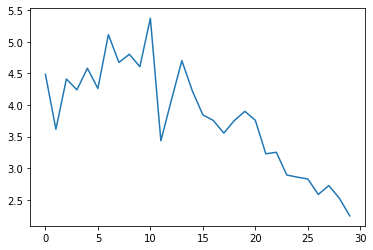

In [42]:
print(np.mean(err_list),err_list)
plt.plot(L_list_a)
print(stop)

In [ ]:
#Umap AdjacencyTrans2


emb_size= 150 ###!!!!24 for n2v emb
nhead= 6    ###!!!! 6 for n2v emb
num_encoder_layers = 3


transformer = AdjacencyTransformer_2(num_encoder_layers, emb_size, nhead,out=True)



for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = Loss(pen=0)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

transformer.load_state_dict(torch.load('AttTrack_2.pt',map_location=torch.device('cpu')))


NUM_EPOCHS = 2

loss_over_time=[]
test_error=[]

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer,loss_fn)
    end_time = timer()
    val_loss = evaluate(transformer,loss_fn)
    
    
    loss_over_time.append(train_loss)
    np.savetxt('./'+'train_loss_Ad2.txt', np.c_[loss_over_time],delimiter='\t',header='trainloss')
    
    test_error.append(val_loss)
                
    np.savetxt('./'+'test_loss_Ad2.txt', np.c_[test_error],delimiter='\t',header='testloss')

    
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    

    
    
    
loss_over_time= np.loadtxt('./train_loss_Ad2.txt',skiprows=1, delimiter='\t', usecols=(0), unpack=True)
test_error= np.loadtxt('./test_loss_Ad2.txt',skiprows=1, delimiter='\t', usecols=(0), unpack=True)


N=1

plt.plot(np.convolve(np.log10(loss_over_time), np.ones(N)/N, mode='valid'),c='red')
plt.plot(np.convolve(np.log10(test_error), np.ones(N)/N, mode='valid'))    



In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import umap.umap_ as umap


transformer.load_state_dict(torch.load('AttTrack_2.pt',map_location=torch.device('cpu')))
transformer.eval()

run=95
t= 8
src1, src2, y,d = collate_fn(31,-100,recon=True,train=False,run=run)
src_padding_mask1=create_mask(src1,-100)
src_padding_mask2=create_mask(src2,-100)


Ad,out1,out2,out_dec1,src_t1,src_t2 = transformer(src1,src2,src_padding_mask1,src_padding_mask2)



out_dec1=torch.transpose(out_dec1,2,1)
out_dec1=torch.transpose(out_dec1,1,0)
print(out_dec1.shape)


src_t1=src_t1[:,t,:]#[1:]
src_t2=src_t2[:,t,:]#[1:]

ind1=np.where(src_t1 == -100)
ind2=np.where(src_t2 == -100)

a=out1.detach().numpy()
b=out_dec1.detach().numpy()

a=a[:,t,:]#[1:]
b=b[:,t,:]#[1:]

a=a[0:ind1[0][0]]

b=b[0:ind2[0][0]]




blue_list=['#2a186c','#2e1f98','#1a3b9f','#0c5294','#16638d','#25738a','#328388','#3c9387','#45a383','#53b47c','#69c46f']
red_list=['#2f0303','#6e0302','#9a0303','#c40303','#f30203','#ff1f03','#ff4a04','#fe7104','#ffa001','#fec701','#fef903']
c_list=[]

for p in range(len(a)):
    c_list.append(blue_list[p])
    
for t in range(len(b)):
    c_list.append(red_list[t])

#print(c_list)
c_list=['blue']*len(a)+['black']*len(b)

#print(src_t1.shape)

src=np.vstack((a,b))

'''
mnist = fetch_openml("mnist_784", version=1)
X_train, X_test, y_train, y_test = train_test_split(
    mnist.data, mnist.target, stratify=mnist.target, random_state=42
)
'''
print(src.shape)
reducer = umap.UMAP(metric='cosine',n_neighbors=4)
embedding = reducer.fit_transform(src)
#print(embedding_train,embedding_train.shape)
#embedding_test = reducer.transform(X_test)
print(embedding)
plt.scatter(embedding[:, 0],embedding[:, 1],c=c_list)
plt.gca().set_aspect('equal')
'''[[11.102701   9.834718 ]
 [10.975245  11.376655 ]
 [11.55883   10.9941   ]
 [10.942158  10.440168 ]
 [10.304249  10.682447 ]
 [10.096922  10.017049 ]
 [10.49952   12.192604 ]
 [ 8.663966  11.4105625]
 [ 9.177266  12.255981 ]
 [ 8.936496  10.613881 ]
 [10.011719  11.911004 ]
 [ 9.29462   11.477478 ]
 [ 9.607173  10.698044 ]]'''

#plt.savefig('./umap_1_12_16.png',transparent=False)
#plt.savefig('./umap_1_12_16.png',transparent=False)

In [ ]:
tsne = TSNE(n_components=2)
print(src.shape)
tsne_results = tsne.fit_transform(src)



print(tsne_results)

plt.scatter(tsne_results[:,0],tsne_results[:,1],c=c_list)
plt.gca().set_aspect('equal')
#plt.savefig('./tsne_1_12_16.png',transparent=False)